High Value Customers Identification

# Project Solution Planning

Churn analytics: 
- Churn (or attrition), in the simplest terms, is when customers leave and stop buying your product or using your service during a defined time frame.

- In order to do keep churn rates as close to zero as possible, companies in nearly every industry need to treat churn as a top priority. If ignored, churn can plateau the growth of any business, even the ones that can gain customers quickly.

## Inputs

1. Problema de Negócio
    - Taxa de churn aumentou nos últimos meses
    - Rankear os clientes com maiores probabilidades de entrar em churn

2. Conjunto de dados
    - Atributos que descrevem os clientes de um determinado banco: ChrunDataset Kaggle

## Output

1. Indicação das pessoas que irão entrar em churn
    - Coluna em tabela com rankeado das pessoas com propensão de entrar em churn
    - Modelo em produção
    
2. Relatório com performance do modelo e respostas das perguntas:
     - Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
     - Qual a Performance do modelo em classificar os clientes como churns?
     - Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
     - Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    

## Tasks

1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
    - Calcular taxa atual, somatório da coluna target divido pelo número total de clientes da base
    
2. Qual a Performance do modelo em classificar os clientes como churns?
    - Calculo da performance do modelo
    - Verificar métricas de performance learning to rank
    
3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
    - Curva lift para comparação do modelo com o status quo da empresa e apresentação do resultado
    - Calcular diferença em reais do modelo
    - Calcular ROI
    - Comparativo entre ROIs

4. Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    - Classificar quais clientes trarão mais retorno para empresa com o incentivo.
    

# Imports

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import inflection
import matplotlib.pyplot as plt 
import pickle
import missingno as msno

from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV

from xgboost                       import XGBClassifier, DMatrix
from sklearn.experimental          import enable_iterative_imputer
from sklearn.impute                import KNNImputer,IterativeImputer
from sklearn.preprocessing         import StandardScaler, MinMaxScaler
from sklearn.model_selection       import train_test_split, KFold, StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.ensemble              import RandomForestClassifier
from sklearn.metrics               import classification_report
from sklearn.multiclass            import OneVsRestClassifier
from catboost                      import CatBoostClassifier, Pool, EFstrType
from sklearn.linear_model          import LogisticRegression
from sklearn.svm                   import SVC
from yellowbrick.classifier        import ROCAUC, ClassificationReport, ConfusionMatrix, ClassPredictionError, PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.features          import RadViz, ParallelCoordinates
from yellowbrick.model_selection   import CVScores, FeatureImportances
from yellowbrick.contrib.wrapper   import wrap
from scikitplot.metrics            import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve

from boruta                  import BorutaPy
from imblearn                import combine as c
from scipy                   import stats
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from IPython.core.display    import HTML
from IPython.display         import Image

# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

In [2]:
os.getcwd()

'/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/notebooks'

## Helper Functions

In [190]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# Model's performance function on training dataset
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test dataset function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

# Save figures function
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y-yhat ) / y ))

# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )

# def ml_error ( model_name, y, yhat):
#     mae = mean_absolute_error( y,yhat )
#     mape = mean_absolute_percentage_error( y,yhat )
#     rmse = np.sqrt(mean_squared_error( y,yhat ))
    
#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE': mae,
#                           'MAPE': mape,
#                           'RMSE': rmse}, index=[0])

# def cross_validation( x_training, kfold, model_name, model, verbose=False ):
#     mae_list = []
#     mape_list = []
#     rmse_list = []
    
#     for k in reversed( range( 1, kfold+1 ) ):
#         if verbose:
#             print( '\nKFold Number: {}'.format( k ) )
#         # start and end date for validation 
#         start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)
#         end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date'] < start_date_validation]
#         validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

#         # training and validation dataset
#         # training
#         xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#         ytraining = training['sales']

#         # validation
#         xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#         yvalidation = validation['sales']

#         # model
#         m = model.fit( xtraining, ytraining )

#         # prediction
#         yhat = m.predict( xvalidation )

#         # performance
#         m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#         # store performance of each kfold iteration
#         mae_list.append(  m_result['MAE'] )
#         mape_list.append( m_result['MAPE'] )
#         rmse_list.append( m_result['RMSE'] )

#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
#                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
#                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [180]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [181]:
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

 - **Source**: https://www.kaggle.com/mervetorkan/churndataset

In [5]:
df_churn_raw = pd.read_csv('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/data/raw/churn.csv', low_memory = False)

In [6]:
df_churn_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: corresponds to the record (row) number and has no effect on the output.
- **CustomerID**: Unique client identifier and has no effect on customer leaving the bank.
- **Surname**: Client's surname and has no effect on customer leaving the bank.
- **CreditScore**: Client's credit card score for the financial market. can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- **Geography**: The country where the client lives and a customer’s location can affect their decision to leave the bank.
- **Gender**: Client's gender. it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age**: Client's age. This is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure**:  Refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank. 
- **Balance**: The monetary amount the client has in their current account. Also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months). active customers are less likely to leave the bank.
- **EstimateSalary**: Client's annual salary estimate. As with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited**: Indicates if the client is a churn (tagert variable). Whether or not the customer left the bank. (0=No,1=Yes)

# DATA DISCRIPTION

In [7]:
# copy dataset
df0 = df_churn_raw.copy()

In [8]:
df0.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Rename Columns

In [12]:
cols_old = list(df0)
snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, cols_old))

# Rename columns
df0.columns = col_news
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [13]:
df0.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: corresponds to the record (row) number and has no effect on the output.
- **CustomerID**: Unique client identifier and has no effect on customer leaving the bank.
- **Surname**: Client's surname and has no effect on customer leaving the bank.
- **CreditScore**: Client's credit card score for the financial market. can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- **Geography**: The country where the client lives and a customer’s location can affect their decision to leave the bank.
- **Gender**: Client's gender. it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age**: Client's age. This is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure**:  Refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank. 
- **Balance**: The monetary amount the client has in their current account. Also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months). active customers are less likely to leave the bank.
- **EstimateSalary**: Client's annual salary estimate. As with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited**: Indicates if the client is a churn (tagert variable). Whether or not the customer left the bank. (0=No,1=Yes)

## Data Dimension and Type

In [14]:
print('Number of rows: {}'.format(df0.shape[0]))
print('Number of columns: {}'.format(df0.shape[1]))

Number of rows: 10000
Number of columns: 14


In [15]:
# check columns datatypes
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Check for duplicates

In [19]:
#check duplicates rows
df0.duplicated(subset = 'customer_id', keep = 'first').sum()

0

## Check NA Values

In [20]:
missing_count = df0.isnull().sum()
value_count = df0.isnull().count()

missing_percentage = round(missing_count/value_count*100, 2)
missing_df = pd.DataFrame({'missing value count': missing_count, 'percentage (%)': missing_percentage })
missing_df

,missing value count,percentage (%)
row_number,0,0.0
customer_id,0,0.0
surname,0,0.0
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,0,0.0
balance,0,0.0
num_of_products,0,0.0


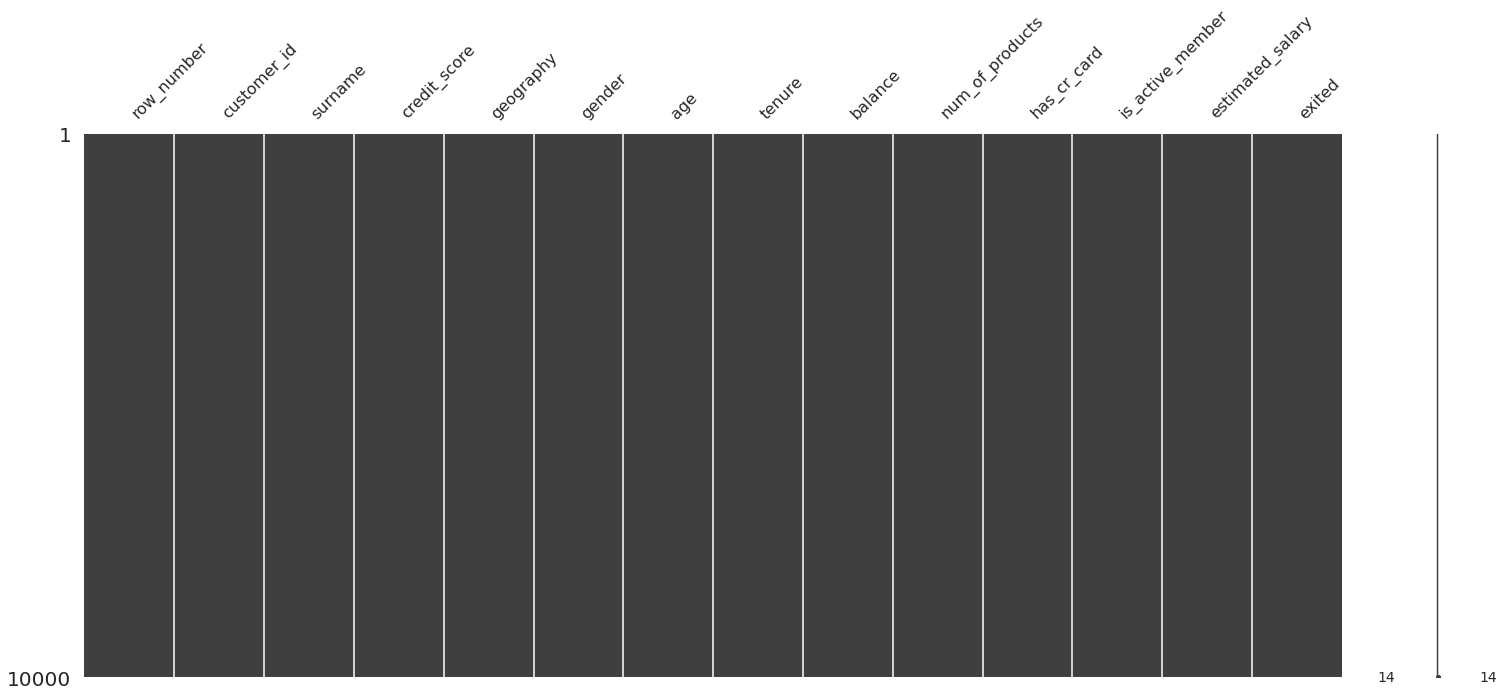

In [21]:
# check no missing values to confirm
msno.matrix(df0);

## Descriptive Statistics

In [24]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_cr_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [25]:
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [17]:
# # transforming categorical 1 or 0 values into 'yes' or 'no
# col_transform = ['has_cr_card', 'is_active_member']

# for col in col_transform:
#     df0[col] = df0[col].astype('str') 

# for col in col_transform:
#     df0[col] = df0[col].apply(lambda x: 'yes' if x=='1' else 'no')


In [26]:
# separate numerical and categorical attributes

num_att = df0.select_dtypes(include = 'number')
cat_att = df0.select_dtypes(include = 'object')

### Numerical Attributes

In [27]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_att.apply( np.std )).T
d2 = pd.DataFrame(num_att.apply( min )).T
d3 = pd.DataFrame(num_att.apply( max )).T
d4 = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_att.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_att.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


In [29]:
# check the unique elements of an array - numerical features
num_att.apply( lambda x: x.unique().shape[0])

row_number          10000
customer_id         10000
credit_score          460
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


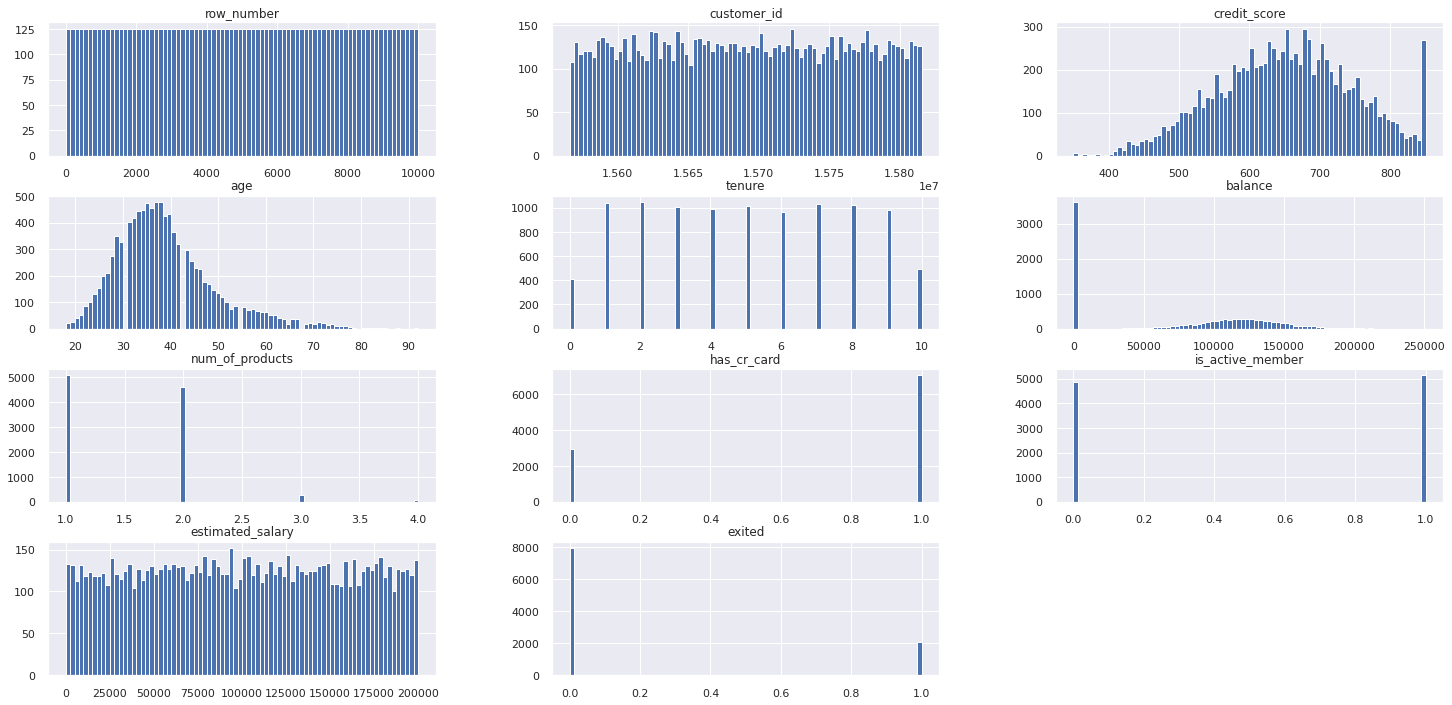

In [30]:
num_att.hist(bins = 80);

 
- Credit score ranges from 350 up to 850. Mean = 650.75. Median = 652.

- Age ranges from 18 up to 92. Mean = 38.95. Median = 37. 75% of the observations are up to the age 44.

- Tenure (number of years that the customer was active) ranges from 0 to 10. Mean = 5.02. Median = 5. 

- According the histogram, the number of customers with tenure equal to zero and 10 is lower than the other tenure values.

- Balance ranges from zero up to 238,387. Mean = 76,381. Median = 97,055. 25% of the observations have value equal to zero.

- Number of products ranges from 1 to 4. Mean = 1.53. Median = 1. 75% of the observations have value equal to 2. The histogram shows that the majority of number of products is 1 and 2. There is no number of products equal to zero, that is, all customers have bought at least one product.

- has_cr_card mean = 0.7087, that is, 70.87% of the observations have has_cr_card equal to 1.

- is_active_member mean = 0.5149, that is, 51.49% of the customers has done a bank activity in the past 12 months.

- Estimated salary ranges from 11.58 up to 199,992. Mean = 99,730. Median = 99,446. The histogram shows that the distribution is similar to an uniform distribution.

- less client in churn, about 20%

### Categorical Attributes

In [31]:
# check unique values of categorical features
cat_att.apply( lambda x: x.unique().shape[0])

surname      2932
geography       3
gender          2
dtype: int64

In [32]:
geo_percentage = df0['geography'].value_counts(normalize = True ) * 100
geo_percentage

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [33]:
gender_percentage = df0['gender'].value_counts(normalize = True)*100
gender_percentage

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [34]:
cred_card_percentage = df0['has_cr_card'].value_counts(normalize = True ) * 100
cred_card_percentage

1    70.55
0    29.45
Name: has_cr_card, dtype: float64

In [35]:
active_member_percentage = df0['is_active_member'].value_counts(normalize = True) * 100
active_member_percentage

1    51.51
0    48.49
Name: is_active_member, dtype: float64

Text(0, 0.5, 'Is a Active Member (%)')

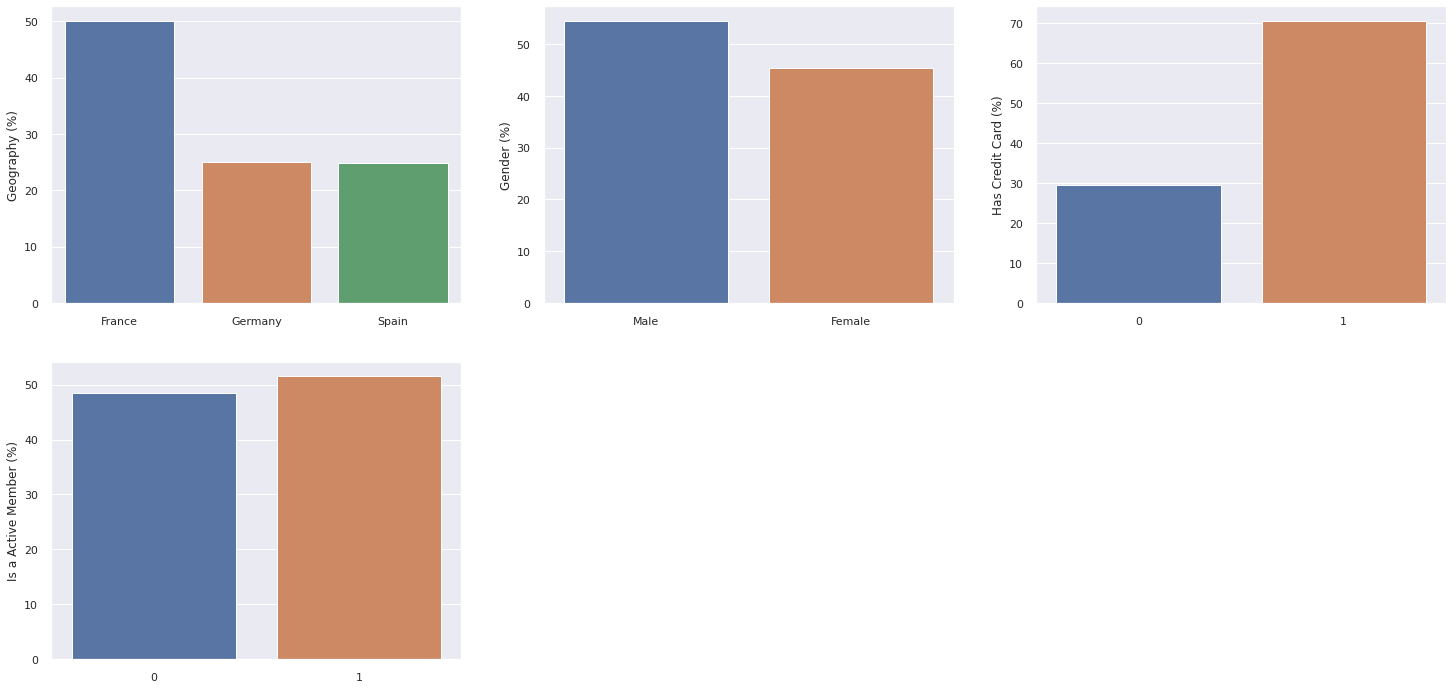

In [36]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

# subplot(2, 3, 5)
# sns.barplot(data = df0, x = exited_percentage.index, y = exited_percentage)
# plt.ylabel('%')
# plt.title('Churn Percentage');

### Zero values distribution

 Sometimes the data isn't missing (NaNs), but it can be in a form of an oddly high number of zero values 
 
 **Conclusion**: The 'Balance' columns have a great number of zeros, but it doesn't mean they are missing values (NaNs). Nevertheless, the Data Science team should get in contact with the business team to check if this number is correct

In [38]:
# create DataFrame with zero and non zero values
num_zero = num_att.copy()
num_col = num_zero.columns

for col in num_col :
    num_zero[col] = num_zero[col].apply(lambda x: 'zero' if x==0 else 'not zero')

In [39]:
# check which columns have zero values 
num_zero.apply( lambda x: x.unique().shape[0])

row_number          1
customer_id         1
credit_score        1
age                 1
tenure              2
balance             2
num_of_products     1
has_cr_card         2
is_active_member    2
estimated_salary    1
exited              2
dtype: int64

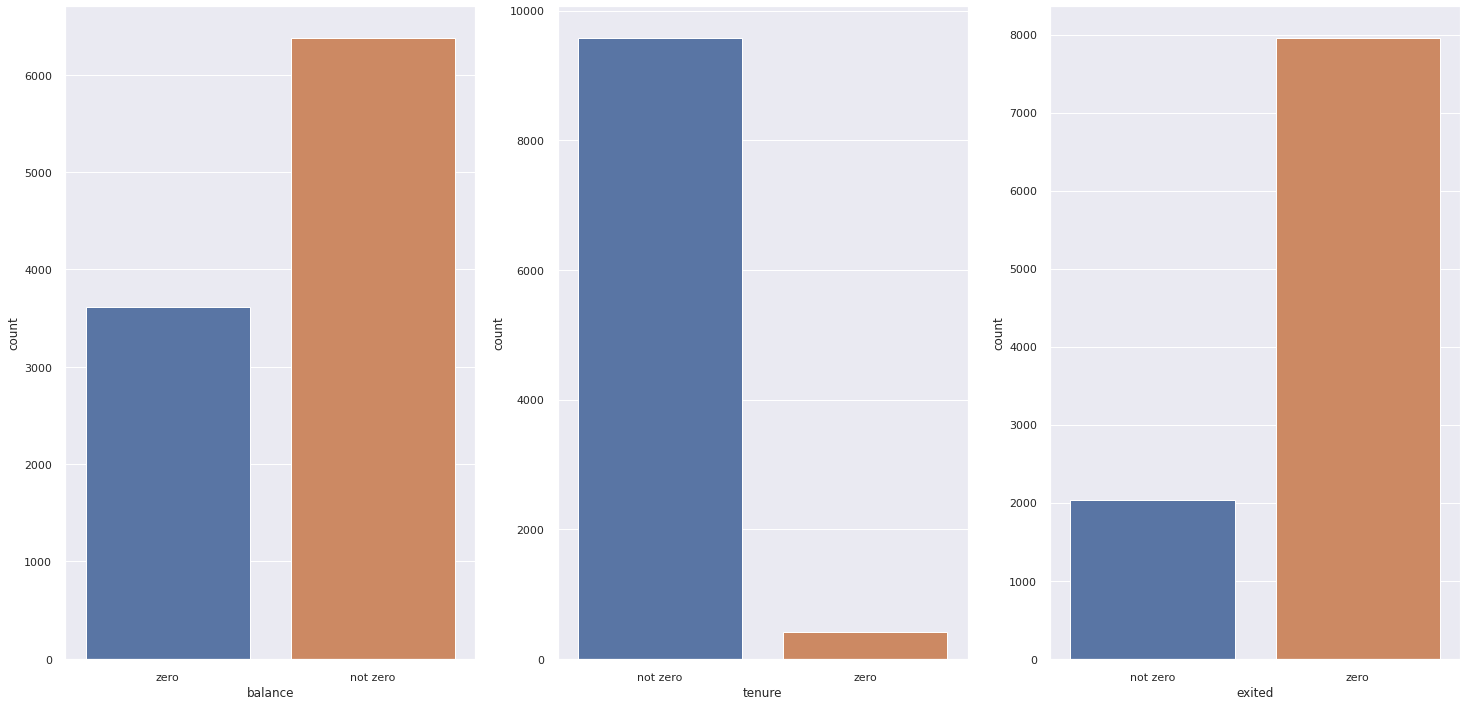

In [40]:
#Plot zero values proportion 
plt.subplot(1,3,1)
sns.countplot(x = 'balance', data = num_zero) 

plt.subplot(1,3,2)
sns.countplot(x = 'tenure', data = num_zero) 

plt.subplot(1,3,3)
sns.countplot(x = 'exited', data = num_zero);

# FEATURE ENGINEERING

In [41]:
# dataset copy
df1 = df0.copy()

## Hypothesis Mindmap

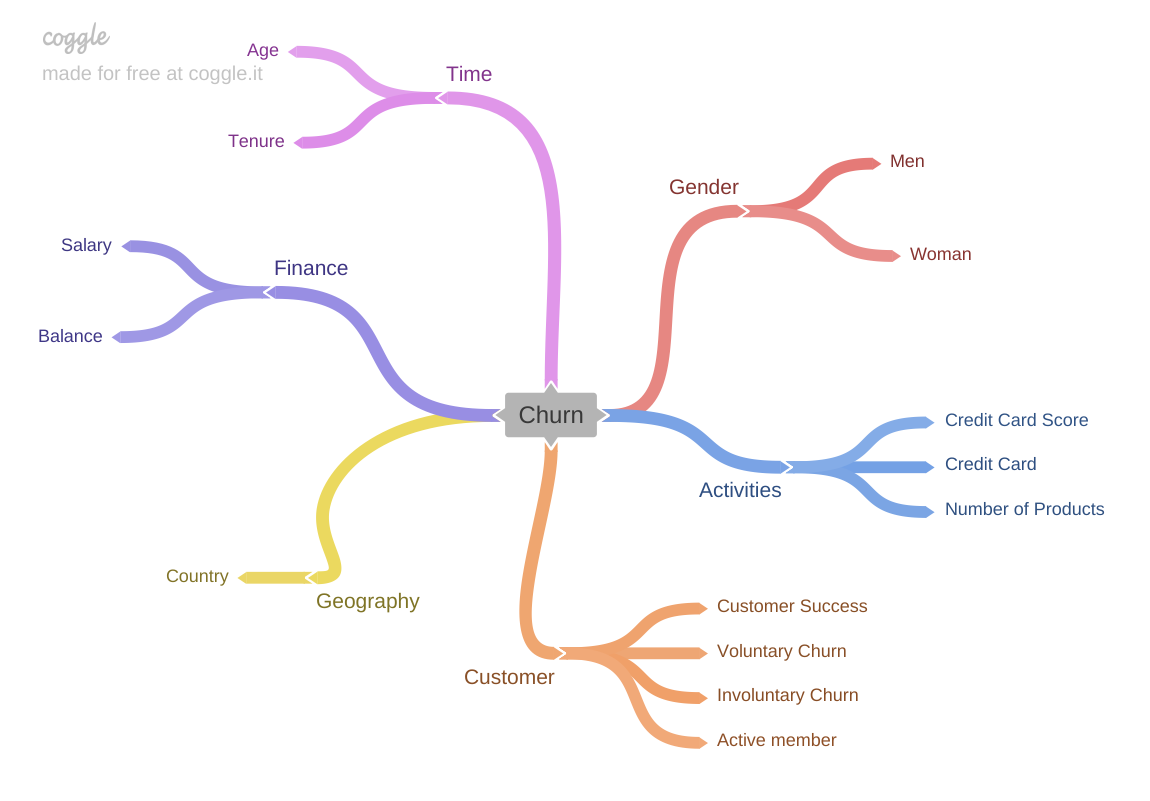

In [42]:
Image('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/reports/figures/Churn.png')

    . The goal of the hypothesis mind-map is to answer questions that are not clear in the dataset. To sum up it's a road map of which analysis do I have to do to validate hypothesis of the business and to which features do I have to create for a better understanding of the data during the Exploratory Data Analysis

Motivação da feature engineering:
    - ter variáveis disponíveis para estudo durante a Análise Exploratória de Dados e o mapa mental ajuda nessa atividade.
    - Um roteiro para mostrar quais análises preciso fazer para validar as hipóteses e quais variáveis precisarei ter para validar as hipóteses
    

In [43]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Creating Hypothesis

### Finance Hypothesis

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

### Geography Hypothesis

- H3. Customers who live in France tend to be in churn

### Customer Hypothesis

- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate

### Activities Hypothesis

- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more

### Gender Hypothesis

- H9. Womans tend to churn more often than mens

### Time Hypothesis


- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Final Hypothesis List

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

- H3. Customers who live in France tend to be in churn
- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Feature Engineering

**Feature Description**:

- **RowNumber**: corresponds to the record (row) number and has no effect on the output.
- **CustomerID**: Unique client identifier and has no effect on customer leaving the bank.
- **Surname**: Client's surname and has no effect on customer leaving the bank.
- **CreditScore**: Client's credit card score for the financial market. can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- **Geography**: The country where the client lives and a customer’s location can affect their decision to leave the bank.
- **Gender**: Client's gender. it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age**: Client's age. This is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure**:  Refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank. 
- **Balance**: The monetary amount the client has in their current account. Also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months). active customers are less likely to leave the bank.
- **EstimateSalary**: Client's annual salary estimate. As with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited**: Indicates if the client is a churn (tagert variable). Whether or not the customer left the bank. (0=No,1=Yes)

In [44]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [45]:
# create features

df1['tenure_year'] = df1['tenure'] + 1

df1['age_by_tenure'] = df1['age'] / df1['tenure_year']

df1['salary_by_credit'] = df1['estimated_salary'] / df1['credit_score']

df1['salary_by_age'] = df1['estimated_salary'] / df1['age']

df1['salary_by_tenure'] = df1['estimated_salary'] / df1['tenure_year']

df1['balance_by_age'] = df1['balance'] / df1['age']

df1['balance_by_prod'] = df1['balance'] / df1['num_of_products']

df1['all_money'] = df1['estimated_salary'] + df1['balance']

df1['money_by_credit'] = df1['all_money'] / df1['credit_score']

In [36]:
# # reorder columns

# df1 = df1[['row_number',
#  'customer_id',
#  'surname',
#  'credit_score',
#  'geography',
#  'gender',
#  'age',
#  'tenure',
#  'balance',
#  'num_of_products',
#  'has_cr_card',
#  'is_active_member',
#  'estimated_salary',
#  'age_by_tenure',
#  'salary_by_age',
#  'balance_by_age',
#  'balance_by_prod',
#  'salary_by_credit',
#  'all_money',
#  'money_by_credit','exited']]

In [46]:
list(df1)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

# VARIABLE FILTERING

In [48]:
df2 = df1.copy()

In [49]:
df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


## Line Filtering

## Columns Selection

In [50]:
# feature row_number, customer_id, surname are not necessary
df2 = df2.drop(['row_number', 'customer_id', 'surname'], axis = 1)

In [51]:
df2.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


# EXPLORATORY DATA ANALYSIS (EDA)

In [52]:
df3 = df2.copy()

## Univariate Analysis

### Response Variable

In [53]:
exited_percentage = df3['exited'].value_counts(normalize = True)*100
exited_percentage

0    79.63
1    20.37
Name: exited, dtype: float64

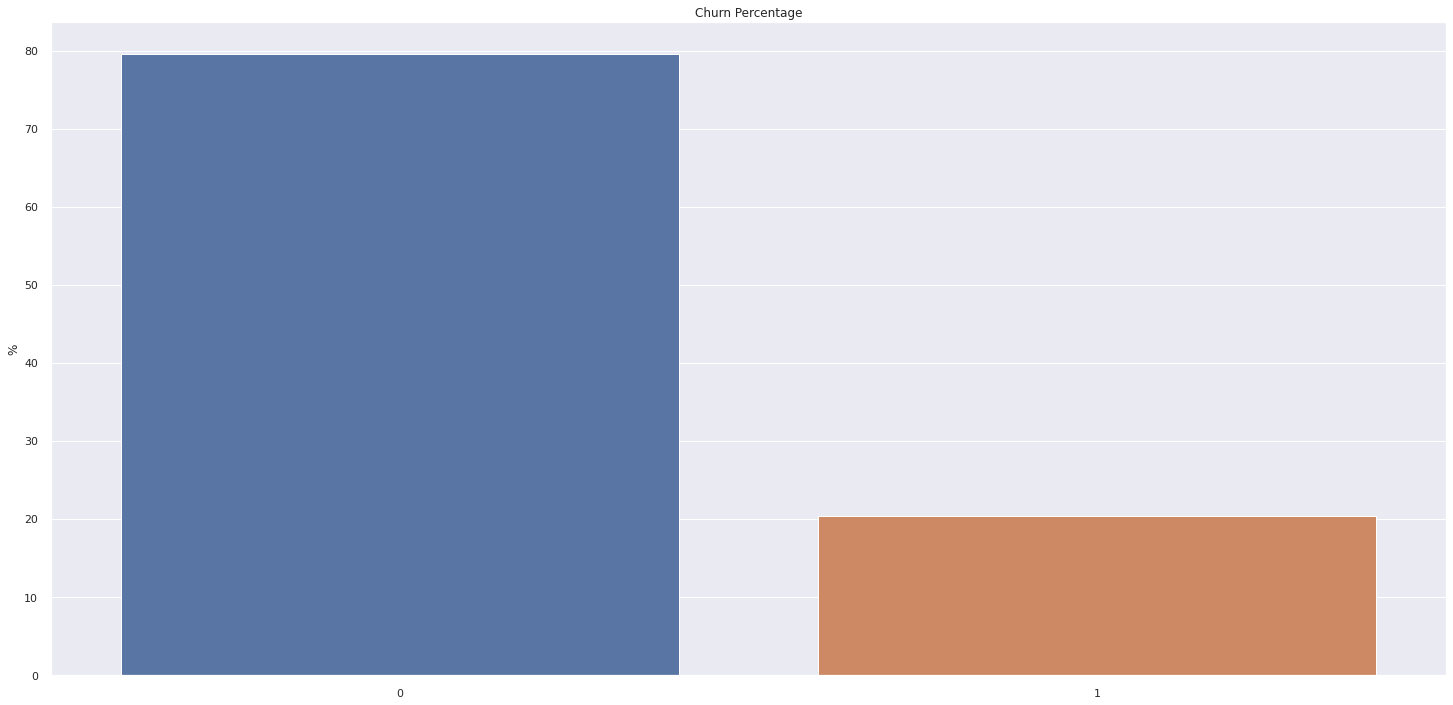

In [54]:
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

- 20% of the clients in this dataset are in churn

### Numerical Variable

In [55]:
# separate numerical and categorical attributes
num_att = df3.select_dtypes(include = 'number')

In [56]:
list(num_att)

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

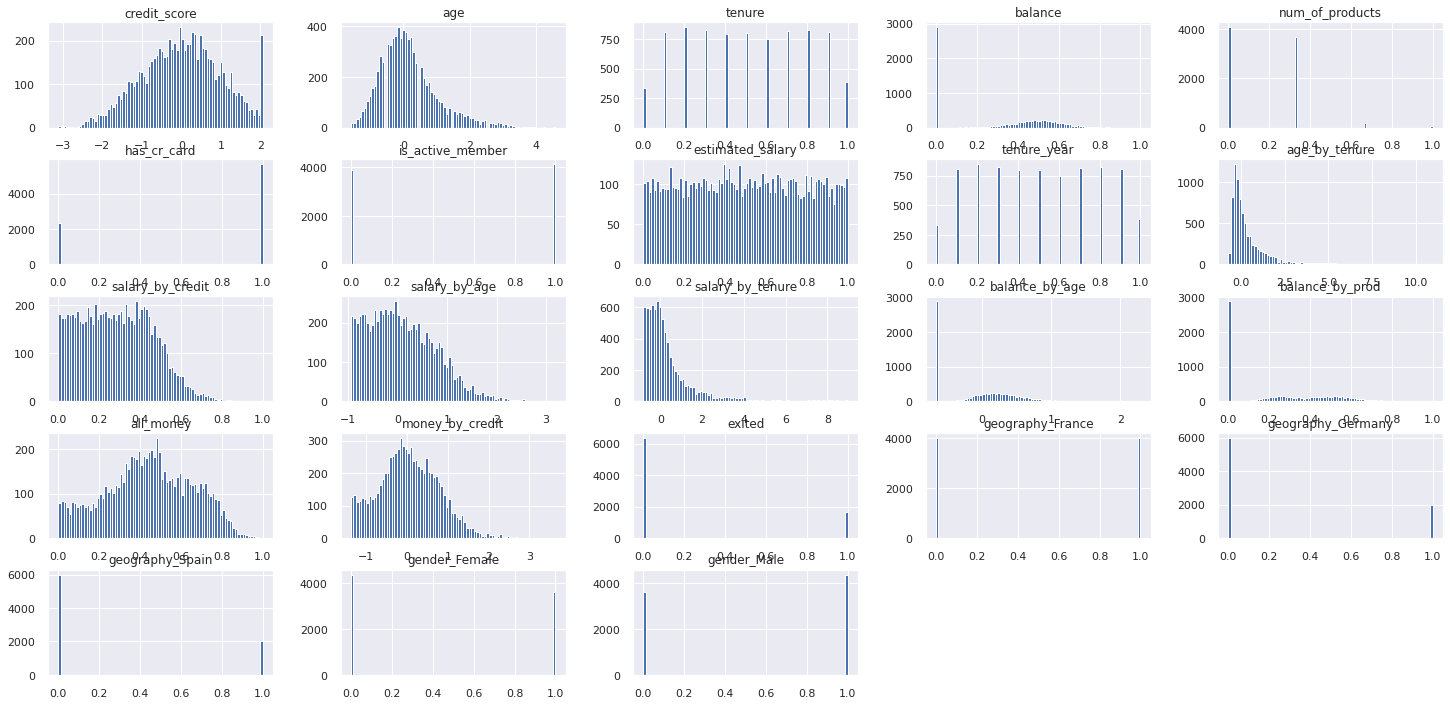

In [186]:
num_att.hist(bins = 80);

#### Credit Score

In [58]:
# credit score
# credit scores from 580 to 669 are considered fair; 670 to 739 are considered good;
# 740 to 799 are considered very good; and 800 and up are considered excellent.
aux_cred = df3[['credit_score', 'exited']].copy()
aux_cred['credit_score_cat'] = df3['credit_score'].apply(lambda x: 'bad' if x < 580 else
                                                              'fair' if (x >= 580 ) & (x < 669) else
                                                              'good' if (x >= 699) & (x < 739) else
                                                              'very good' if (x >= 739) & (x < 799)
                                                               else 'excellent')

aux_cred = aux_cred[['credit_score', 'credit_score_cat', 'exited']]

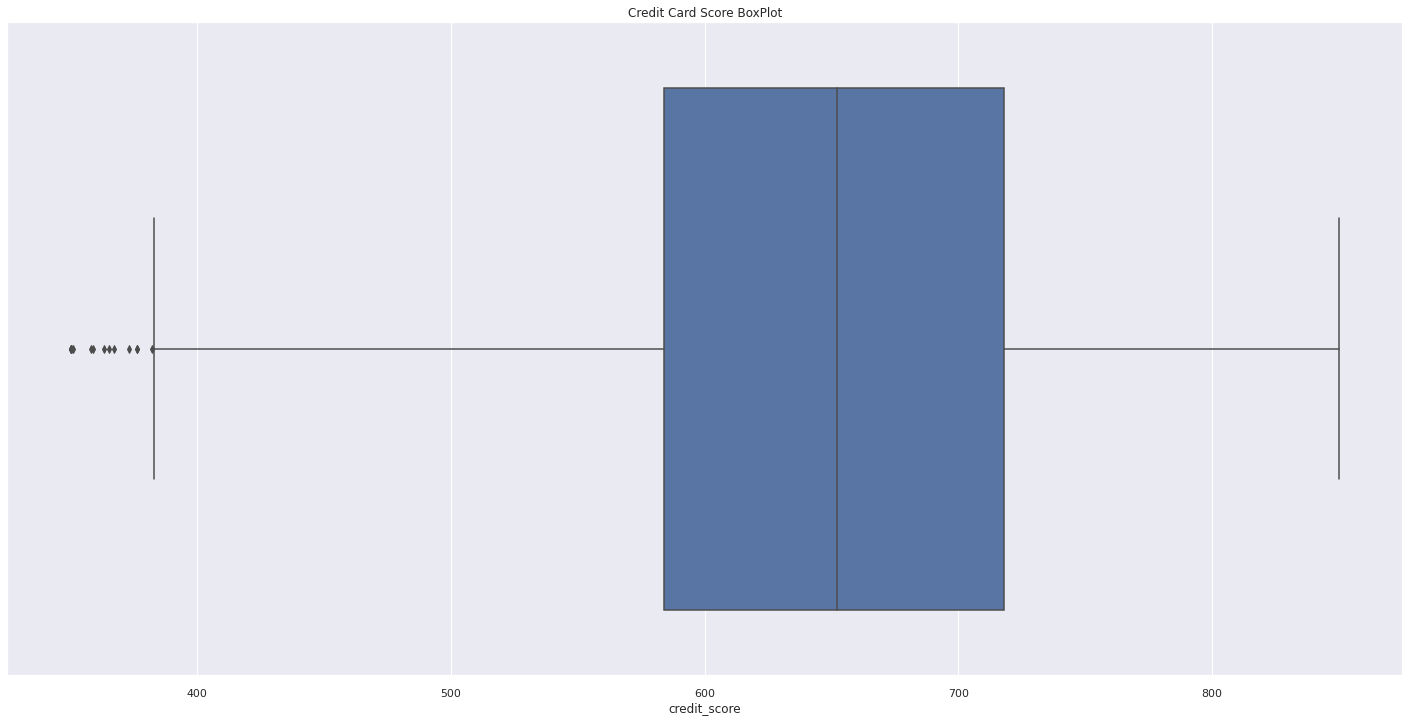

In [59]:
# credit score
sns.boxplot( x = 'credit_score', data = df3)
plt.title('Credit Card Score BoxPlot');

In [60]:
aux_cred.head()

,credit_score,credit_score_cat,exited
0,619,fair,1
1,608,fair,0
2,502,bad,1
3,699,good,0
4,850,excellent,0


In [61]:
aux_cred[aux_cred['credit_score'] < 400]

,credit_score,credit_score_cat,exited
7,376,bad,1
942,376,bad,1
1193,363,bad,1
1201,399,bad,1
1405,359,bad,1
1631,350,bad,1
1838,350,bad,1
1962,358,bad,1
2473,351,bad,1
2579,365,bad,1


In [62]:
aux_cred[aux_cred['credit_score'] < 400].count()

credit_score        19
credit_score_cat    19
exited              19
dtype: int64

- Credit card attribute has some outliers below 400 (a very bad credit card score)
- All these costumers have exited 

#### Age

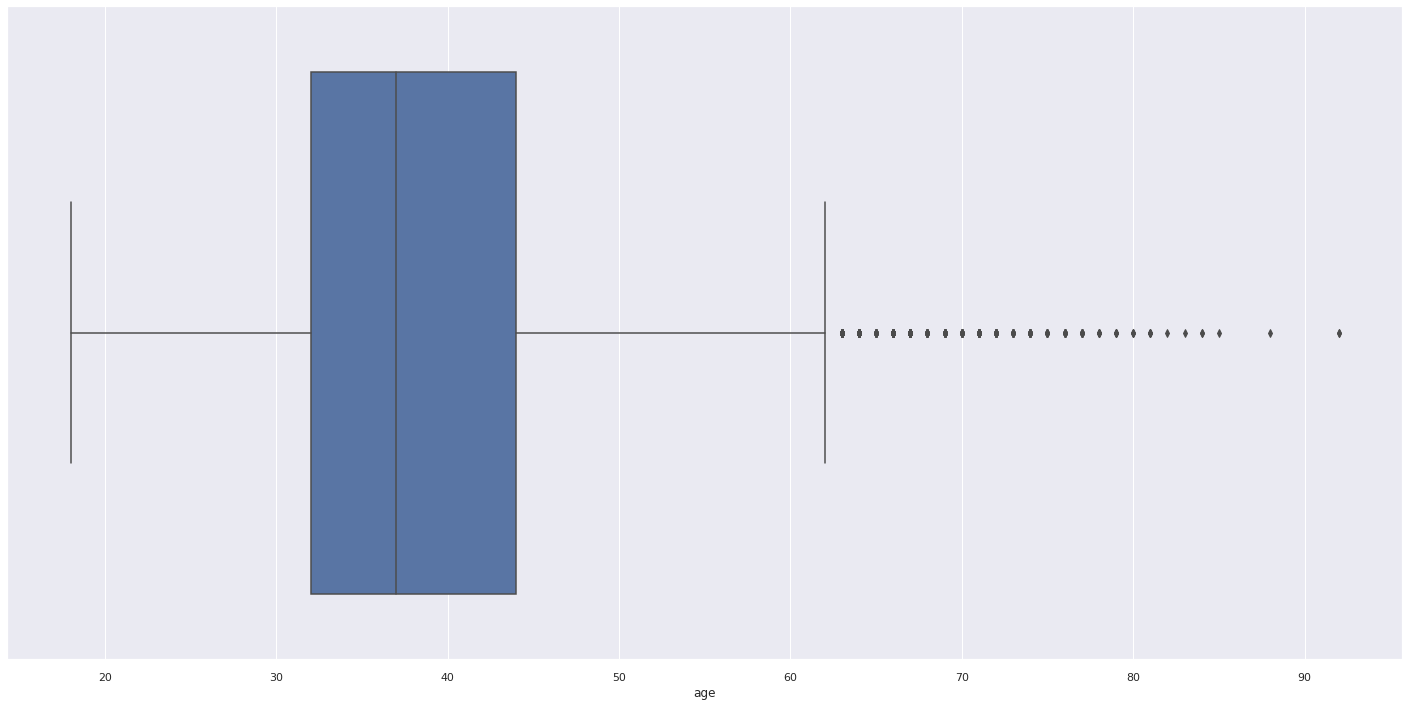

In [63]:
sns.boxplot( x = 'age', data = df3);

### Categorical Variable

In [64]:
cat_att = df3.select_dtypes(include = 'object')
cat_att.head()

,geography,gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


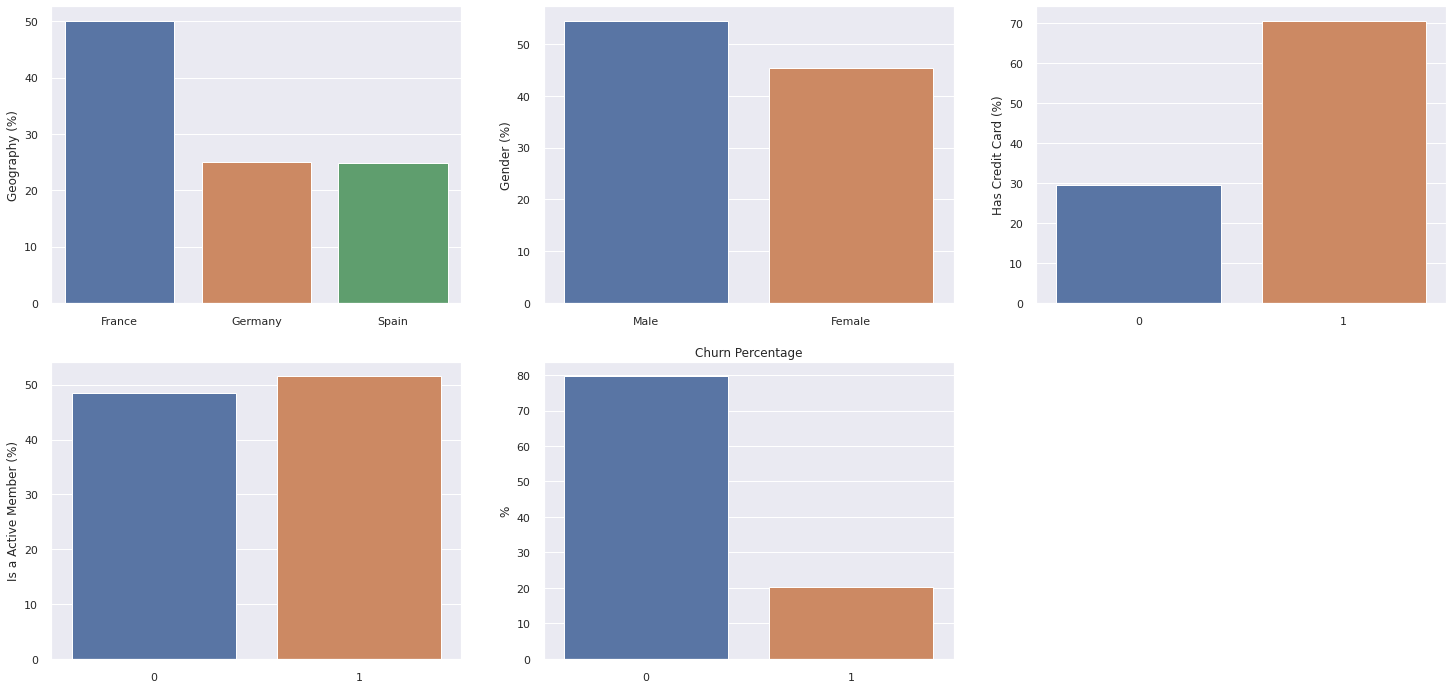

In [65]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

subplot(2, 3, 5)
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

## Bivariate Analysis

In [56]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


### H1. Customers with higher salaries tend to be in churn
**TRUE** Customers with hight salaries churn more often

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


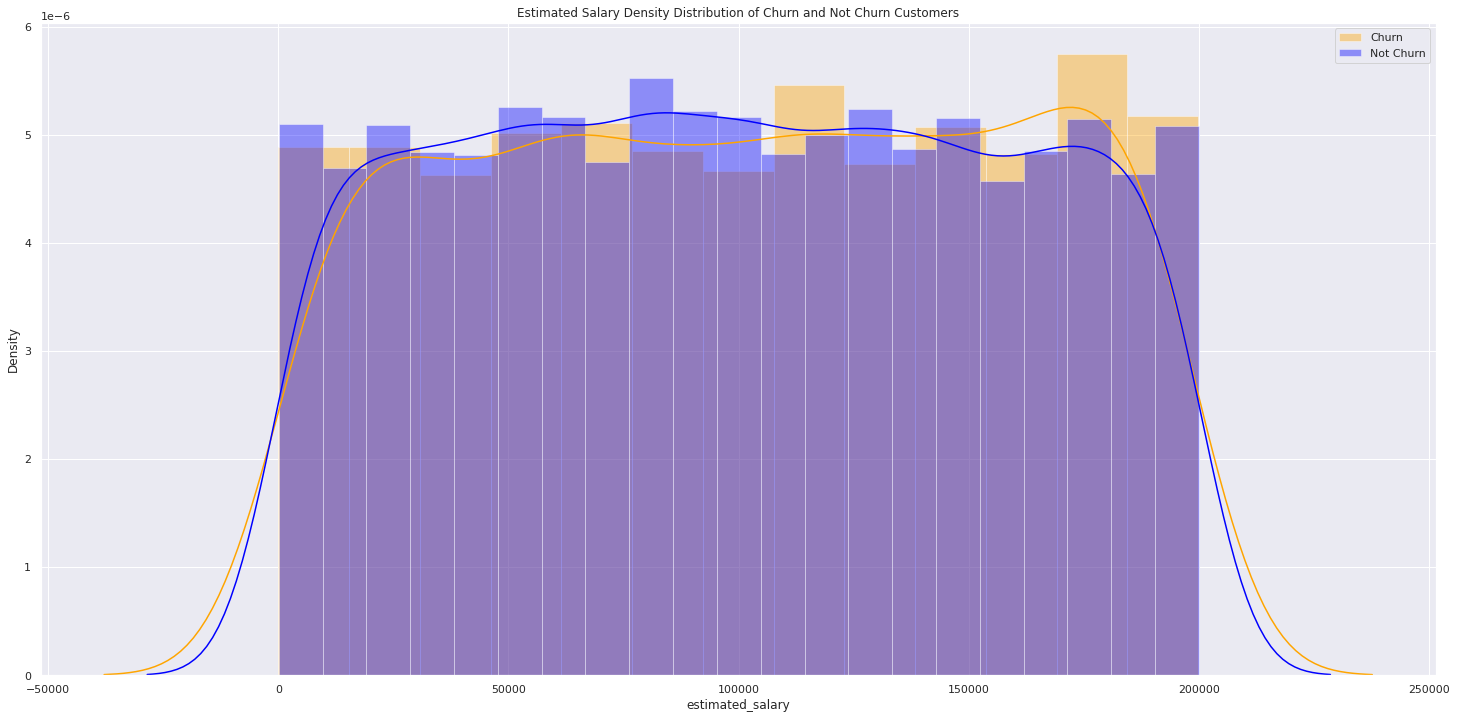

In [57]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot estimated salary density distribution for exited = 0 and 1
sns.distplot(aux_exited1['estimated_salary'], color = 'orange', kde = True, label = 'Churn')
sns.distplot(aux_exited0['estimated_salary'], color = 'blue', kde = True, label = 'Not Churn')
plt.title('Estimated Salary Density Distribution of Churn and Not Churn Customers');
plt.legend();

In [58]:
a = df0.groupby('exited')['estimated_salary'].sum().reset_index()
a

,exited,estimated_salary
0,0,7.942168e+08
1,1,2.066856e+08


In [59]:
# Estimated Salary Describe - Not Churn and Churn
a = df3.groupby('exited')['estimated_salary'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a = a.T
a.columns = ['Not Churn', 'Churn']
a

,Not Churn,Churn
count,7963.000000,2037.000000
mean,99738.391772,101465.677531
median,99645.040000,102460.840000
std,57405.586966,57912.418071
min,90.070000,11.580000
max,199992.480000,199808.100000


<ipython-input-60-da110929af01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
<ipython-input-60-da110929af01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)


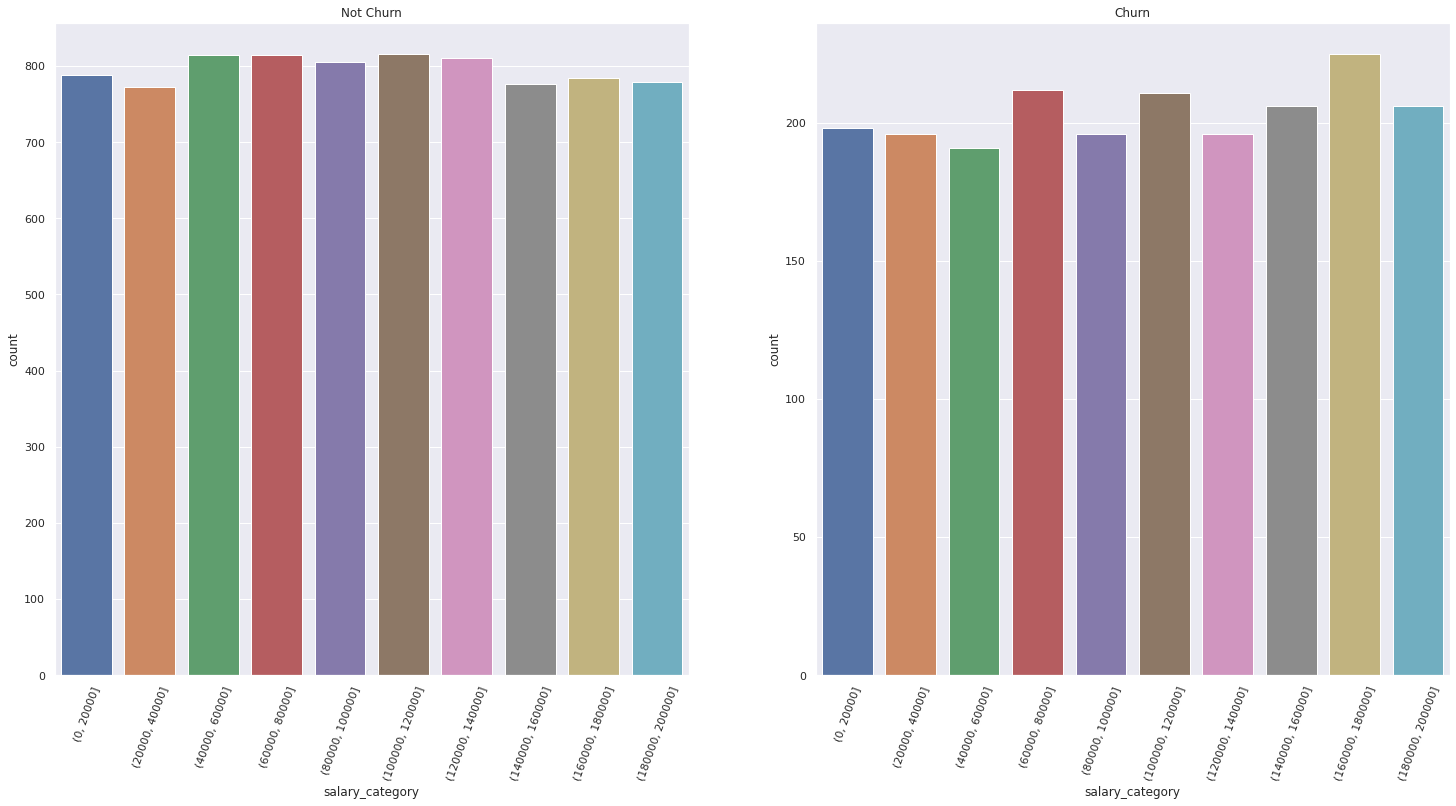

In [60]:
# Create Estimate Salary Categories
bins = list(np.arange(0,210000, 20000))
aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)

subplot(1, 2, 1)
sns.countplot(x = 'salary_category', data = aux_exited0).set_title('Not Churn')
plt.xticks(rotation = 70)

subplot(1, 2, 2)
sns.countplot(x = 'salary_category', data = aux_exited1).set_title('Churn')
plt.xticks(rotation = 70);

In [61]:
# Create Relative Salaray Percentage Count plot, since the salary count of 
#churn and not churn clients are too different

bins = list(np.arange(0,210000, 20000))

# create new dataframe
aux1 = df3[['estimated_salary', 'exited']]
aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)

# new dataframe with salary_category, exited, and number of clients 
aux10 = aux1[['salary_category', 'estimated_salary', 'exited']].groupby(['salary_category', 'exited']).count().reset_index()

# rename dataframe columns
aux10.columns = ['salary_category', 'exited', 'number_of_clients']

# sum of clients in churn
clients_churn = aux10[aux10['exited'] == 1]['number_of_clients'].sum()

# sum of clients not in churn
clients_not_churn = aux10[aux10['exited'] == 0]['number_of_clients'].sum()

total_clients = aux10['number_of_clients'].sum()

# calculate the relative percentage ratio of clients not or in churn
aux10['relative_percentage'] = aux10.apply(lambda x: (x['number_of_clients']/clients_churn)*100 if x['exited'] == 1 else (x['number_of_clients']/clients_not_churn)*100, axis = 1 )

aux10.head(30)

<ipython-input-61-84a28a771cdf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)


,salary_category,exited,number_of_clients,relative_percentage
0,"(0, 20000]",0,788,9.895768
1,"(0, 20000]",1,198,9.720177
2,"(20000, 40000]",0,773,9.707397
3,"(20000, 40000]",1,196,9.621993
4,"(40000, 60000]",0,815,10.234836
5,"(40000, 60000]",1,191,9.376534
6,"(60000, 80000]",0,815,10.234836
7,"(60000, 80000]",1,212,10.407462
8,"(80000, 100000]",0,806,10.121813
9,"(80000, 100000]",1,196,9.621993


In [62]:
clients_churn

2037

In [63]:
total_clients = aux10['number_of_clients'].sum()
total_clients

10000

In [64]:
clients_not_churn

7963

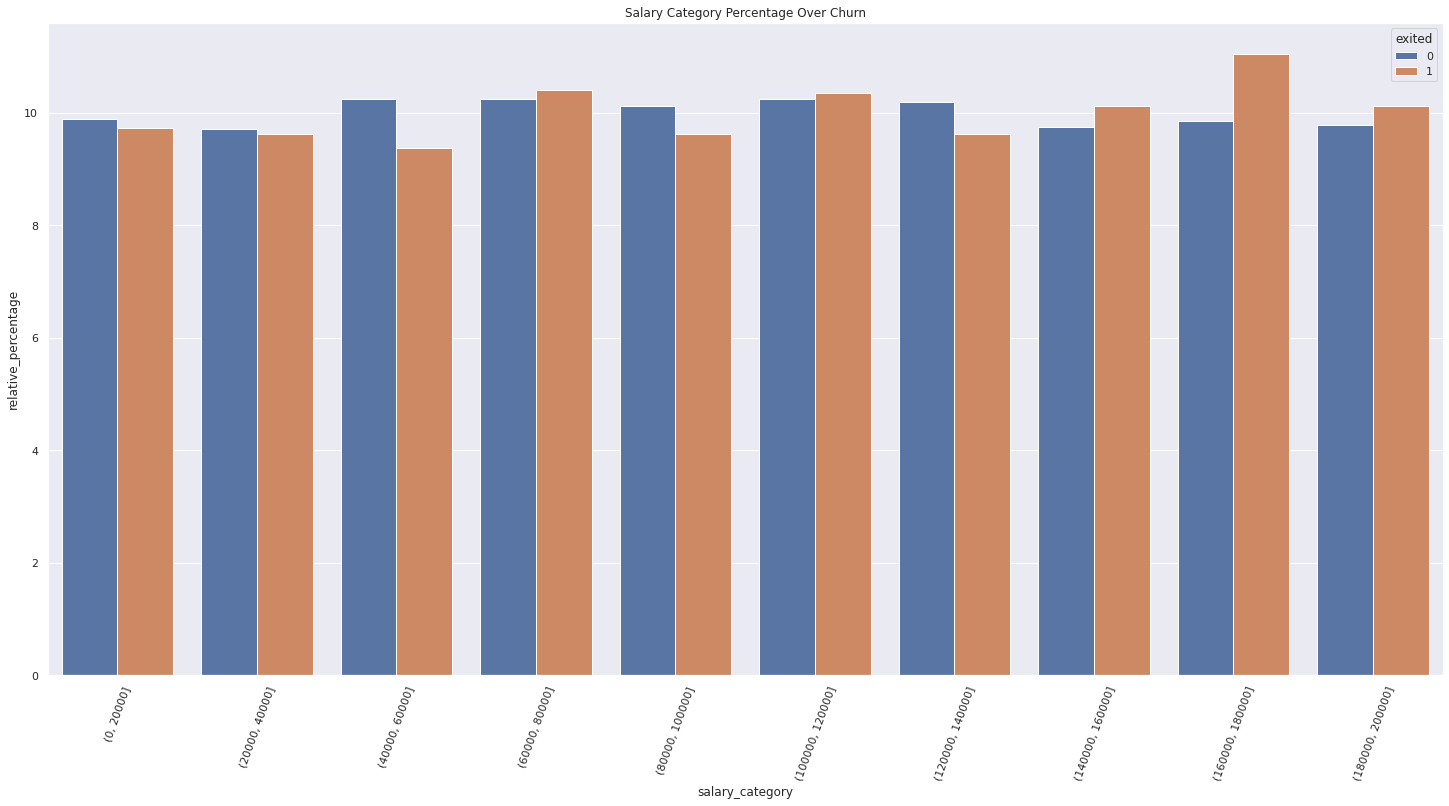

In [65]:
sns.barplot(x = 'salary_category', y = 'relative_percentage' ,data = aux10, hue = 'exited').set_title('Salary Category Percentage Over Churn')
plt.xticks(rotation = 70);

In [66]:
aux102 = aux10[aux10['exited'] == 1]
aux102.sort_values('relative_percentage', ascending = False)

,salary_category,exited,number_of_clients,relative_percentage
17,"(160000, 180000]",1,225,11.045655
7,"(60000, 80000]",1,212,10.407462
11,"(100000, 120000]",1,211,10.358370
15,"(140000, 160000]",1,206,10.112911
19,"(180000, 200000]",1,206,10.112911
1,"(0, 20000]",1,198,9.720177
3,"(20000, 40000]",1,196,9.621993
9,"(80000, 100000]",1,196,9.621993
13,"(120000, 140000]",1,196,9.621993
5,"(40000, 60000]",1,191,9.376534


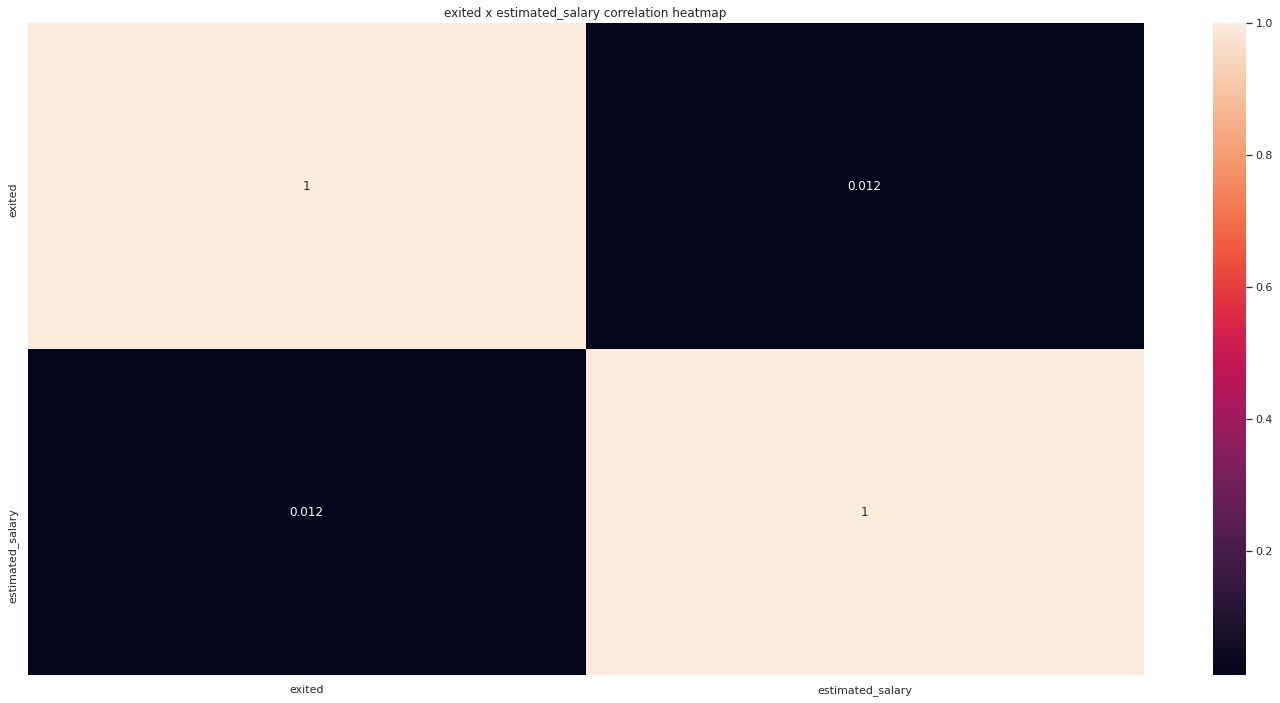

In [67]:
# point-biserial correlation coefficient heatmap.
# The point biserial correlation coefficient, rpbi, is a special case of Pearson’s correlation coefficient. It measures the relationship between two variables:
# One continuous variable (must be ratio scale or interval scale). and the other naturally binary variable.*

point_bi_corr(df3[['exited']], df3[['estimated_salary']]);

 Parafrasear!
- The estimated salary is evenly distributed for both active clients (exited = 0) and clients in churn (exited = 1), therefore it is hard to detect a variation which could indicate client in churn. The correlation heatmap confirms this with a low coefficient of 0.02.
- The salary relative percentage plot shows that clients with salary greater than 100,000, the relative percentage of churn (orange bars) is always greater than the relative percentage of active members (blue bars).
- Also, for clients in churn, the top four salary relative percentage are from range values greater than 100,000.
- The relative percentage of salaries greater than 100,000 is 52.23%.
- Therefore, the hypothesis is true: churn occur for clients with high salary.

### H2. Customers with lower balances tend to be in churn
**FALSE** Customers with higher balance churn more often

In [68]:
aux_exited0.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,salary_category
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860,196350.44,322.944803,"(100000, 120000]"
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000,93826.63,134.229800,"(80000, 100000]"
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820,204594.92,240.699906,"(60000, 80000]"
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,8,6.250000,12.241849,201.256000,1257.850000,0.000000,0.000,10062.80,12.241849,"(0, 20000]"
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,5,8.800000,149.581836,1703.193182,14988.100000,3228.433409,71025.535,216991.57,433.116906,"(60000, 80000]"


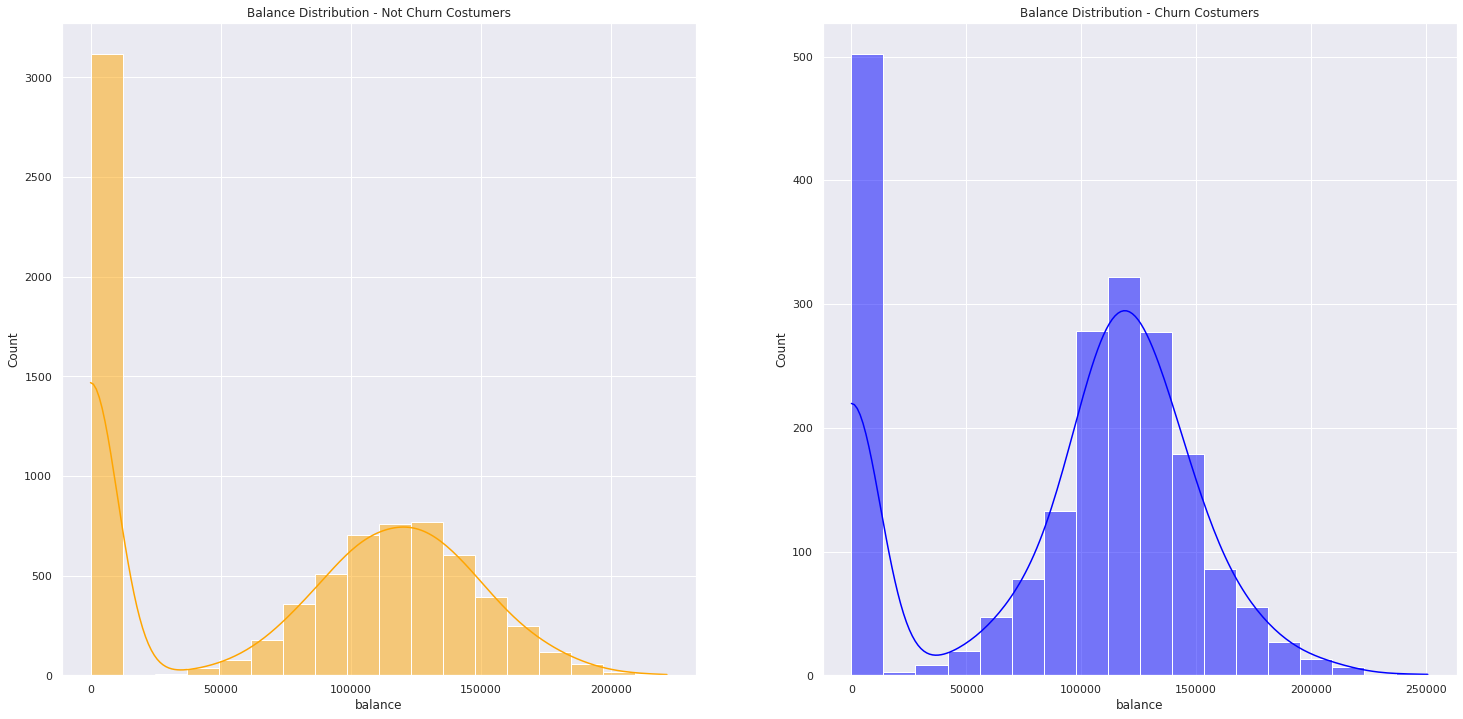

In [69]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot balance distribution of clients 
subplot(1, 2, 1)
sns.histplot(data = aux_exited0, x = 'balance', kde = True, color = 'orange' ).set_title('Balance Distribution - Not Churn Costumers');

subplot(1, 2, 2)
sns.histplot(data = aux_exited1, x = 'balance', kde = True, color = 'blue').set_title('Balance Distribution - Churn Costumers');



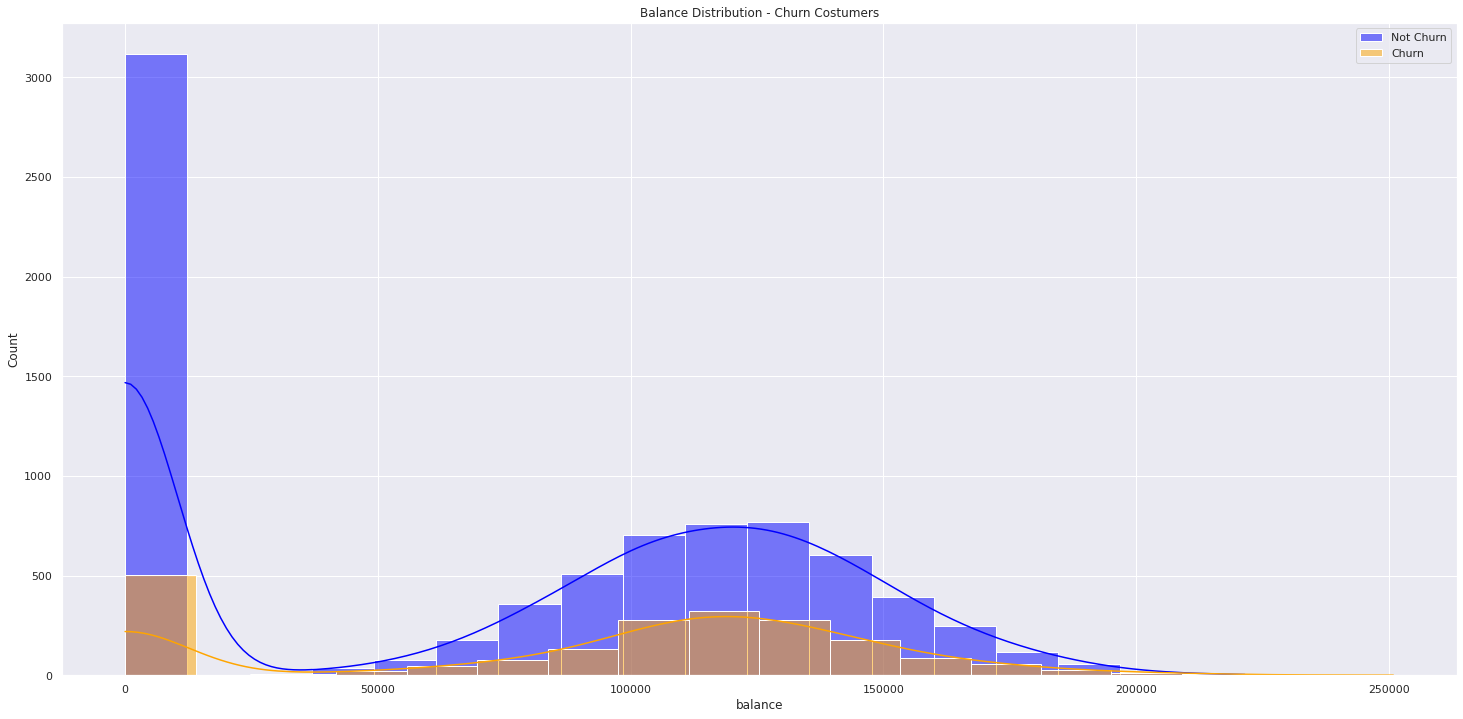

In [70]:
# plot balance distribution of clients 
sns.histplot(data = aux_exited0, x = 'balance', kde = True, color = 'blue', label = 'Not Churn').set_title('Balance Distribution - Not Churn Costumers');
sns.histplot(data = aux_exited1, x = 'balance', kde = True, color = 'orange', label = 'Churn' ).set_title('Balance Distribution - Churn Costumers');
plt.legend();


In [71]:
# balance category over churn

aux2 = df3[['balance', 'exited']]

# create balance categories
bins = list(np.arange(-1, 220000, 20000))
aux2['balance_cat'] = pd.cut(aux2['balance'], bins = bins)

# create new dataframe with columns ['number_of_clients', balance_cat, exited]
aux20 = aux2[['balance_cat', 'balance', 'exited']].groupby(['balance_cat', 'exited']).count().reset_index()

aux20.columns = ['balance_cat', 'exited', 'number_of_clients']

clients_churn = aux20.loc[aux20['exited'] == 1]['number_of_clients'].sum()
clients_not_churn = aux20.loc[aux20['exited'] == 0 ]['number_of_clients'].sum()

# evaluate relative percentage
aux20['relative_percentage'] = aux20.apply(lambda x: x['number_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['number_of_clients']/clients_not_churn)*100, axis = 1)

aux20.head(10)


<ipython-input-71-a59cfafc1960>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2['balance_cat'] = pd.cut(aux2['balance'], bins = bins)


,balance_cat,exited,number_of_clients,relative_percentage
0,"(-1, 19999]",0,3119,39.173574
1,"(-1, 19999]",1,502,24.680433
2,"(19999, 39999]",0,16,0.200955
3,"(19999, 39999]",1,9,0.442478
4,"(39999, 59999]",0,93,1.168048
5,"(39999, 59999]",1,33,1.622419
6,"(59999, 79999]",0,345,4.333082
7,"(59999, 79999]",1,85,4.178958
8,"(79999, 99999]",0,802,10.072846
9,"(79999, 99999]",1,197,9.685349


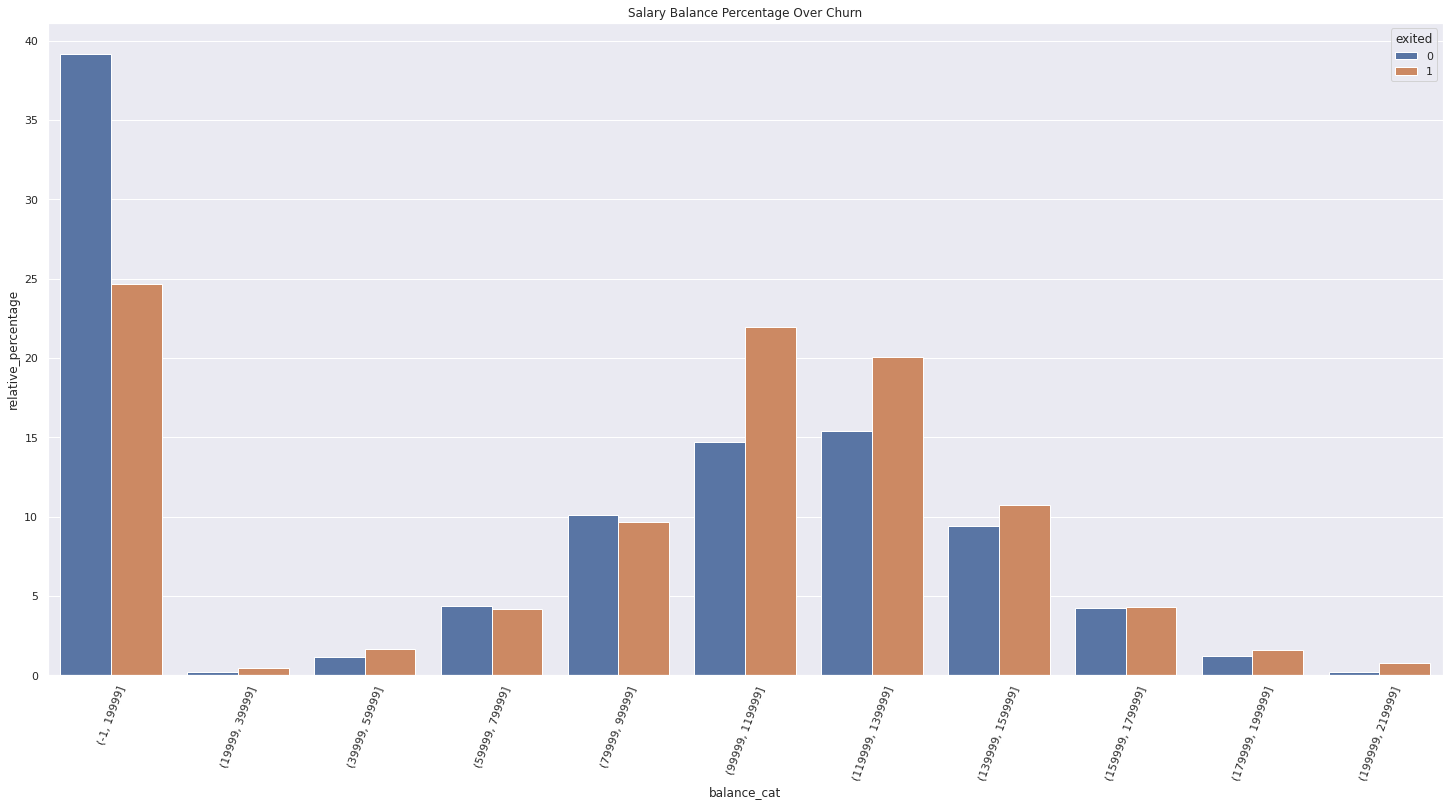

In [72]:
sns.barplot(data = aux20, x = 'balance_cat', y = 'relative_percentage', hue = 'exited' ).set_title('Salary Balance Percentage Over Churn')
plt.xticks(rotation = 70);

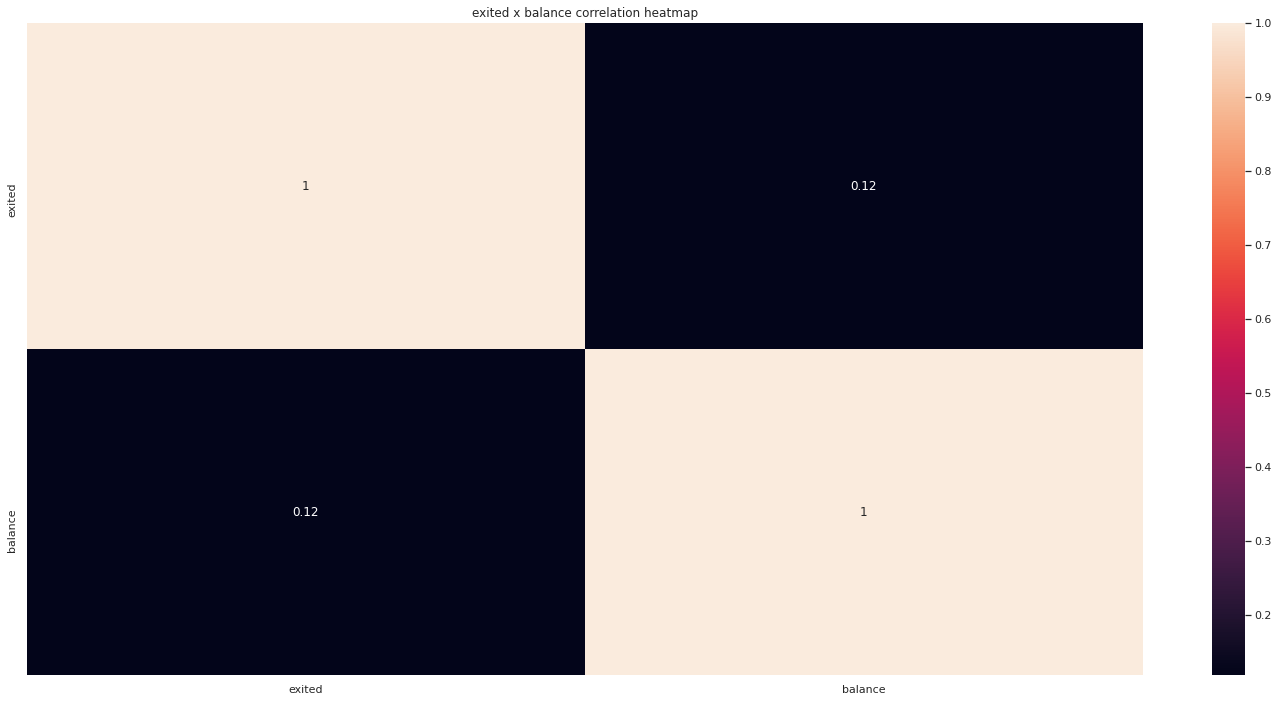

In [73]:
# point-biserial correlation coefficient heatmap.
# The point biserial correlation coefficient, rpbi, is a special case of Pearson’s correlation coefficient. It measures the relationship between two variables:
# One continuous variable (must be ratio scale or interval scale). and the other naturally binary variable.*

point_bi_corr(df3[['exited']], df3[['balance']]);

 Parafrasear
- 39% of clients not in churn have balance equal to zero. 24% of clients in churn have balance equal to zero.
- The balance density distribution shows that as the balance value increases, the relative proportion of clients in churn is greater than the proportion of clients not in churn.
- The Balance group's relative percentage barplot shows that from balance 90,000 on, the relative percentage of clients in churn is greater than the relative percentage of clients not in churn.
- The correlation heatmap shows a correlation coefficient of 0.12 between balance and exited feature.The balance x bal_ten_year scatterplot doesn't show a clear pattern of clients in churn.
- Therefore, the hypothesis is true: churn occur for clients with high balance.

### H3. Customers who live in France tend to be in churn
**FALSE** Customers who live in Germany churn more often

In [74]:
df3['geography'].value_counts(normalize = True)*100

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

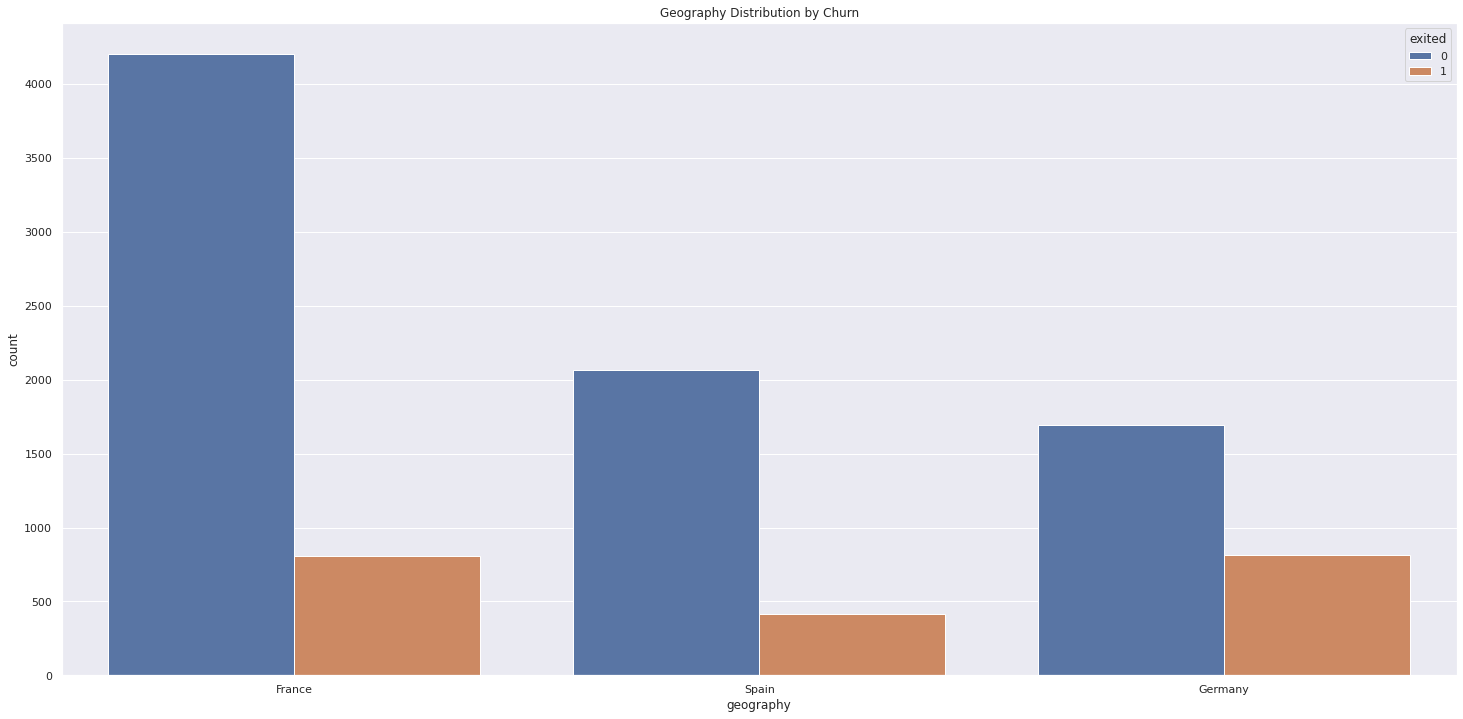

In [75]:
# countplot of geography by churn
sns.countplot(data = df3, x = 'geography', hue = 'exited').set_title('Geography Distribution by Churn');

In [76]:
# creating realite percentage once france has more costumers than the others
aux3 =  df3[['geography', 'balance','exited']].groupby(['geography', 'exited']).count().reset_index()
aux3.columns = ['geography', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux3.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux3.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux3['relative_percentage'] = aux3.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux3.head(10)


,geography,exited,num_of_clients,relative_percentage
0,France,0,4204,52.794173
1,France,1,810,39.764359
2,Germany,0,1695,21.285948
3,Germany,1,814,39.960727
4,Spain,0,2064,25.919879
5,Spain,1,413,20.274914


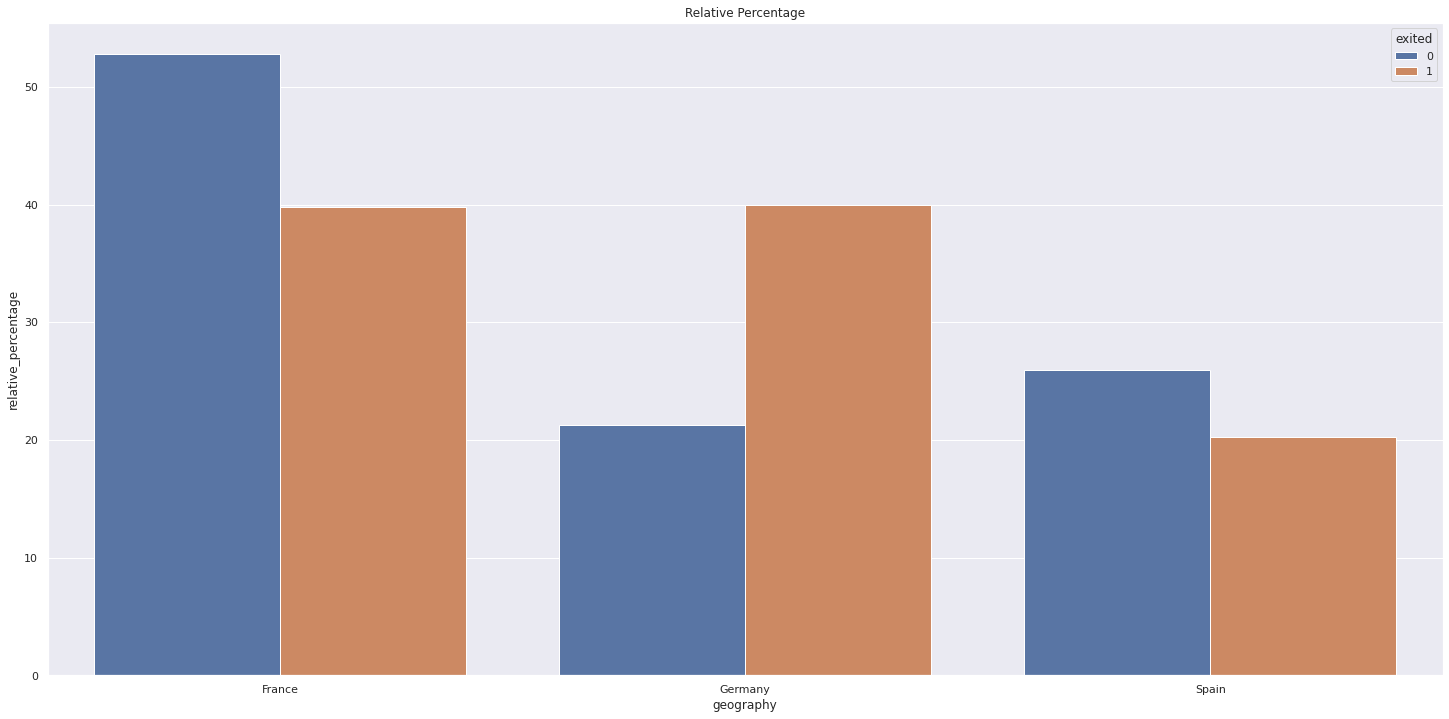

In [77]:
sns.barplot(data = aux3,x = 'geography', y = 'relative_percentage', hue = 'exited').set_title('Relative Percentage');

- As previously checked, 3993 clients (49.91%) are from France, 2005 clients (25.06%) are from Germany and 2002 clients (25.03%) are from Spain.
- Clients not in churn: 52.7% are from France, 26.2% are from Spain and 21.1% are from Germany. Compared to the whole dataset ratio, Germany decreased its proportion in aprox. 4%.
- Clients in churn: 40.7% are from Germany, 39% are from France and 20.3% are from Spain. Compared to the whole dataset ratio, Germany increased its proportion in aprox. 15%. Conversely, Spain's ratio decreased in aprox. 5%.
- Therefore, the hypothesis is False: Churn rate is lower for clients from Spain.

### H4. Active members should churn more than inactive ones
**False** Inactive members churn more often

In [78]:
df3['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

In [79]:
df3['is_active_member'].value_counts(normalize = True)*100

1    51.51
0    48.49
Name: is_active_member, dtype: float64

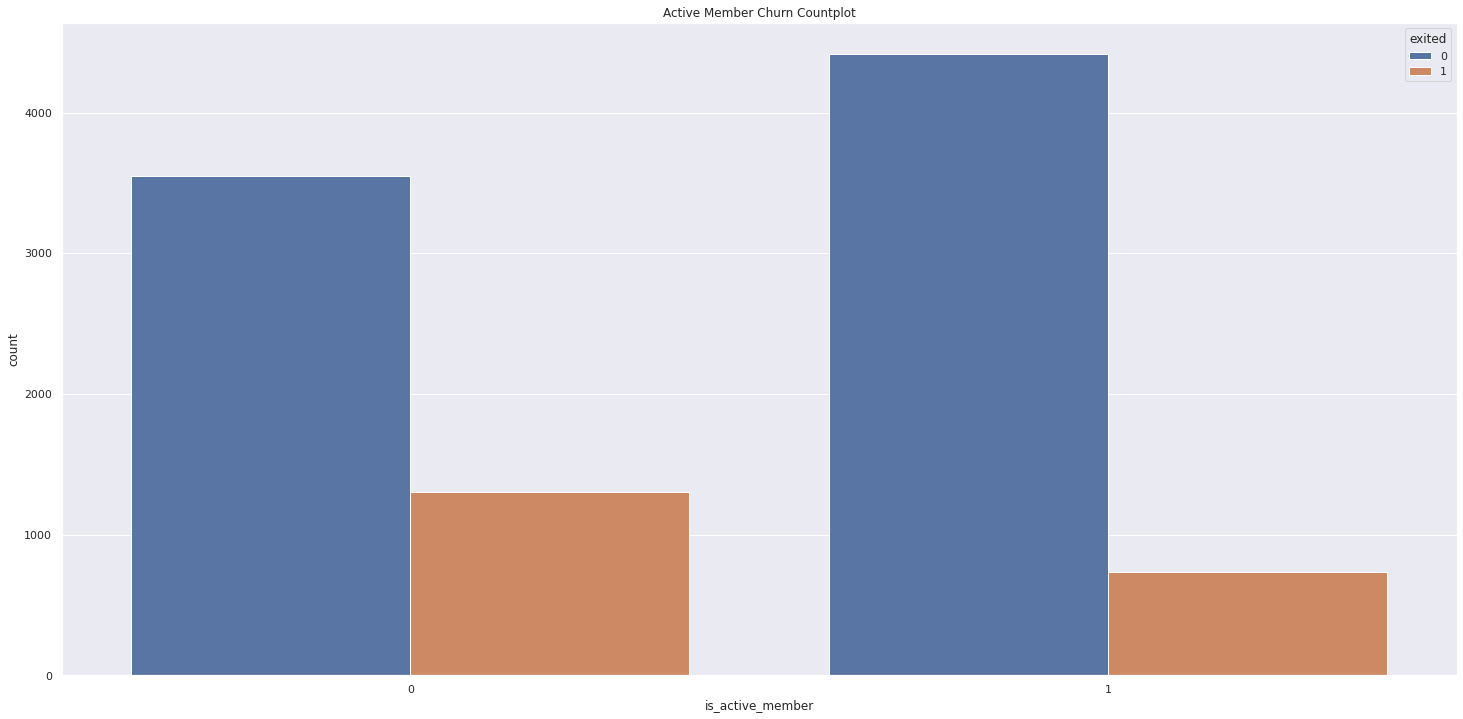

In [80]:
# plot active member by churn

sns.countplot(data = df3, x = 'is_active_member', hue = 'exited').set_title('Active Member Churn Countplot');

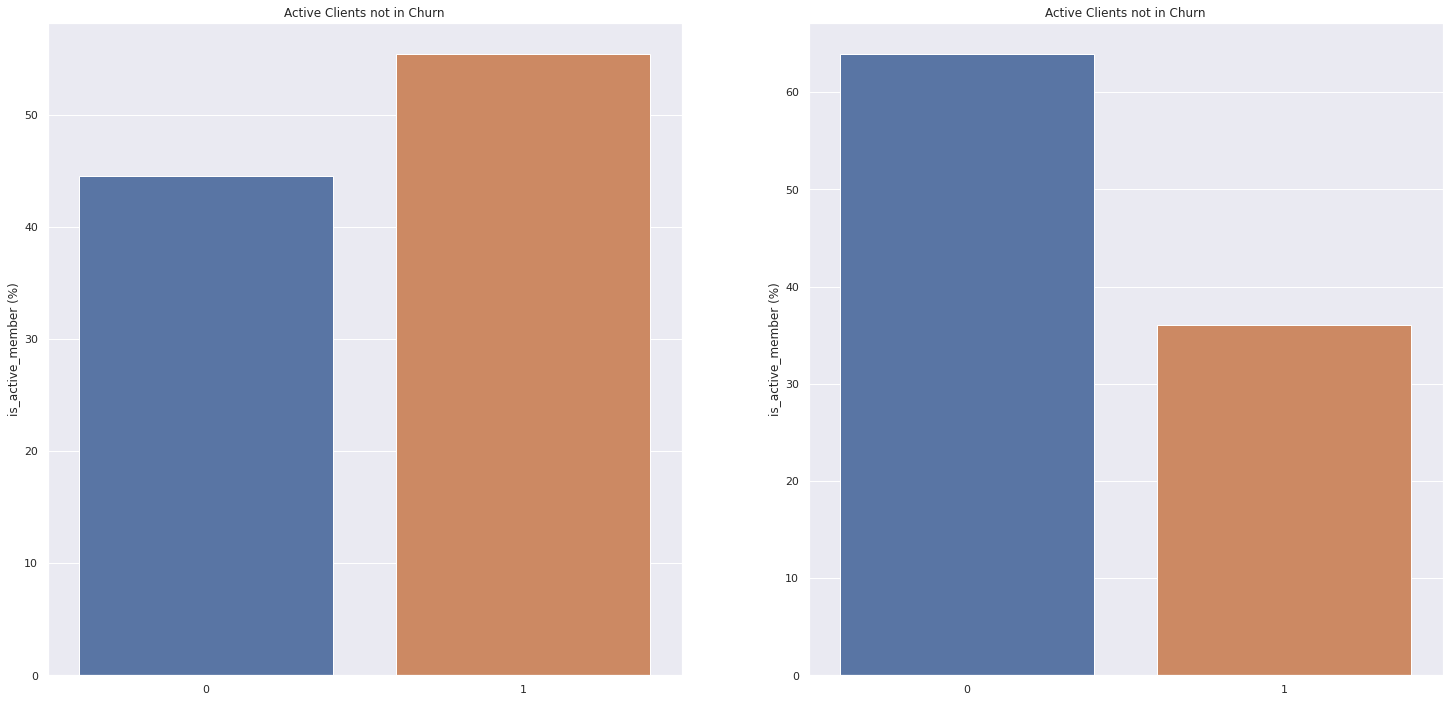

In [81]:
cred_card0 = aux_exited0['is_active_member'].value_counts(normalize = True)*100
cred_card1 = aux_exited1['is_active_member'].value_counts(normalize = True)*100


subplot(1, 2, 1)
sns.barplot(data = aux_exited0, x = cred_card0.index, y = cred_card0).set_title('Active Clients not in Churn')
plt.ylabel('is_active_member (%)')

subplot(1, 2, 2)
sns.barplot(data = aux_exited1, x = cred_card1.index, y = cred_card1).set_title('Active Clients not in Churn');
plt.ylabel('is_active_member (%)');

In [82]:
# creating realite percentage once france has more costumers than the others
aux4 =  df3[['is_active_member', 'balance','exited']].groupby(['is_active_member', 'exited']).count().reset_index()
aux4.columns = ['is_active_member', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux4.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux4.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux4['relative_percentage'] = aux4.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux4.head(10)


,is_active_member,exited,num_of_clients,relative_percentage
0,0,0,3547,44.543514
1,0,1,1302,63.917526
2,1,0,4416,55.456486
3,1,1,735,36.082474


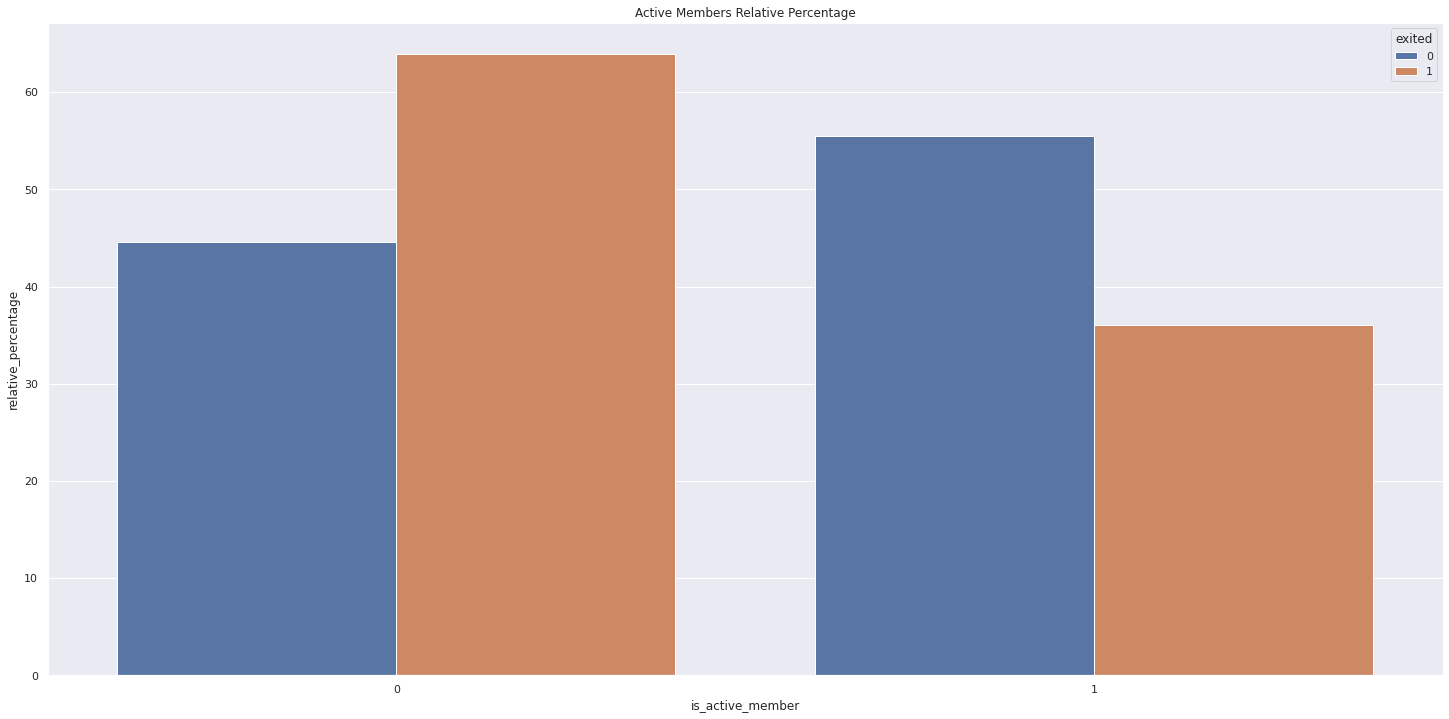

In [83]:
sns.barplot(data = aux4, x = 'is_active_member', y = 'relative_percentage', hue = 'exited').set_title('Active Members Relative Percentage');


 
- 51.5% of the clients are active members. 48.5% of the clients are not active members.
- Clients not in churn: 55.3% are active members. 44.7% are not active members.
- Clients in churn: 63.6% are not active members. 36.4% are active members, which corresponds to 594 clients, that is, even though they are active members, they decided to exit the bank.
- Therefore, the hypothesis is true: churn does not occur for active members

### H5. Younger costumers tend to churn more often
**FALSE** Clients between 30s and 50s churn more often

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


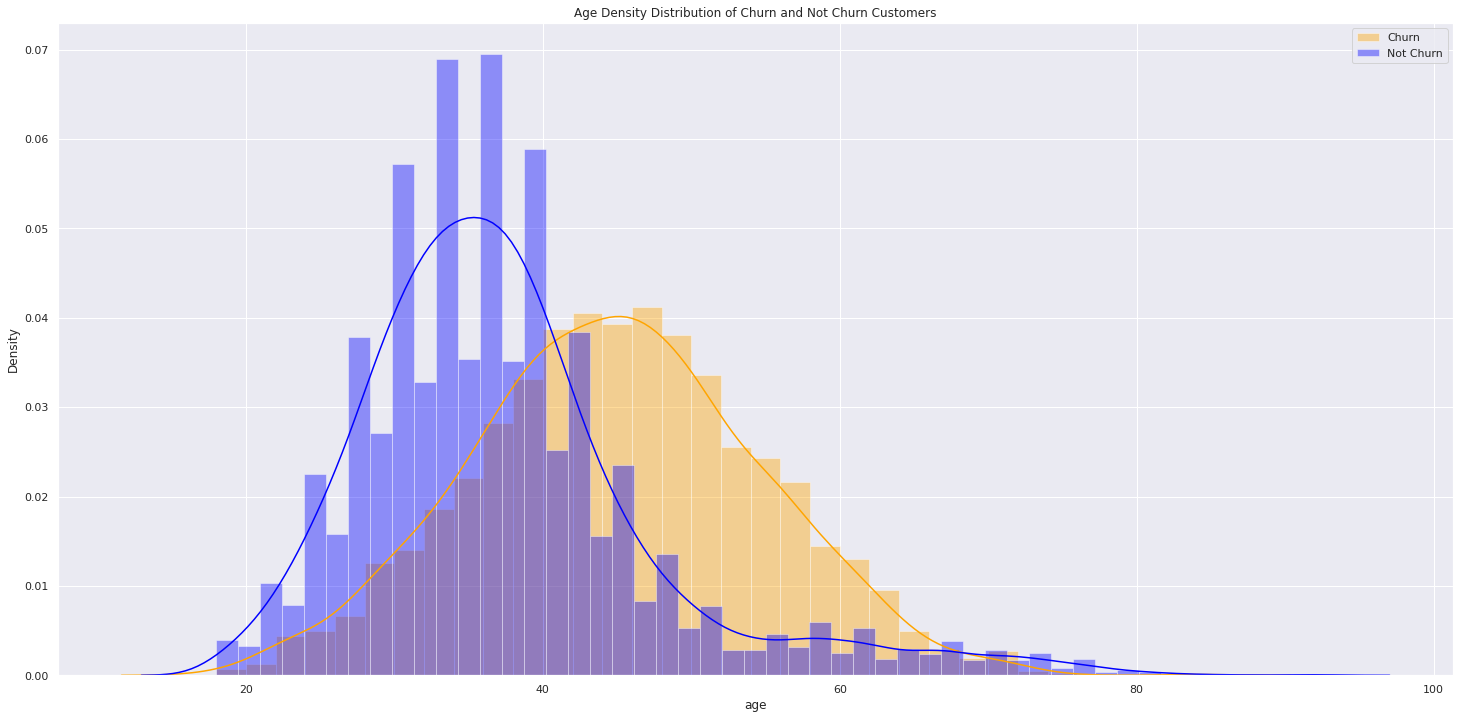

In [84]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot estimated salary density distribution for exited = 0 and 1
sns.distplot(aux_exited1['age'], color = 'orange', kde = True, label = 'Churn')
sns.distplot(aux_exited0['age'], color = 'blue', kde = True, label = 'Not Churn')
plt.title('Age Density Distribution of Churn and Not Churn Customers');
plt.legend();

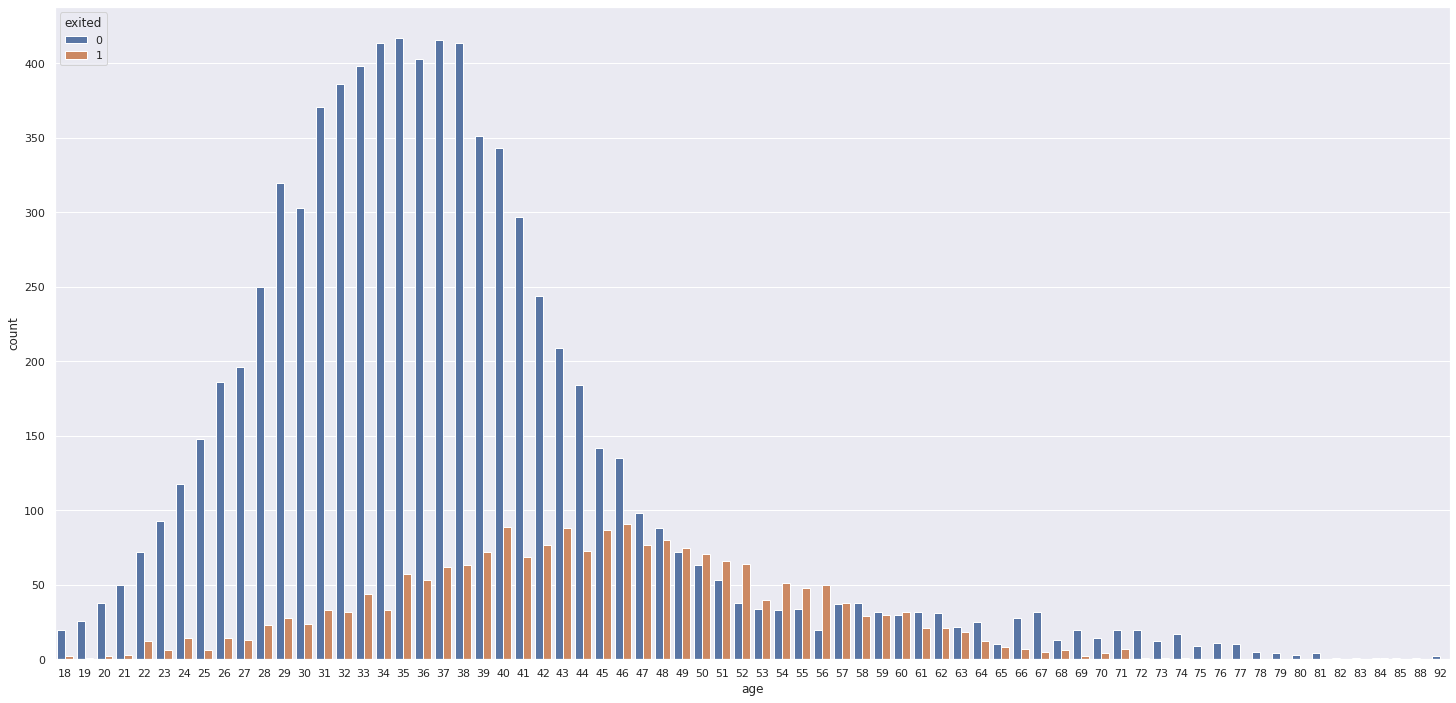

In [85]:
sns.countplot(data = df3, x = 'age', hue = 'exited');

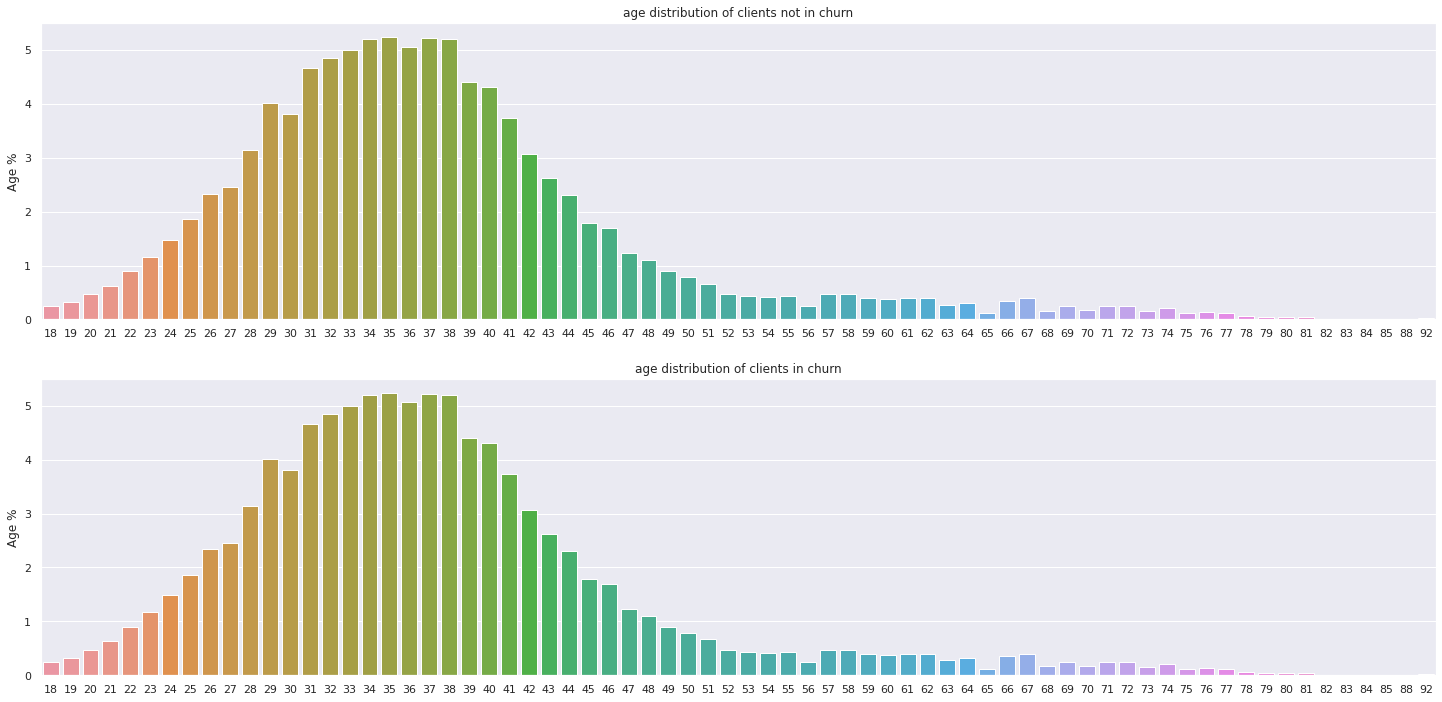

In [86]:
age_percentage0 = aux_exited0['age'].value_counts(normalize = True)*100
age_percentage1 = aux_exited1['age'].value_counts(normalize = True)*100

plt.subplot(2, 1, 1)
sns.barplot(data = aux_exited0, x = age_percentage0.index, y = age_percentage0).set_title('age distribution of clients not in churn');
plt.ylabel('Age %')

plt.subplot(2, 1, 2)
sns.barplot(data = aux_exited0, x = age_percentage0.index, y = age_percentage0).set_title('age distribution of clients in churn');
plt.ylabel('Age %');

In [87]:
# creating realite percentage once france has more costumers than the others
aux9 =  df3[['age', 'balance','exited']].groupby(['age', 'exited']).count().reset_index()
aux9.columns = ['age', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux9.loc[aux9['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux9.loc[aux9['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux9['relative_percentage'] = aux9.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux9.head(10)

,age,exited,num_of_clients,relative_percentage
0,18,0,20,0.251162
1,18,1,2,0.098184
2,19,0,26,0.326510
3,19,1,1,0.049092
4,20,0,38,0.477207
5,20,1,2,0.098184
6,21,0,50,0.627904
7,21,1,3,0.147275
8,22,0,72,0.904182
9,22,1,12,0.589102


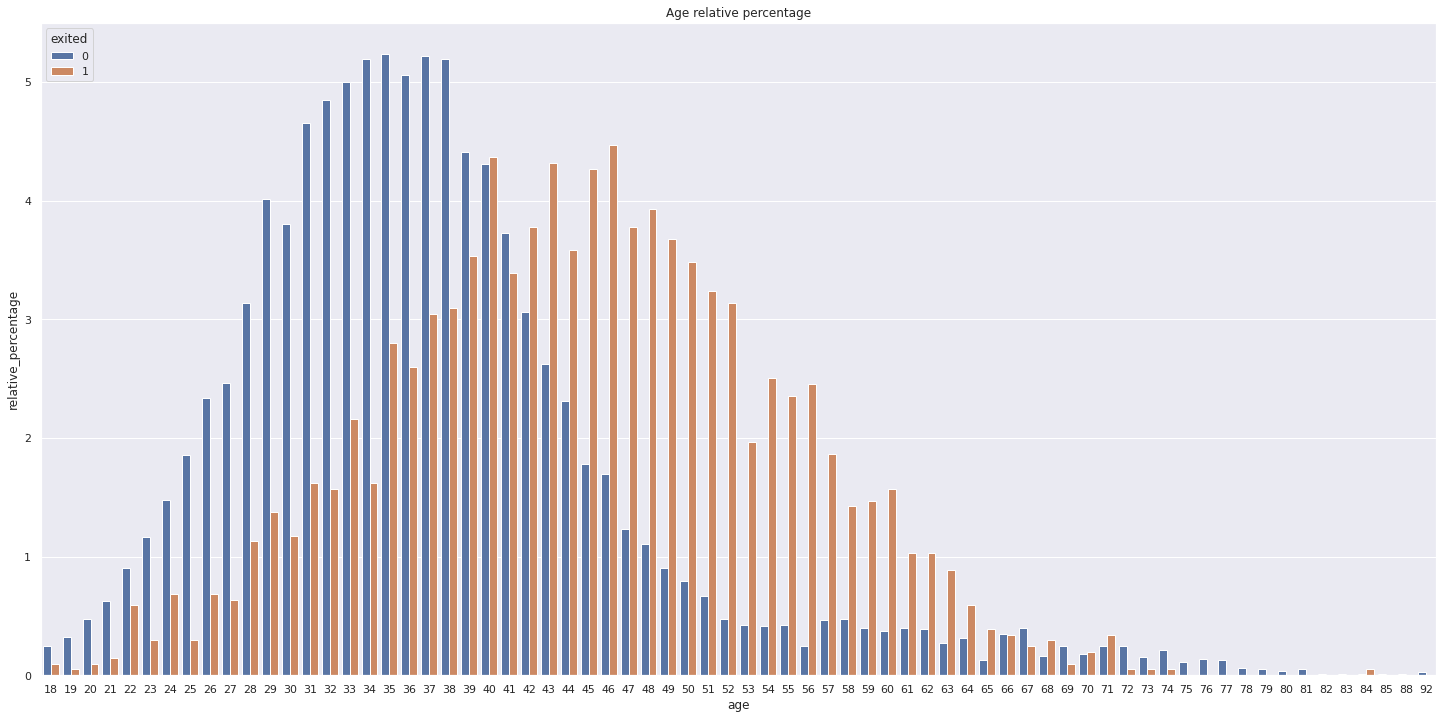

In [88]:
sns.barplot(data = aux9, x = 'age', y = 'relative_percentage', hue = 'exited').set_title('Age relative percentage');

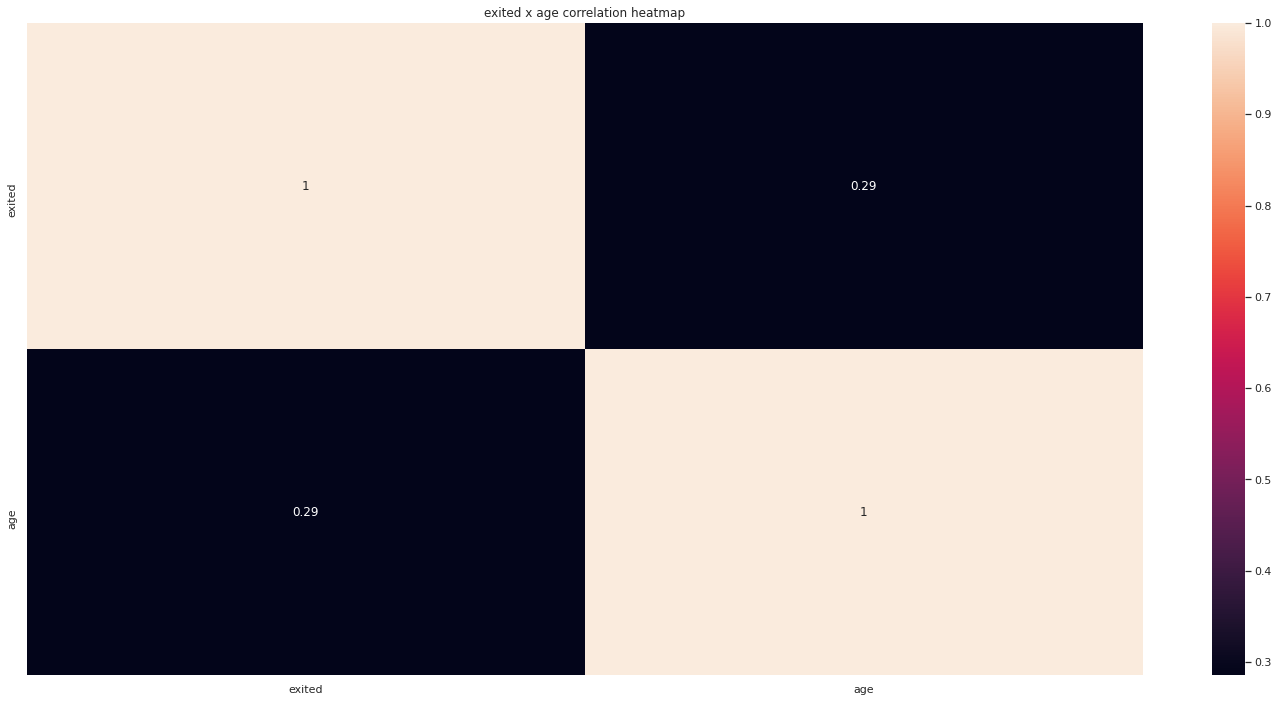

In [89]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['age']]);

In [159]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


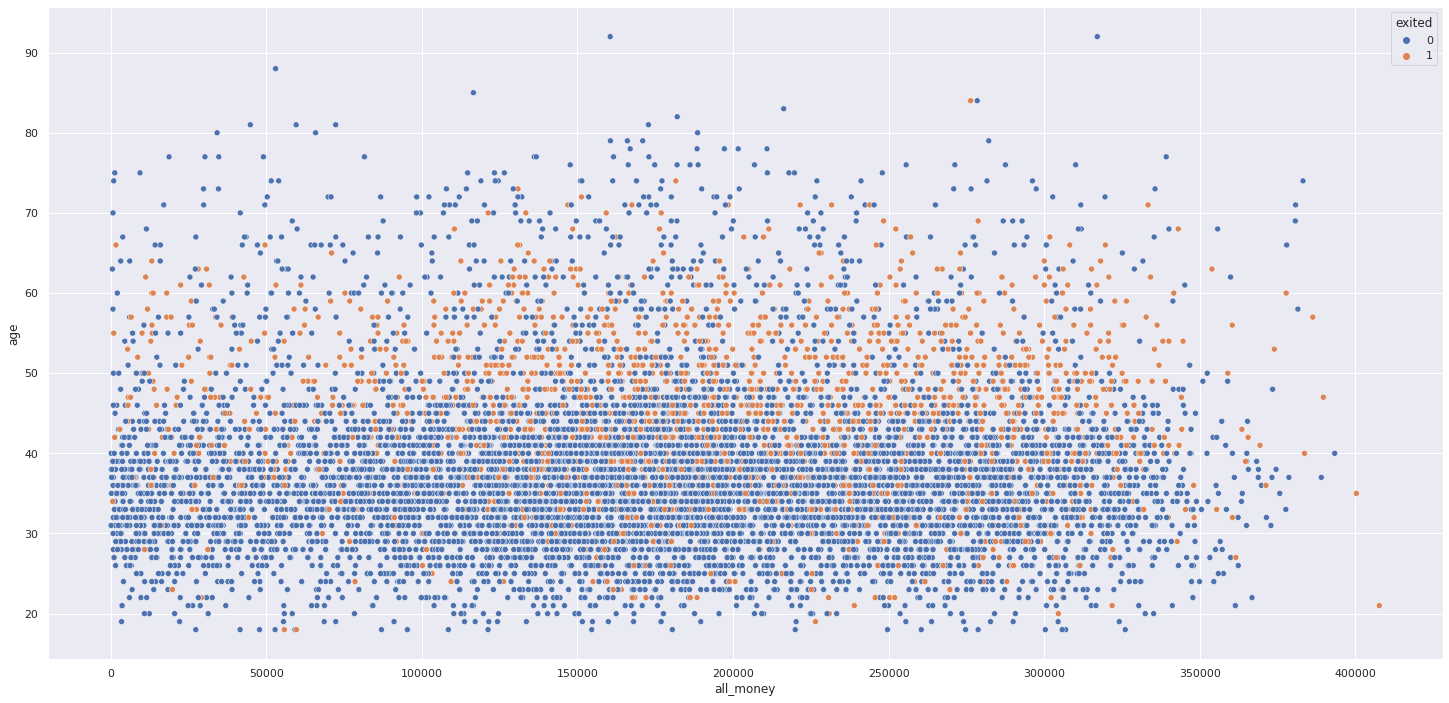

In [160]:
sns.scatterplot(data = df3, x = 'all_money', y = 'age', hue = 'exited');

In [ ]:
sns.scatterplot(data = df3, x = 'all_money', y = 'age', hue = 'exited');

- The density distribution plot shows that churn is proportionaly greater from 40 year on.
- The relative percentage barplot shows that from 40 years until 65 years, the churn ration is greater than the not churn. For all other ages, the not churn proportion is greater.
- The correlation heatmap shows a correlation coefficient of 0.28.
- Therefore, the hypothesis is False: churn rate is lower among young clients.

### H6. Customers with credit card have more probability to churn
**False** Customers with no credit card have more probability to churn

In [90]:
df3['has_cr_card'].value_counts(normalize = True)*100

1    70.55
0    29.45
Name: has_cr_card, dtype: float64

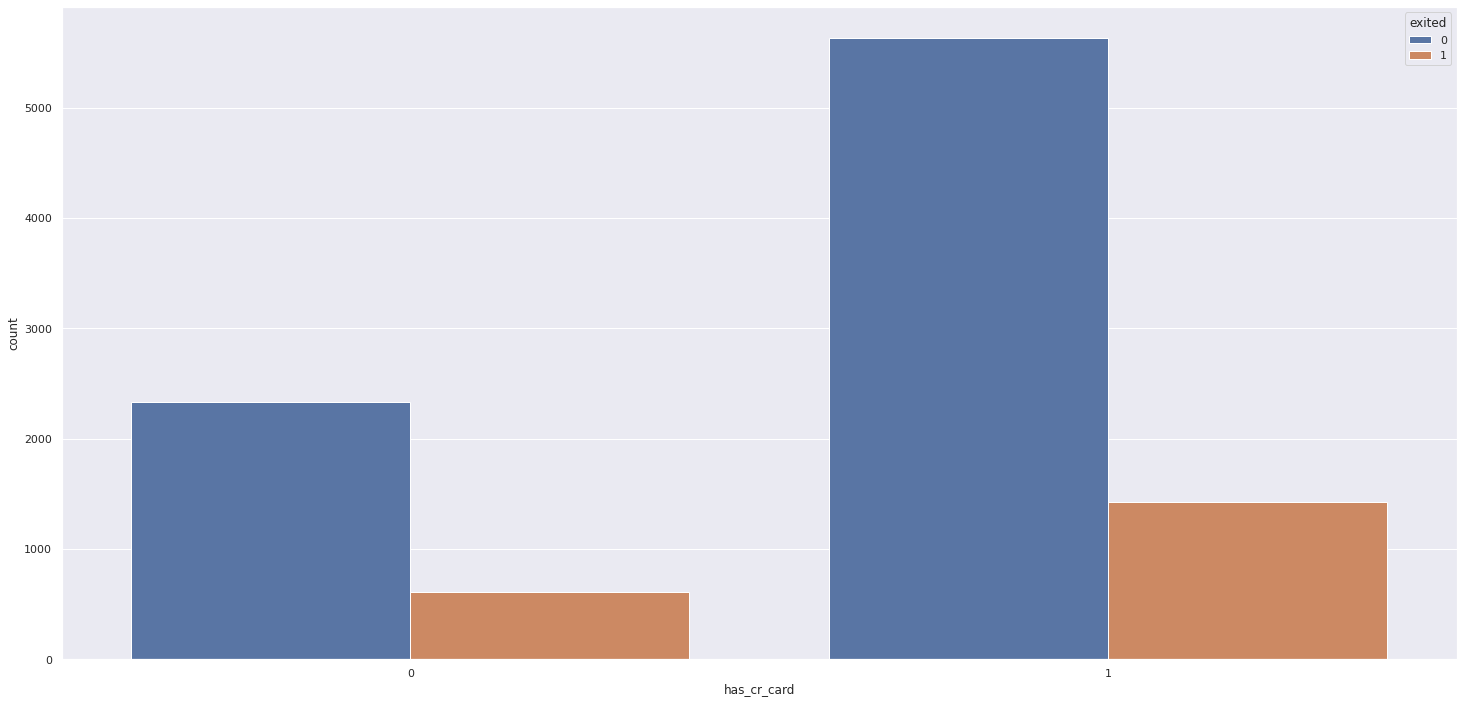

In [91]:
sns.countplot(data = df3, x = 'has_cr_card', hue = 'exited');

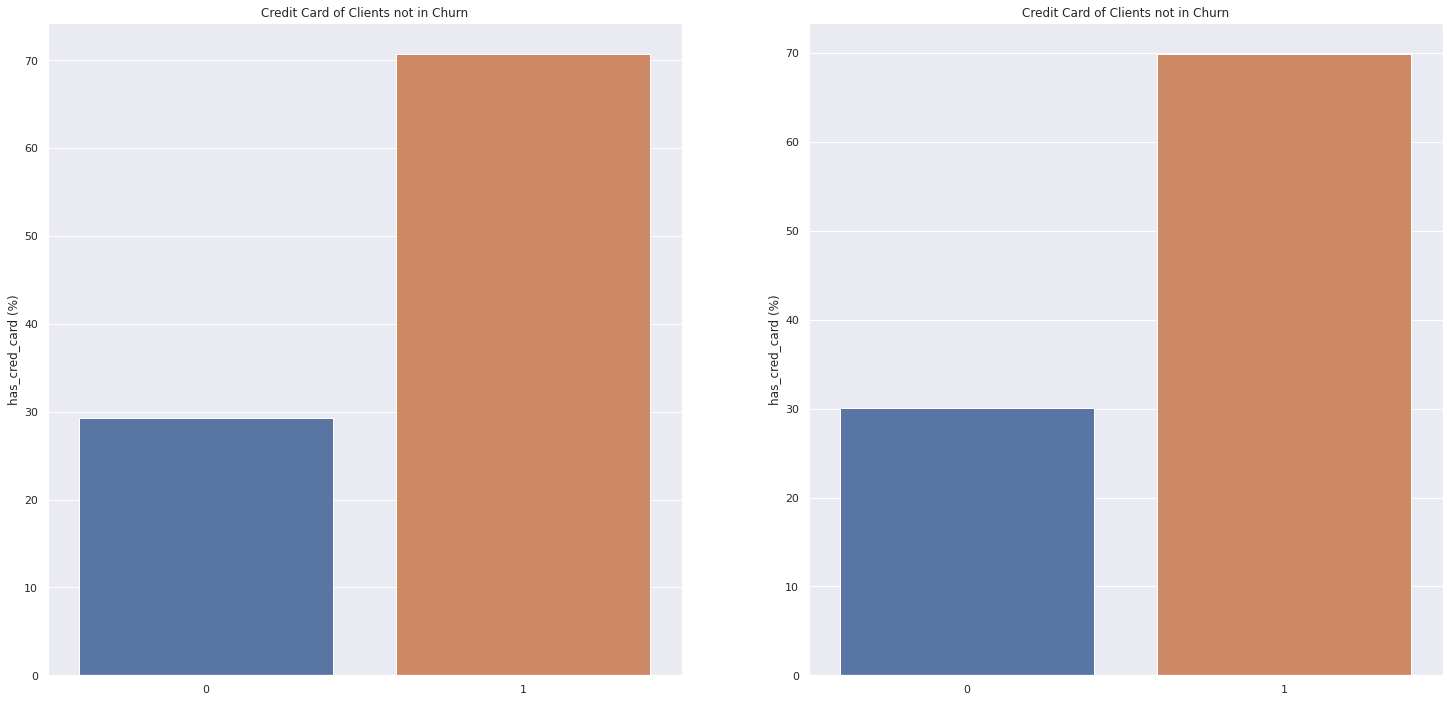

In [92]:
# credcard percentage by churn
cred_card0 = aux_exited0['has_cr_card'].value_counts(normalize = True)*100
cred_card1 = aux_exited1['has_cr_card'].value_counts(normalize = True)*100


subplot(1, 2, 1)
sns.barplot(data = aux_exited0, x = cred_card0.index, y = cred_card0).set_title('Credit Card of Clients not in Churn')
plt.ylabel('has_cred_card (%)')

subplot(1, 2, 2)
sns.barplot(data = aux_exited1, x = cred_card1.index, y = cred_card1).set_title('Credit Card of Clients not in Churn');
plt.ylabel('has_cred_card (%)');

In [93]:
# credit card relative percentage

aux5 = df3[['has_cr_card', 'exited', 'balance']].groupby(['has_cr_card', 'exited']).count().reset_index()
aux5.columns = ['has_cr_card', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux5.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux5.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux5['relative_percentage'] = aux5.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux5.head(10)

,has_cr_card,exited,num_of_clients,relative_percentage
0,0,0,2332,29.285445
1,0,1,613,30.093274
2,1,0,5631,70.714555
3,1,1,1424,69.906726


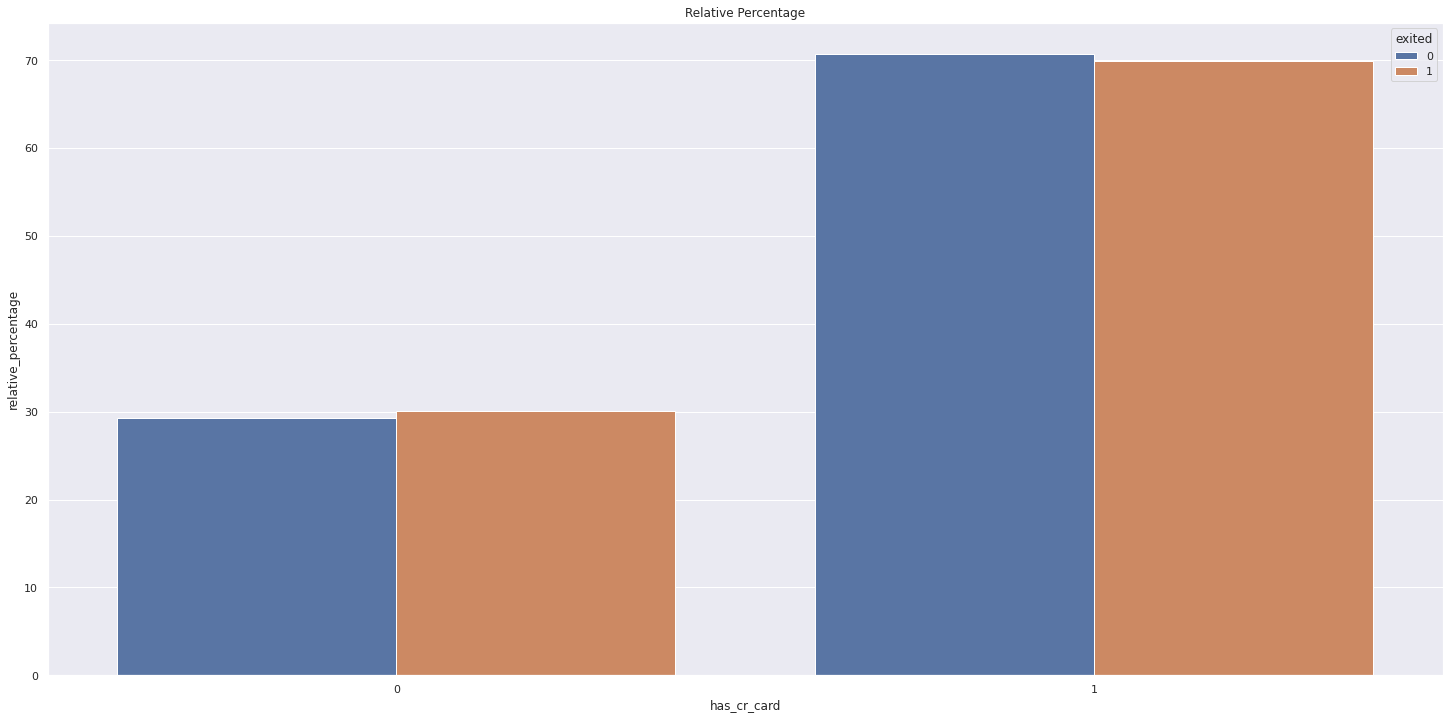

In [94]:
# plot relative percentage
sns.barplot(data = aux5, x = 'has_cr_card', y = 'relative_percentage', hue = 'exited').set_title('Relative Percentage');

- 70.9% of the customers have credit card.
- Clients not in churn: 71.2% have credit card. 28.8% have not credit card.
- Clients in churn: 69.6% have credit card. 30.4% have not credit card.
- The proportion of clients in churn without credit card (30.4%) is greater than the proportion of clients not in churn without credit card (28.8%).
- The proportion of clients not in churn with credit card (71.2%) is greater than the proportion of clients in churn with credit card (69.6%).
- Therefore, the hypothesis is True: churn does not occur for clients with credit card.

### H7. Customers with high credit scores have less probability to churn
**FALSE** Customers tend to churn more with fair score

In [95]:
# credit score
# credit scores from 580 to 669 are considered fair; 670 to 739 are considered good;
# 740 to 799 are considered very good; and 800 and up are considered excellent.
aux_cred = df3[['credit_score', 'exited']].copy()
aux_cred['credit_score_cat'] = df3['credit_score'].apply(lambda x: 'bad' if x < 580 else
                                                              'fair' if (x >= 580 ) & (x < 669) else
                                                              'good' if (x >= 699) & (x < 739) else
                                                              'very good' if (x >= 739) & (x < 799)
                                                               else 'excellent')

aux_cred = aux_cred[['credit_score', 'credit_score_cat', 'exited']]

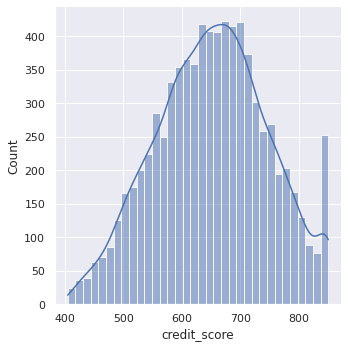

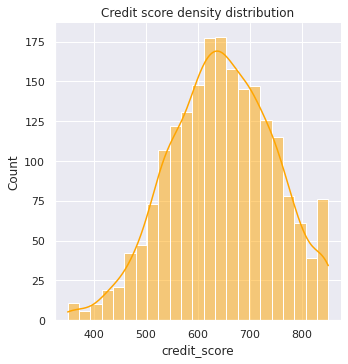

In [96]:
sns.displot(aux_exited0['credit_score'], label = 'Not Churn', kde = True, kind = 'hist');

sns.displot(aux_exited1['credit_score'], color = 'orange', label = 'Churn', kde = True);
plt.title('Credit score density distribution');

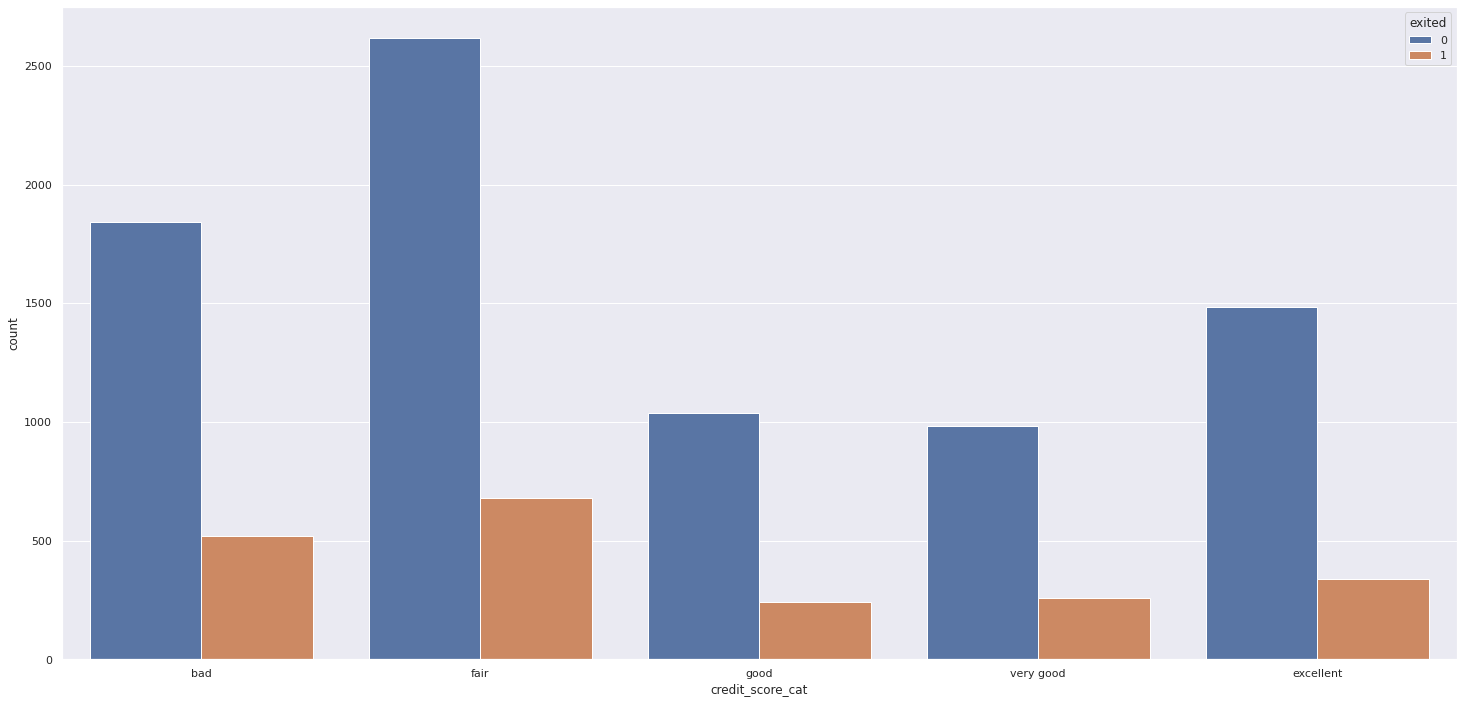

In [97]:
sns.countplot(data = aux_cred, x = 'credit_score_cat', order = ['bad', 'fair', 'good', 'very good','excellent'], hue = 'exited');

In [98]:
aux_cred.head()

,credit_score,credit_score_cat,exited
0,619,fair,1
1,608,fair,0
2,502,bad,1
3,699,good,0
4,850,excellent,0


In [99]:
# credit score relative percentage

aux6 = aux_cred[['credit_score', 'exited', 'credit_score_cat']].groupby(['credit_score_cat', 'exited']).count().reset_index()
aux6.columns = ['credit_score_cat', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux6.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux6.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux6['relative_percentage'] = aux6.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux6.head(10)

,credit_score_cat,exited,num_of_clients,relative_percentage
0,bad,0,1842,23.131985
1,bad,1,520,25.527737
2,excellent,0,1483,18.623634
3,excellent,1,339,16.642121
4,fair,0,2617,32.864498
5,fair,1,678,33.284242
6,good,0,1039,13.047846
7,good,1,243,11.929308
8,very good,0,982,12.332036
9,very good,1,257,12.616593


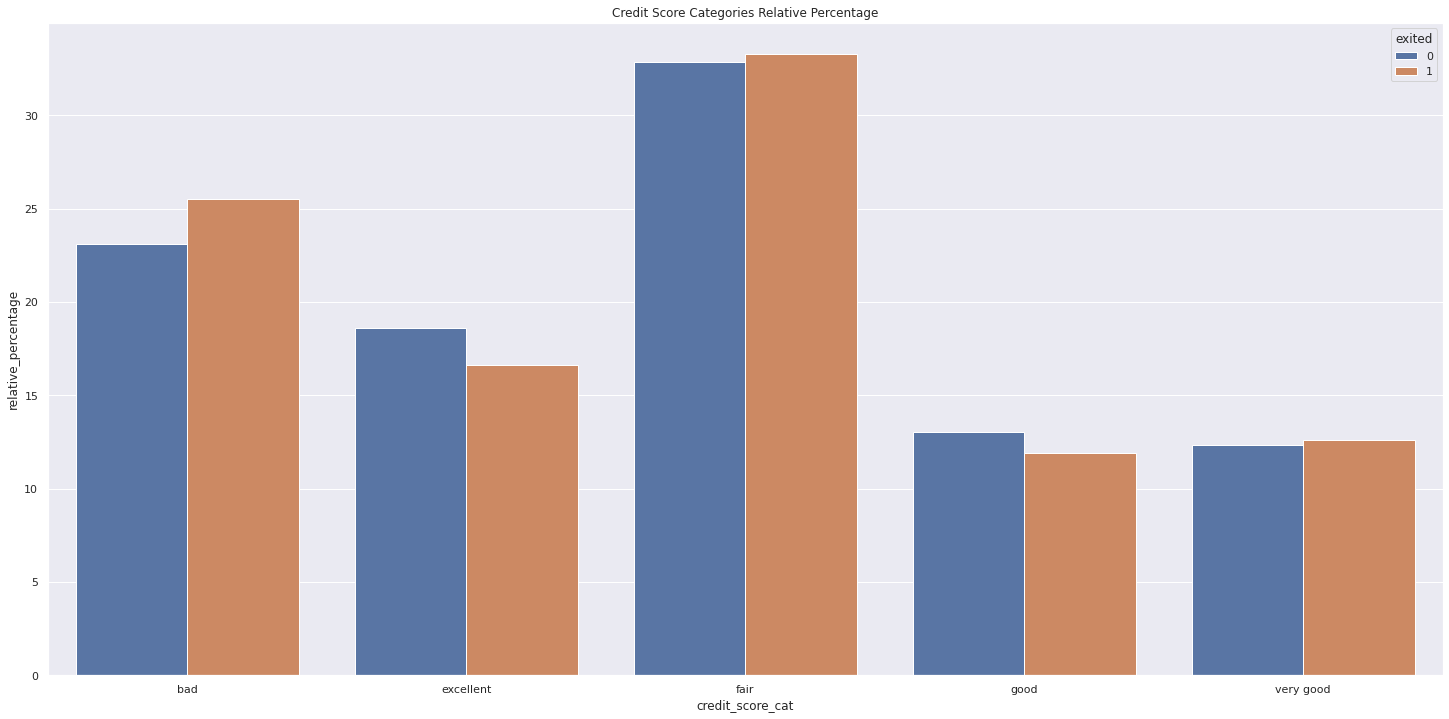

In [100]:
#Plot the relative percentage of clients in churn and not in churn per credit score.
sns.barplot(data = aux6, x = 'credit_score_cat', y = 'relative_percentage', hue = 'exited').set_title("Credit Score Categories Relative Percentage");

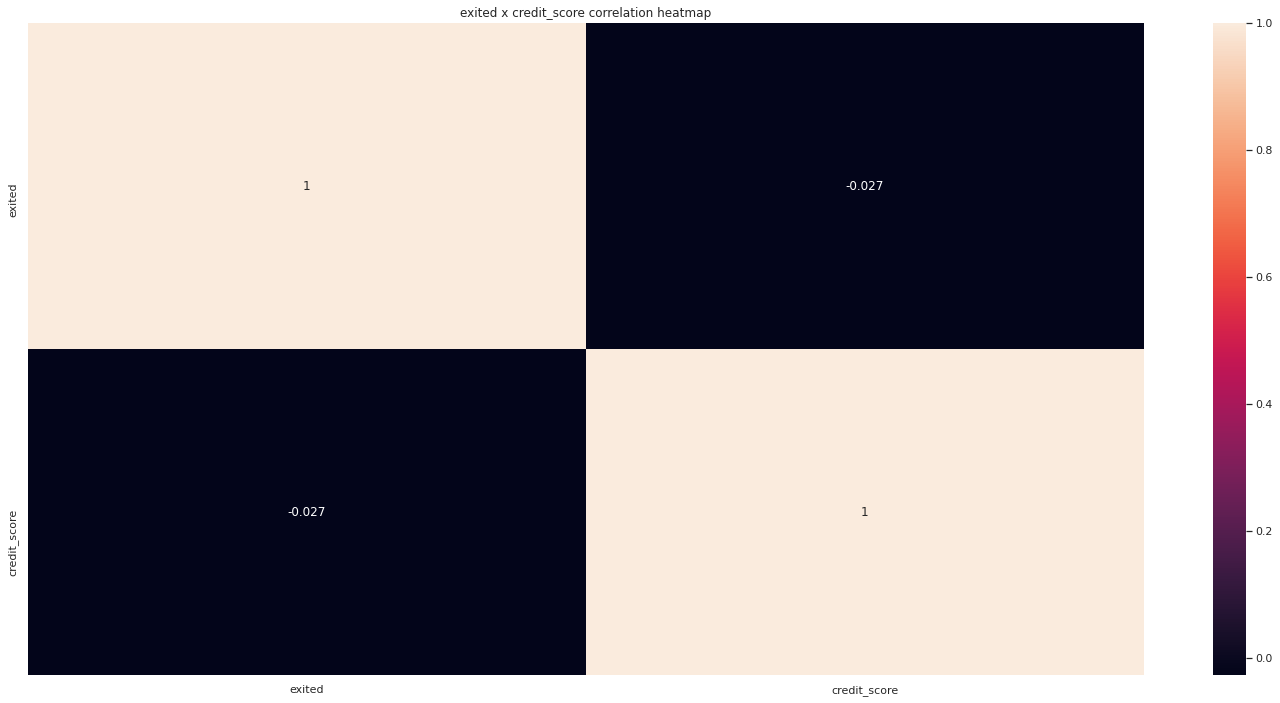

In [101]:
 # point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df3[['exited']], df3[['credit_score']]);

### H8. Customers with less products tend to churn more
**True** 


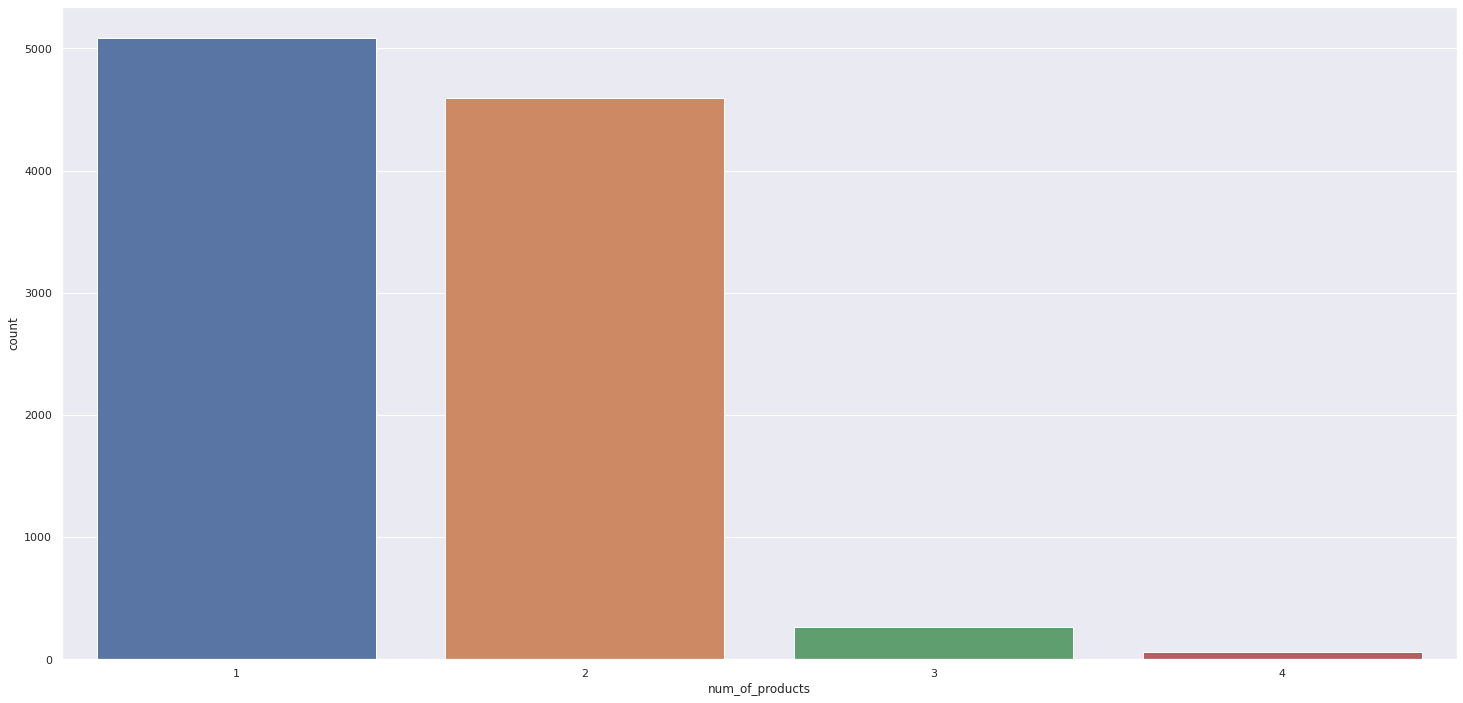

In [102]:
# number of products countplot

sns.countplot(data = df3, x = 'num_of_products');

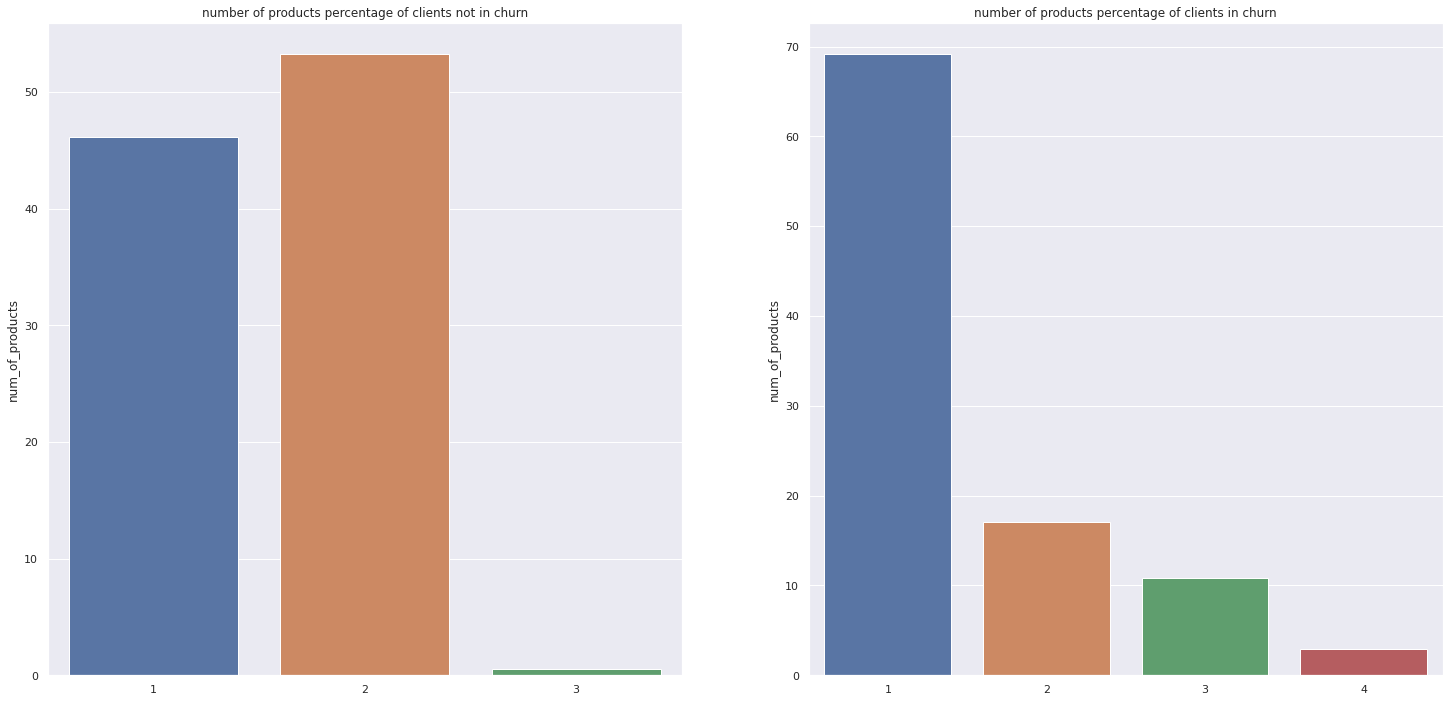

In [103]:
# number of products countplot
aux0 = df3[df3['exited'] == 0]
aux1 = df3[df3['exited'] == 1]

product_churn0 = aux0['num_of_products'].value_counts(normalize = True)*100
product_churn1 = aux1['num_of_products'].value_counts(normalize = True)*100

subplot(1, 2, 1)
sns.barplot(data = aux0, x = product_churn0.index ,y = product_churn0).set_title('number of products percentage of clients not in churn');

subplot(1, 2, 2)
sns.barplot(data = aux1, x = product_churn1.index ,y = product_churn1).set_title('number of products percentage of clients in churn');

In [104]:
product_churn0

2    53.271380
1    46.150948
3     0.577672
Name: num_of_products, dtype: float64

In [105]:
product_churn1

1    69.170349
2    17.083947
3    10.800196
4     2.945508
Name: num_of_products, dtype: float64

In [106]:
df3['num_of_products'].value_counts(normalize = True)*100

1    50.84
2    45.90
3     2.66
4     0.60
Name: num_of_products, dtype: float64

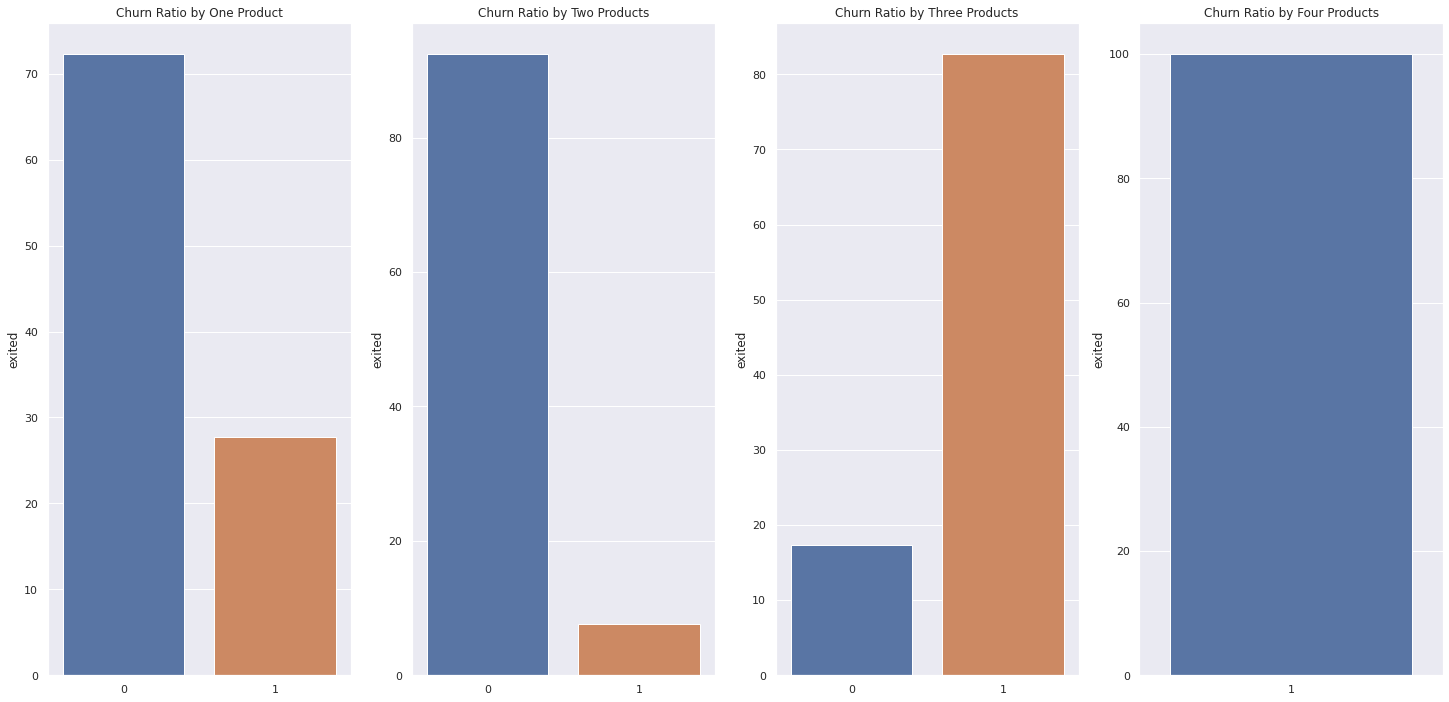

In [107]:
plt.subplot(1, 4, 1)
aux3 = df3[df3['num_of_products']==1]
churn_prod_1 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_1.index, y = churn_prod_1)
# plt.xlabel(['Not Churn', 'Churn'])
plt.title('Churn Ratio by One Product')

plt.subplot(1, 4, 2)
aux3 = df3[df3['num_of_products']==2]
churn_prod_2 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_2.index, y = churn_prod_2)
plt.title('Churn Ratio by Two Products')

plt.subplot(1, 4, 3)
aux3 = df3[df3['num_of_products']==3]
churn_prod_3 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_3.index, y = churn_prod_3)
plt.title('Churn Ratio by Three Products')

plt.subplot(1, 4, 4)
aux3 = df3[df3['num_of_products']==4]
churn_prod_4 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_4.index, y = churn_prod_4);
plt.title('Churn Ratio by Four Products');

In [108]:
# number of products relative percentage

aux7 = df3[['num_of_products', 'exited', 'balance']].groupby(['num_of_products', 'exited']).count().reset_index()
aux7.columns = ['num_of_products', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux7.loc[aux7['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux7.loc[aux7['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux7['relative_percentage'] = aux7.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux7.head(10)

,num_of_products,exited,num_of_clients,relative_percentage
0,1,0,3675,46.150948
1,1,1,1409,69.170349
2,2,0,4242,53.271380
3,2,1,348,17.083947
4,3,0,46,0.577672
5,3,1,220,10.800196
6,4,1,60,2.945508


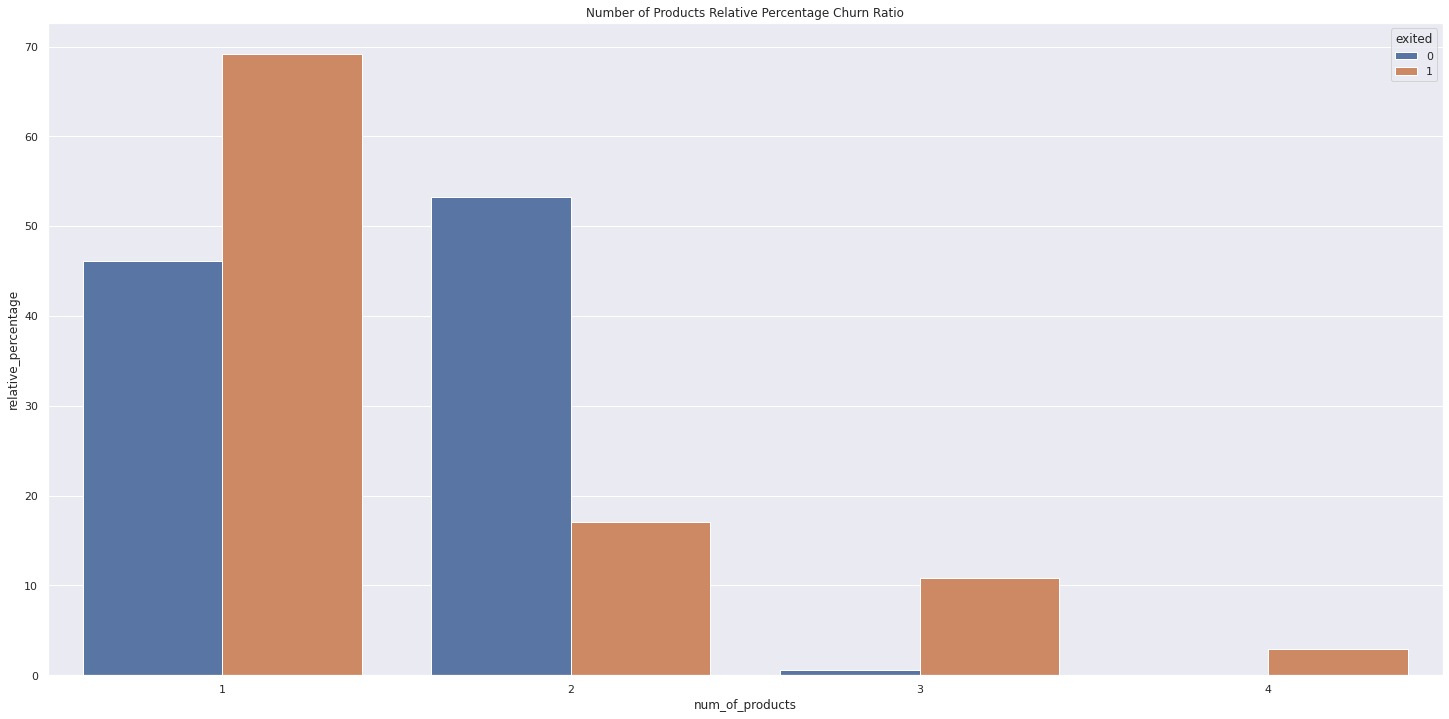

In [109]:
sns.barplot(data = aux7, x = 'num_of_products', y = 'relative_percentage', hue = 'exited').set_title('Number of Products Relative Percentage Churn Ratio');

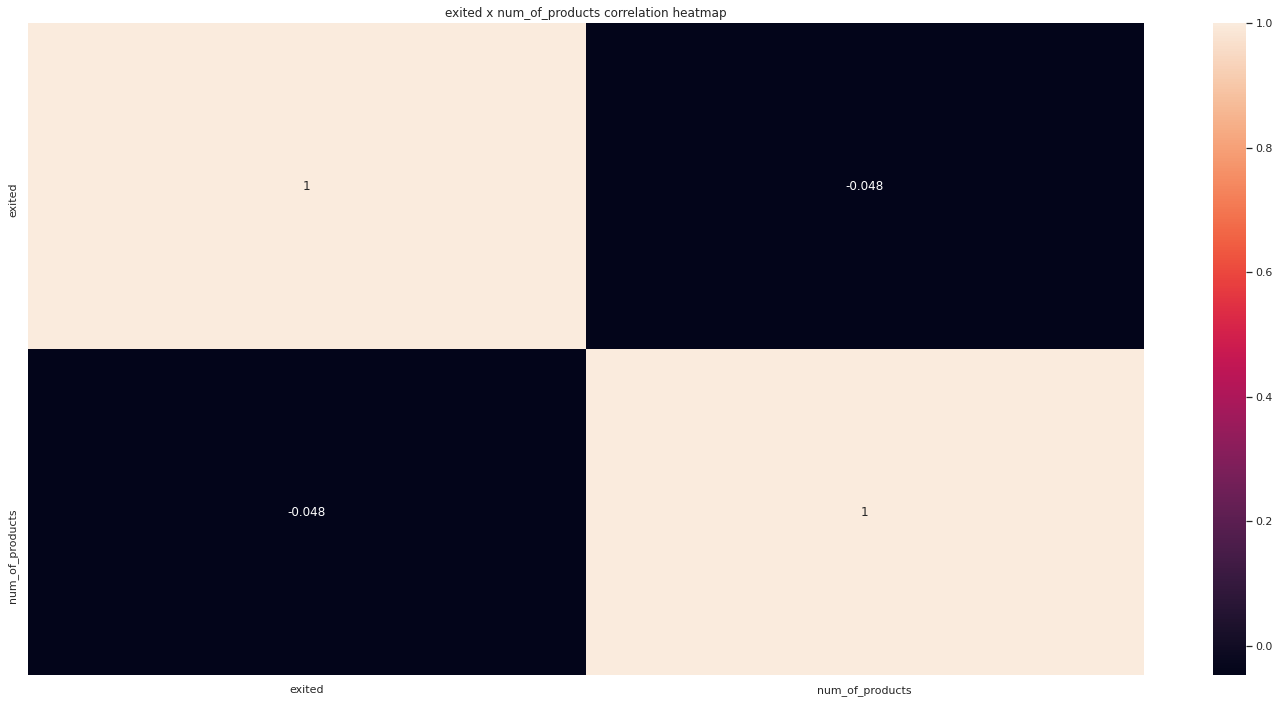

In [110]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['num_of_products']]);

In [111]:
aux3 = df3[df3['num_of_products']==1]
churn_prod_1 = aux3['exited'].value_counts(normalize=True)*100

In [112]:
aux3 = df3[df3['num_of_products']==2]
churn_prod_2 = aux3['exited'].value_counts(normalize=True)*100

In [113]:
aux3 = df3[df3['num_of_products']==3]
churn_prod_3 = aux3['exited'].value_counts(normalize=True)*100

In [114]:
aux3 = df3[df3['num_of_products']==4]
churn_prod_4 = aux3['exited'].value_counts(normalize=True)*100

### H9. Womans tend to churn more often than mens
**True**

In [115]:
df3['gender'].value_counts(normalize = True)*100

Male      54.57
Female    45.43
Name: gender, dtype: float64

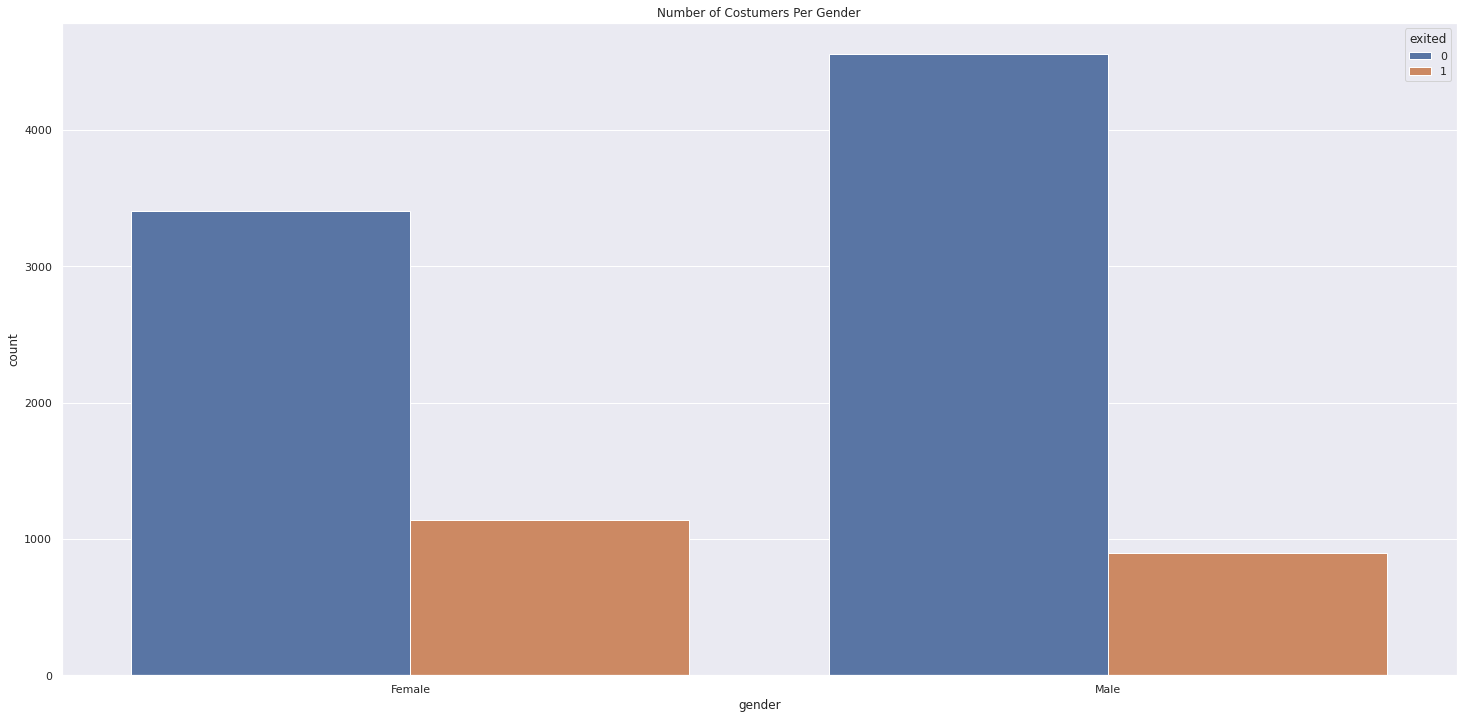

In [116]:
# countplot gender
sns.countplot(data = df3, x = 'gender', hue = 'exited').set_title('Number of Costumers Per Gender');

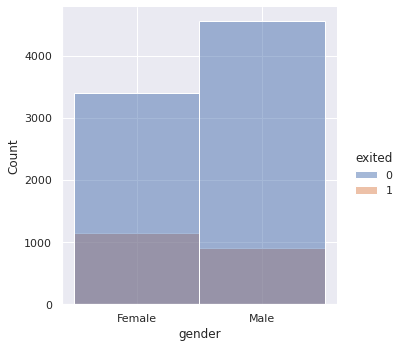

In [117]:
# gender distribution by churn
sns.displot(data = df3, x = 'gender', hue = 'exited', hue_order = [0,1], color = 'orange');

In [118]:
df3['gender'].value_counts(normalize = True)*100

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [119]:
g_percentage_0 = aux_exited0['gender'].value_counts(normalize = True)*100
g_percentage_0

Male      57.252292
Female    42.747708
Name: gender, dtype: float64

In [120]:
g_percentage_1 = aux_exited1['gender'].value_counts(normalize = True)*100
g_percentage_1

Female    55.915562
Male      44.084438
Name: gender, dtype: float64

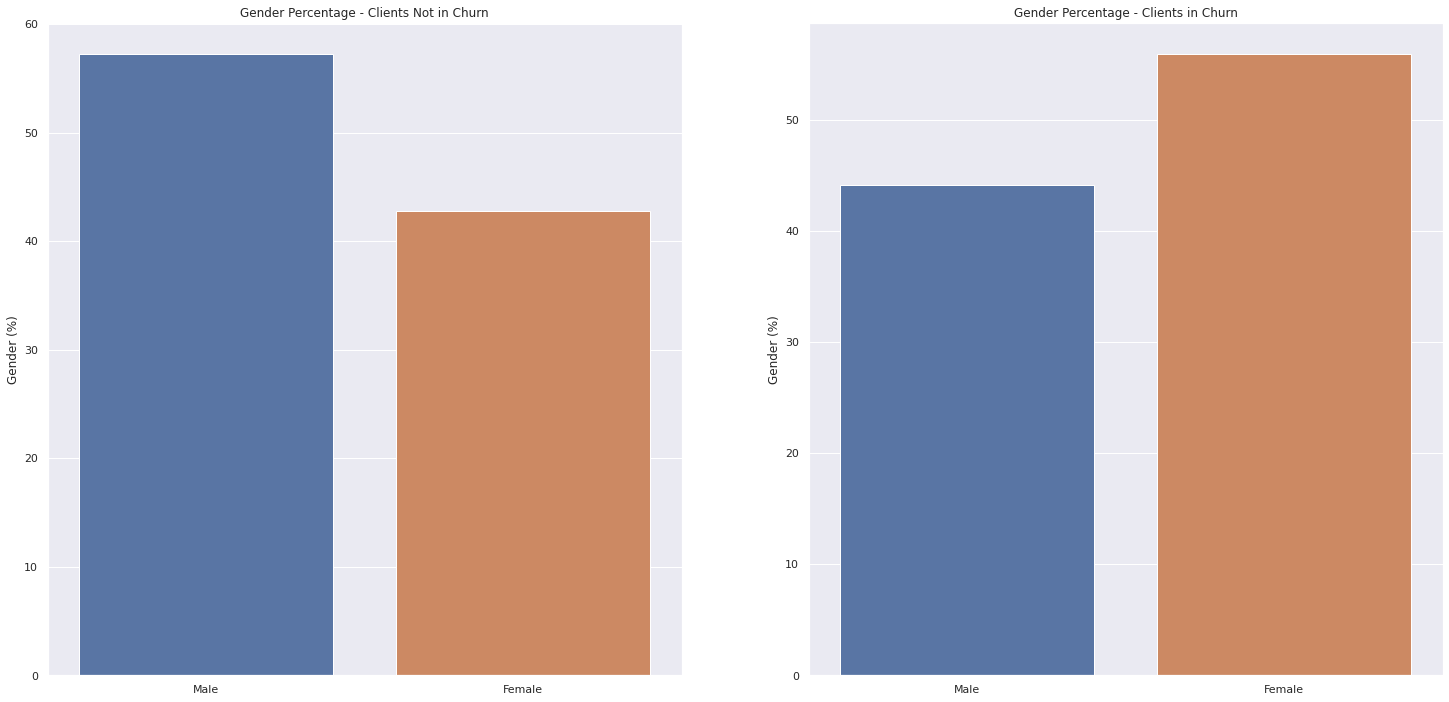

In [121]:
subplot(1, 2, 1)
sns.barplot(x = g_percentage_0.index ,y = g_percentage_0).set_title('Gender Percentage - Clients Not in Churn')
plt.ylabel('Gender (%)');

subplot(1, 2, 2)
sns.barplot(x = g_percentage_1.index ,y = g_percentage_1, order = ['Male', 'Female']).set_title('Gender Percentage - Clients in Churn')
plt.ylabel('Gender (%)');

Parafrasear
- As previously checked, 4387 clients (54.8%) are men and 3613 clients (45.2%) are women.
- For clients not in churn, 57.5% are men and 42.5% are women: the proportion of men is greater than the proportion considering the whole dataset (54.8%).
- For clients in churn, 55.6% are women and 44.4% are men: the proportion is inverse compared to the whole dataset and for client not in churn, as for both of them the proportion of men is greater than the proportion of women.
- Therefore, the hypothesis is true: churn occur more for women than men.

In [122]:
# churn by age

### H10. Customer with higher tenure tend to have a lower churn rate
**FALSE**

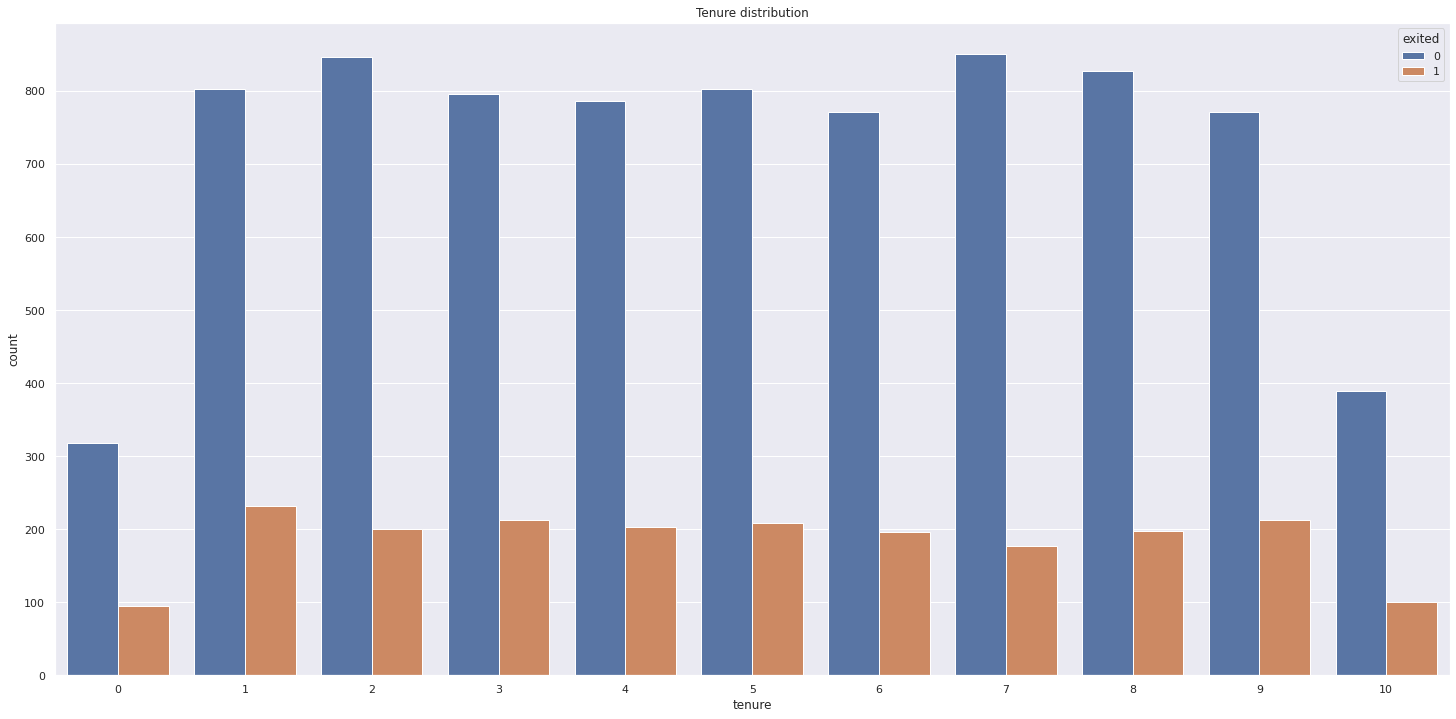

In [123]:
# churn by tenure

sns.countplot(data = df3, x = 'tenure', hue = 'exited').set_title('Tenure distribution');

In [124]:
aux_exited0.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860,196350.44,322.944803
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000,93826.63,134.229800
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820,204594.92,240.699906
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,8,6.250000,12.241849,201.256000,1257.850000,0.000000,0.000,10062.80,12.241849
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,5,8.800000,149.581836,1703.193182,14988.100000,3228.433409,71025.535,216991.57,433.116906


/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


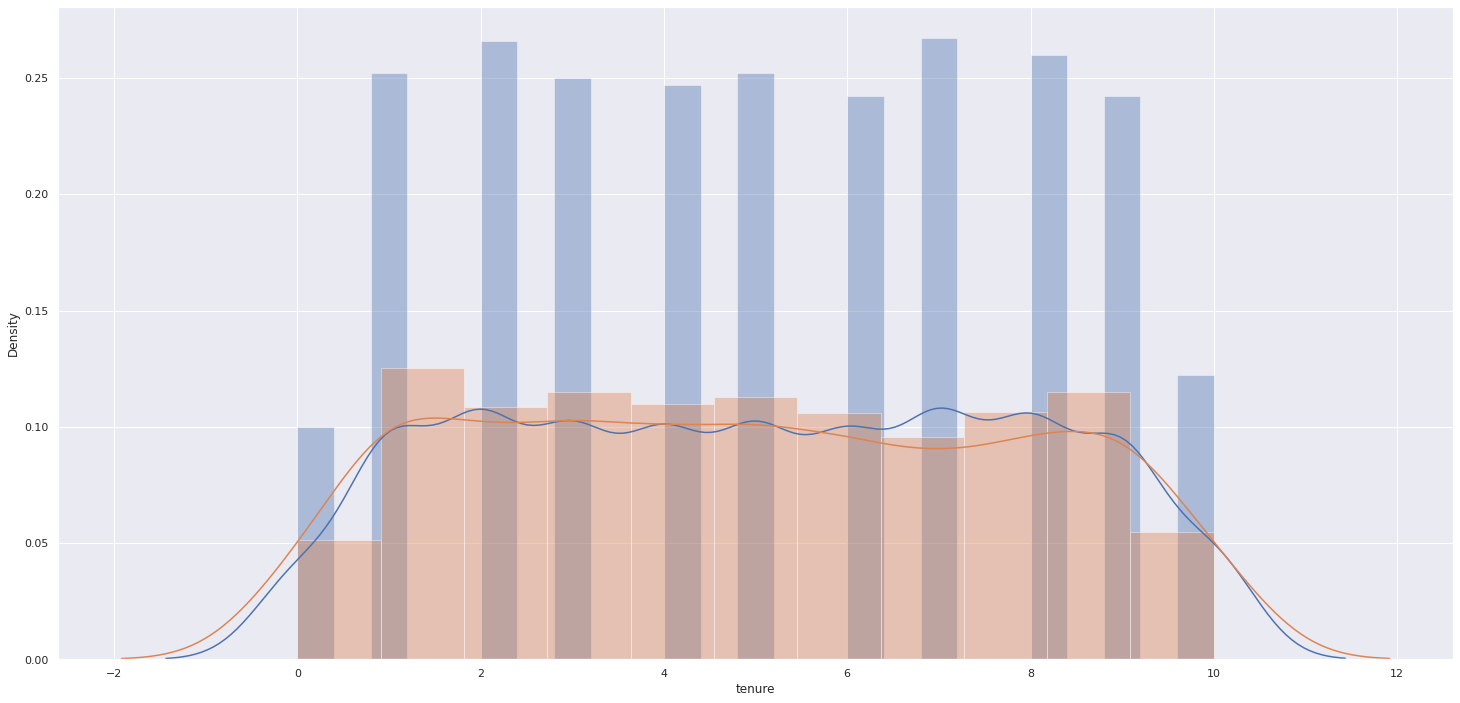

In [125]:
sns.distplot(aux_exited0['tenure'], label = 'Not Churn');
sns.distplot(aux_exited1['tenure'], label = 'Churn');

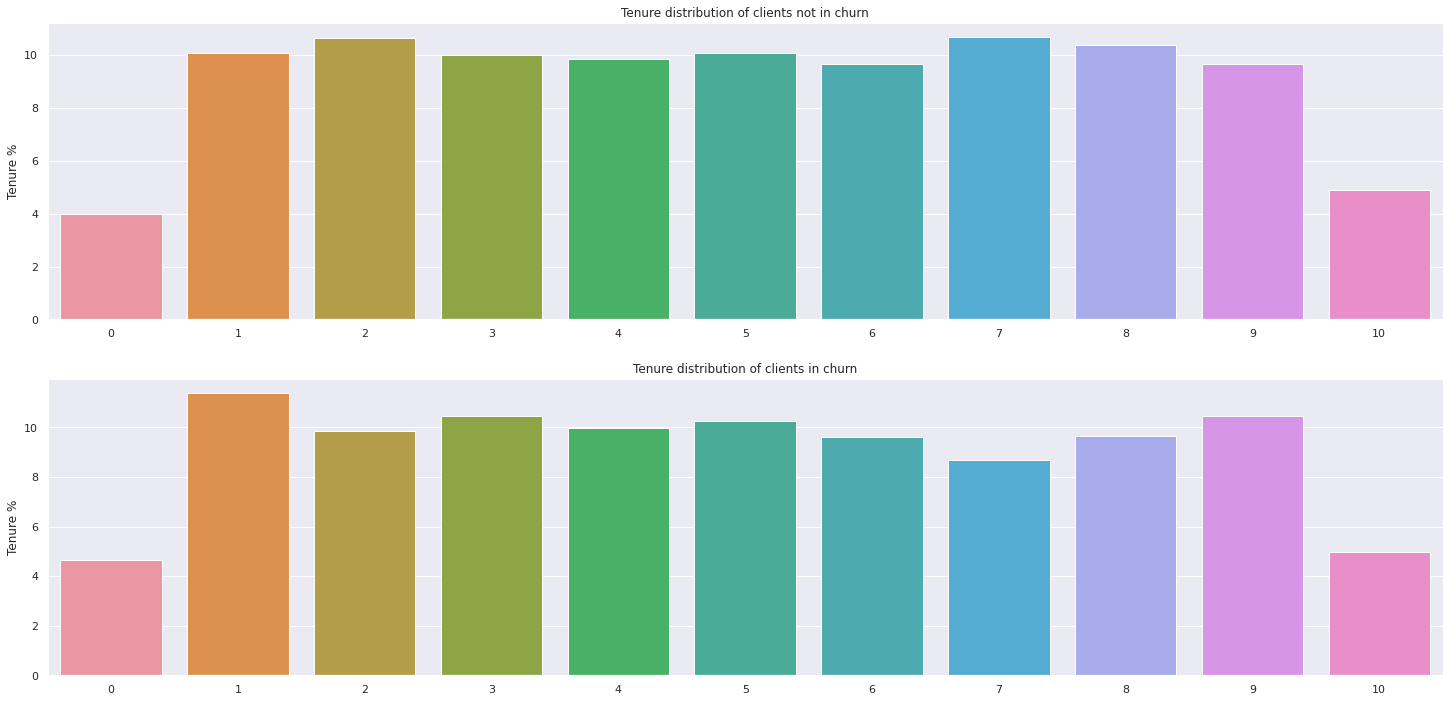

In [126]:
tenure_percentage0 = aux_exited0['tenure'].value_counts(normalize = True)*100
tenure_percentage1 = aux_exited1['tenure'].value_counts(normalize = True)*100

plt.subplot(2, 1, 1)
sns.barplot(data = aux_exited0, x = tenure_percentage0.index, y = tenure_percentage0).set_title('Tenure distribution of clients not in churn');
plt.ylabel('Tenure %')

plt.subplot(2, 1, 2)
sns.barplot(data = aux_exited0, x = tenure_percentage1.index, y = tenure_percentage1).set_title('Tenure distribution of clients in churn');
plt.ylabel('Tenure %');

In [127]:
# creating relatite percentage
aux10 =  df3[['tenure', 'balance','exited']].groupby(['tenure', 'exited']).count().reset_index()
aux10.columns = ['tenure', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux10.loc[aux9['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux10.loc[aux9['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux10['relative_percentage'] = aux10.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux10.head(10)

,tenure,exited,num_of_clients,relative_percentage
0,0,0,318,3.993470
1,0,1,95,4.663721
2,1,0,803,10.084139
3,1,1,232,11.389298
4,2,0,847,10.636695
5,2,1,201,9.867452
6,3,0,796,9.996233
7,3,1,213,10.456554
8,4,0,786,9.870652
9,4,1,203,9.965636


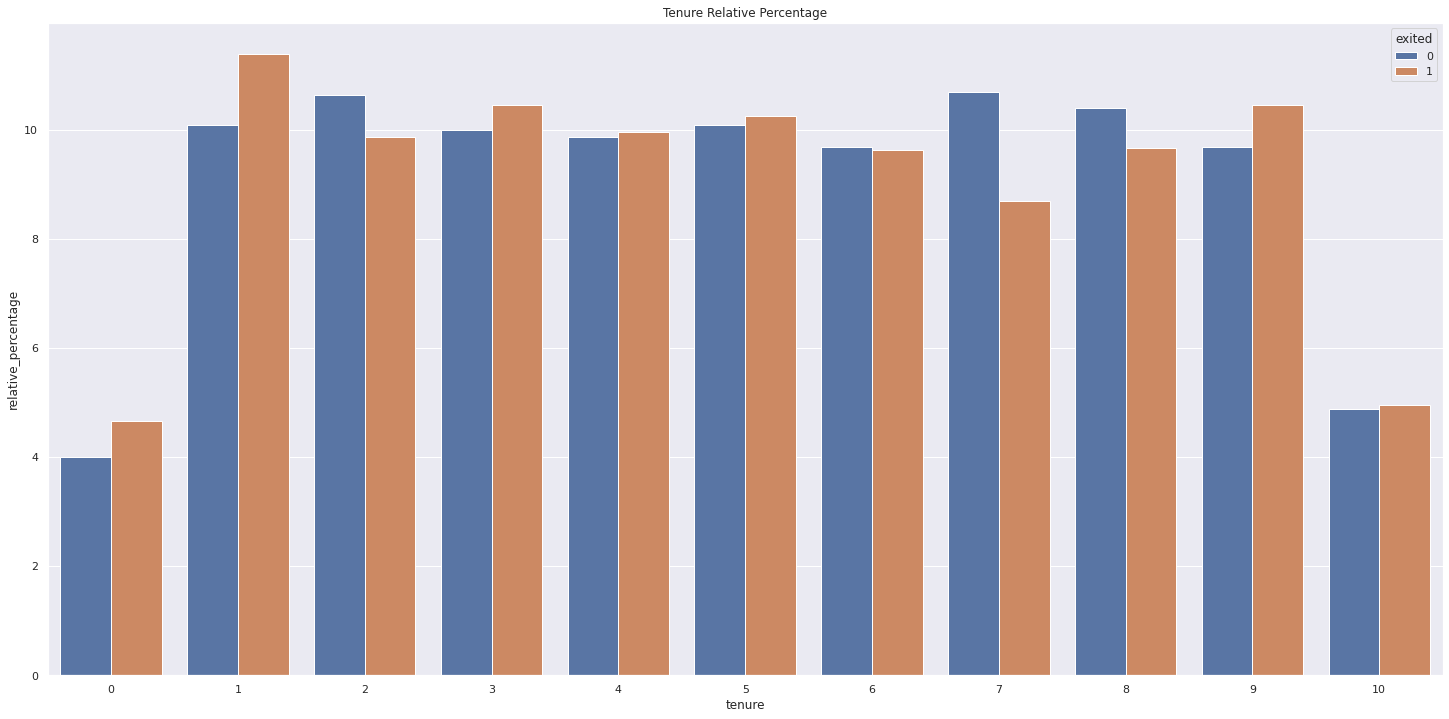

In [128]:
sns.barplot(data = aux10, x = 'tenure', y = 'relative_percentage', hue = 'exited').set_title('Tenure Relative Percentage');

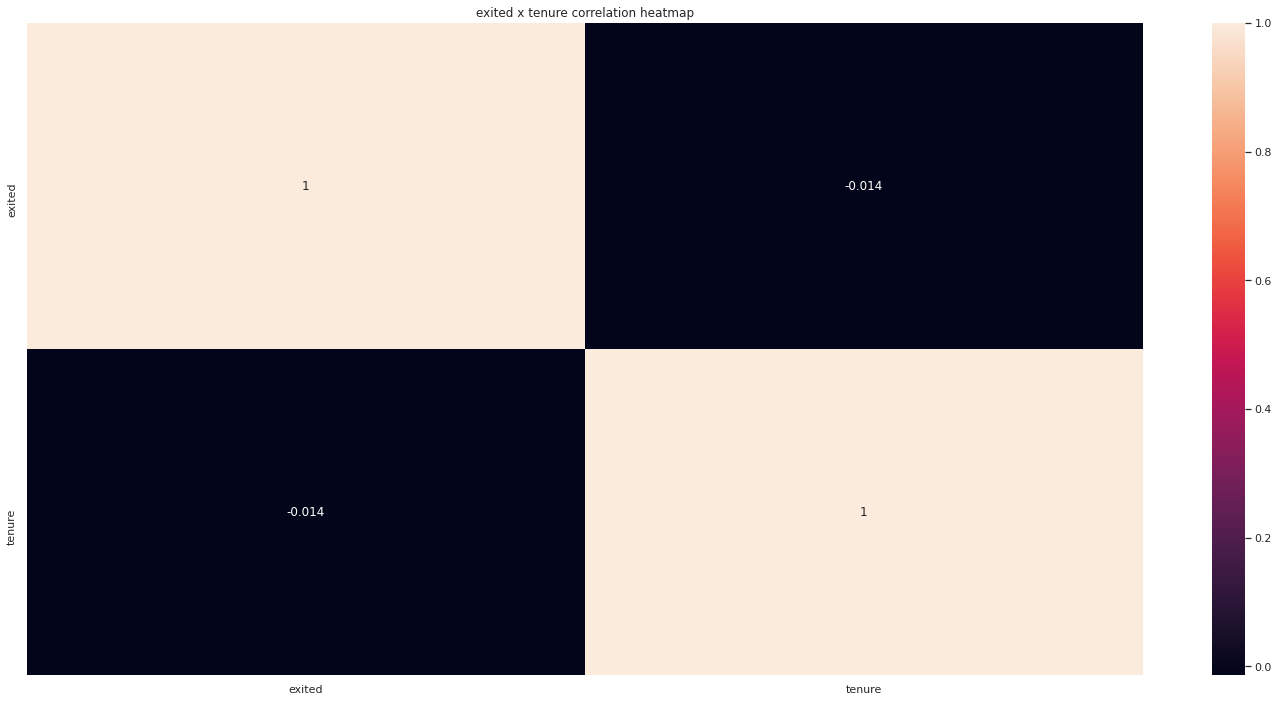

In [129]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['tenure']]);

- The tenure for churn and not churn is evenly distributed and has a very similar distribution and proportion pattern.
- There is no clear pattern that determines, based on the tenure, if a client is in churn.
- The biggest relative percentage difference between churn and not churn are for tenure 1 (1.2%), 2 (1.2%), 7 (1.7%) and 9 (1%).
- The correlation heatmap shows a low correlation coefficient between tenure and churn (exited) of -0.0024.
- The relative tenure proportion of clients in churn is greater for the lowest and biggest tenure than the tenure proportion of clients not in churn: that happens for tenure 0, 1, 9 and 10.
- Therefore, the hypothesis is true: churn occur for clients with high tenure.

### Hypothesis Summary

- H1. Customers with higher salaries tend to be in churn TRUE

- H2. Customers with lower balances tend to be in churn FALSE

- H3. Customers who live in France tend to be in churn FALSE
- H4. Active members should not be in churn FALSE
- H5. Younger costumers tend to churn more often fALSE
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Customer with higher tenure tend to have a lower churn rate

In [130]:
summary = pd.DataFrame({'Hypothesis':['Customers with higher salaries tend to be in churn',
                                      'Customers with lower balances tend to be in churN',
                                      'Customers who live in France tend to be in churn',
                                      'Active members should not be in churn.',
                                      'Younger costumers tend to churn more often',
                                      'Customers with credit card have more probability to churn.',
                                      'Customers with high credit scores have less probability to churn',
                                      'Customers with less products tend to churn more',
                                      'Womans tend to churn more often than mens.',
                                      'Customer with higher tenure tend to have a lower churn rate',
                                     ],
                        'True / False':['True', 'False', 'False', 'False', 'False', 'False', 'False', 'True', 'True',
                                        'False'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'High', 'Medium', 
                                     'Low',]}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

,Hypothesis,True / False,Relevance
1,Customers with higher salaries tend to be in c...,True,Low
2,Customers with lower balances tend to be in churN,False,Medium
3,Customers who live in France tend to be in churn,False,Medium
4,Active members should not be in churn.,False,Low
5,Younger costumers tend to churn more often,False,Medium
6,Customers with credit card have more probabili...,False,Low
7,Customers with high credit scores have less pr...,False,Medium
8,Customers with less products tend to churn more,True,High
9,Womans tend to churn more often than mens.,True,Medium
10,Customer with higher tenure tend to have a low...,False,Low


## Multivariate Analysis

### Numeric Attributes

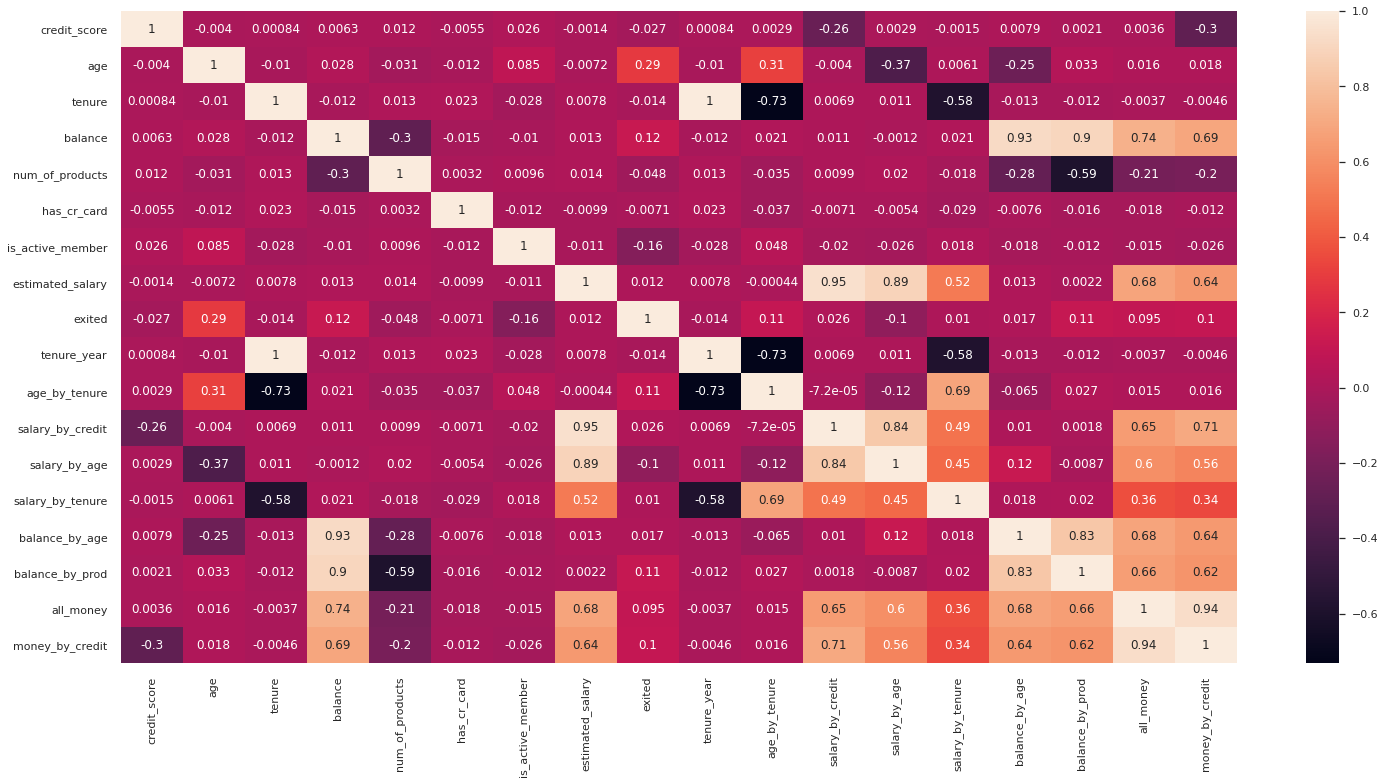

In [71]:
correlation = (num_att.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

In [67]:
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Reds').set_title(col);
    
    return plot

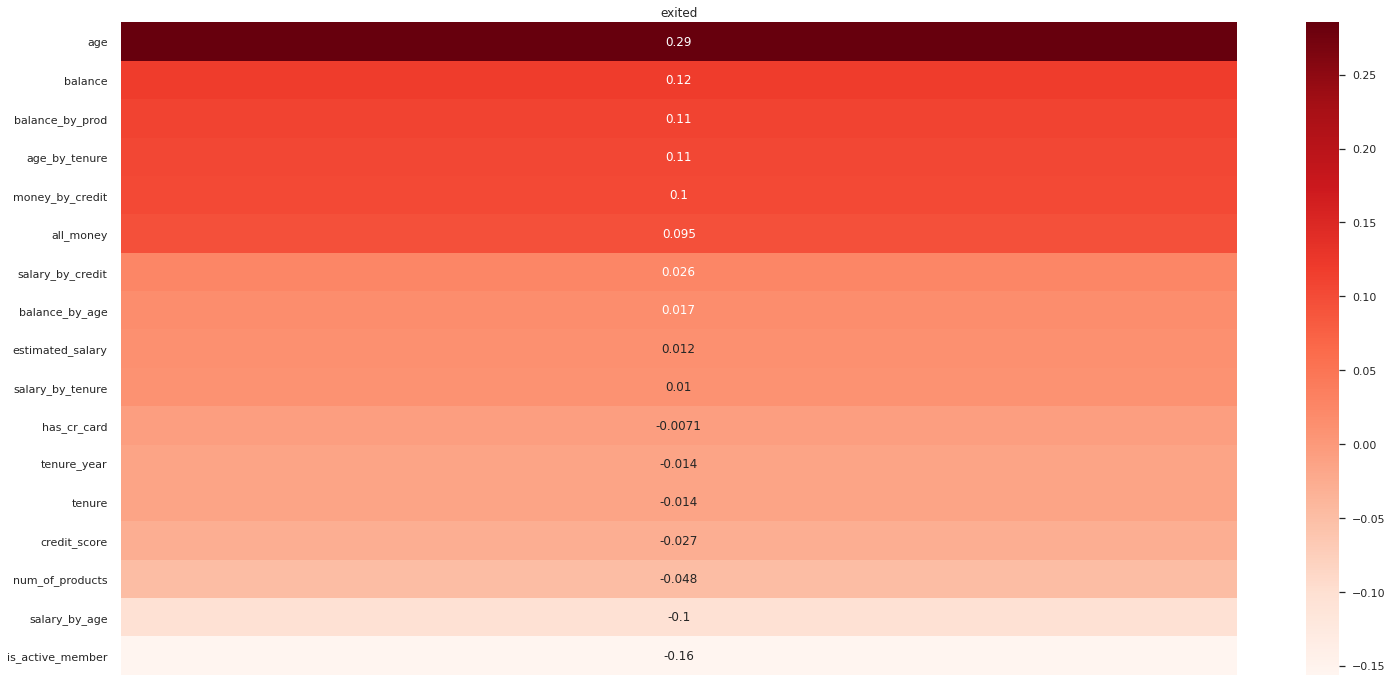

In [72]:
plot_corr('exited') ;

### Categorical Attributes

In [75]:
# Only categorical attributes
a = df3.select_dtypes( include = 'object')

# Calculate and create cramer_v matrix

a1 = cramer_v(a['geography'], a['geography'])
a2 = cramer_v(a['geography'], a['gender'])

a3 = cramer_v(a['gender'], a['geography'])
a4 = cramer_v(a['gender'], a['gender'])

d = pd.DataFrame( {'geography': [a1, a2],
              'gender': [a3,a4]})

d = d.set_index( d.columns) # Setting index name iqual columns name
d

,geography,gender
geography,1.000100,0.026303
gender,0.026303,0.999848


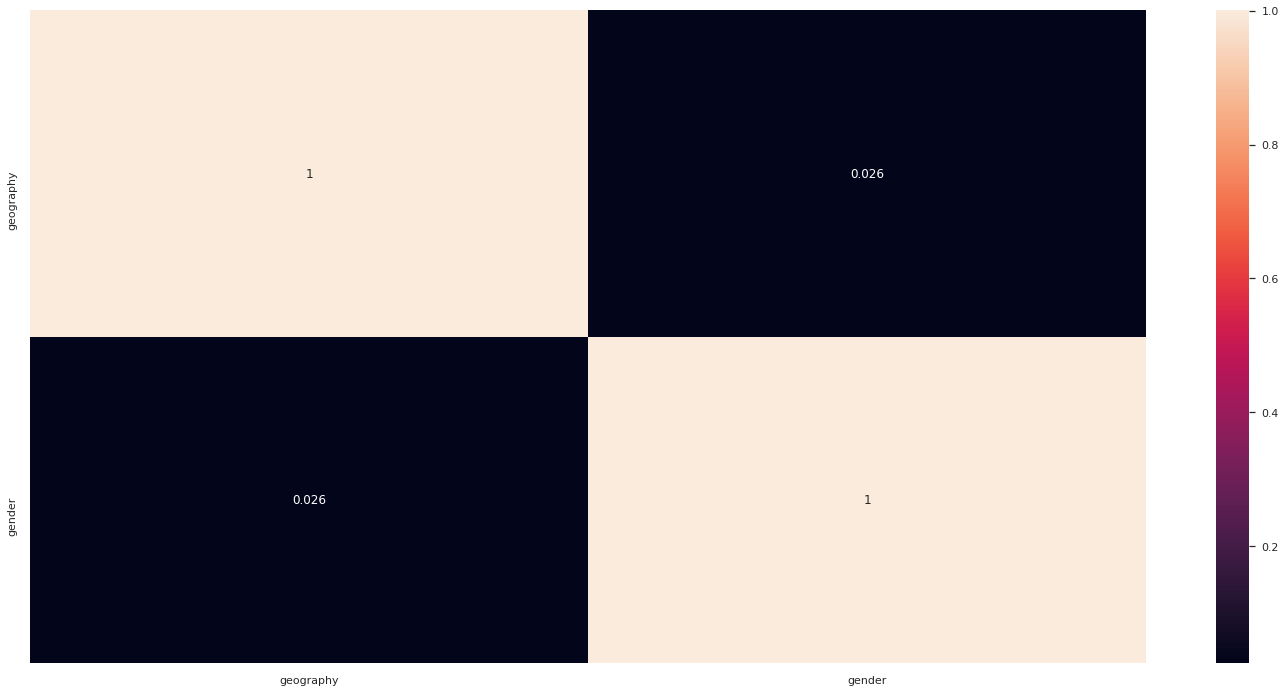

In [76]:
sns.heatmap(d, annot = True);

# Split Dataset into Train and Test


In [81]:
df4 = df3.copy()

In [95]:
# drop target variable from training set
X = df4.drop('exited', axis = 1).copy()
y = df4['exited'].copy()

#apply stratief split to split train and test datasets, 80% for training and 20% for test
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, 
                                                            shuffle = True, stratify = y)

#stratify = yes preservers class proportion 

In [97]:
X_train_imb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2151 to 6206
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      8000 non-null   int64  
 1   geography         8000 non-null   object 
 2   gender            8000 non-null   object 
 3   age               8000 non-null   int64  
 4   tenure            8000 non-null   int64  
 5   balance           8000 non-null   float64
 6   num_of_products   8000 non-null   int64  
 7   has_cr_card       8000 non-null   int64  
 8   is_active_member  8000 non-null   int64  
 9   estimated_salary  8000 non-null   float64
 10  tenure_year       8000 non-null   int64  
 11  age_by_tenure     8000 non-null   float64
 12  salary_by_credit  8000 non-null   float64
 13  salary_by_age     8000 non-null   float64
 14  salary_by_tenure  8000 non-null   float64
 15  balance_by_age    8000 non-null   float64
 16  balance_by_prod   8000 non-null   float

In [116]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 5702 to 3776
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      2000 non-null   int64  
 1   geography         2000 non-null   object 
 2   gender            2000 non-null   object 
 3   age               2000 non-null   int64  
 4   tenure            2000 non-null   int64  
 5   balance           2000 non-null   float64
 6   num_of_products   2000 non-null   int64  
 7   has_cr_card       2000 non-null   int64  
 8   is_active_member  2000 non-null   int64  
 9   estimated_salary  2000 non-null   float64
 10  tenure_year       2000 non-null   int64  
 11  age_by_tenure     2000 non-null   float64
 12  salary_by_credit  2000 non-null   float64
 13  salary_by_age     2000 non-null   float64
 14  salary_by_tenure  2000 non-null   float64
 15  balance_by_age    2000 non-null   float64
 16  balance_by_prod   2000 non-null   float

In [121]:
y_train_imb = y_train_imb.to_frame()

### Checking target variable proportion, since it's an imbalanced class problem

In [113]:
y_test.value_counts(normalize = True)*100

0    79.65
1    20.35
Name: exited, dtype: float64

In [111]:
y_train_imb.value_counts(normalize = True)*100

0    79.625
1    20.375
Name: exited, dtype: float64

- **proportion of target variables are ok between train and test datasets**

# DATA PREPARATION

The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

- **Standard Scaler**: applied on variables with a distribution shape similar to a normal distribution;
- **Min-Max Scaler**: applied on variables with low outliers influence; tenure, tenure_year, balance, has_cr_card, is_active_member, estimated_salary, salary_by_credit, balance_by_prod, all_money, num_of_products
- **Robust Scaler**: applied on variables with high outliers influence. age, salary_by_tenure, age_by_tenure, salary_by_age, salary_by_tenure, balance_by_age, money_by_credit

In [343]:
# applying Data Prep. only in th training dataset

#rebuild training data with target variable so we can prepare the data for modeling
df5 = pd.merge(X_train_imb, y_train_imb, left_index=True, right_index=True)

In [344]:
df5.head()

,age,is_active_member,num_of_products,geography_France,gender_Male,age_by_tenure,balance_by_prod,gender_Female,balance_by_age,balance,all_money,salary_by_age,money_by_credit,geography_Spain,credit_score,geography_Germany,exited
2151,1.666667,0.0,0.000000,1,1,0.103114,0.000000,0,-0.668459,0.000000,0.398205,0.106157,-0.301421,0,1.058568,0,1
8392,-0.416667,0.0,0.000000,0,1,0.235690,0.428413,0,0.256318,0.428413,0.414781,-0.195344,-0.235166,0,0.913626,1,1
5006,0.000000,1.0,0.333333,0,0,4.629630,0.238824,1,0.223265,0.477648,0.577555,0.247795,0.180682,0,1.079274,1,0
4117,0.000000,0.0,0.333333,1,1,-0.042088,0.000000,0,-0.668459,0.000000,0.207374,-0.102315,-0.626172,0,-0.929207,0,0
7182,1.000000,1.0,0.333333,0,1,0.084175,0.231850,0,-0.014777,0.463700,0.544457,-0.122117,0.225269,0,0.427035,1,0


In [131]:
df5.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'tenure_year', 'age_by_tenure', 'salary_by_credit',
       'salary_by_age', 'salary_by_tenure', 'balance_by_age',
       'balance_by_prod', 'all_money', 'money_by_credit', 'exited'],
      dtype='object')

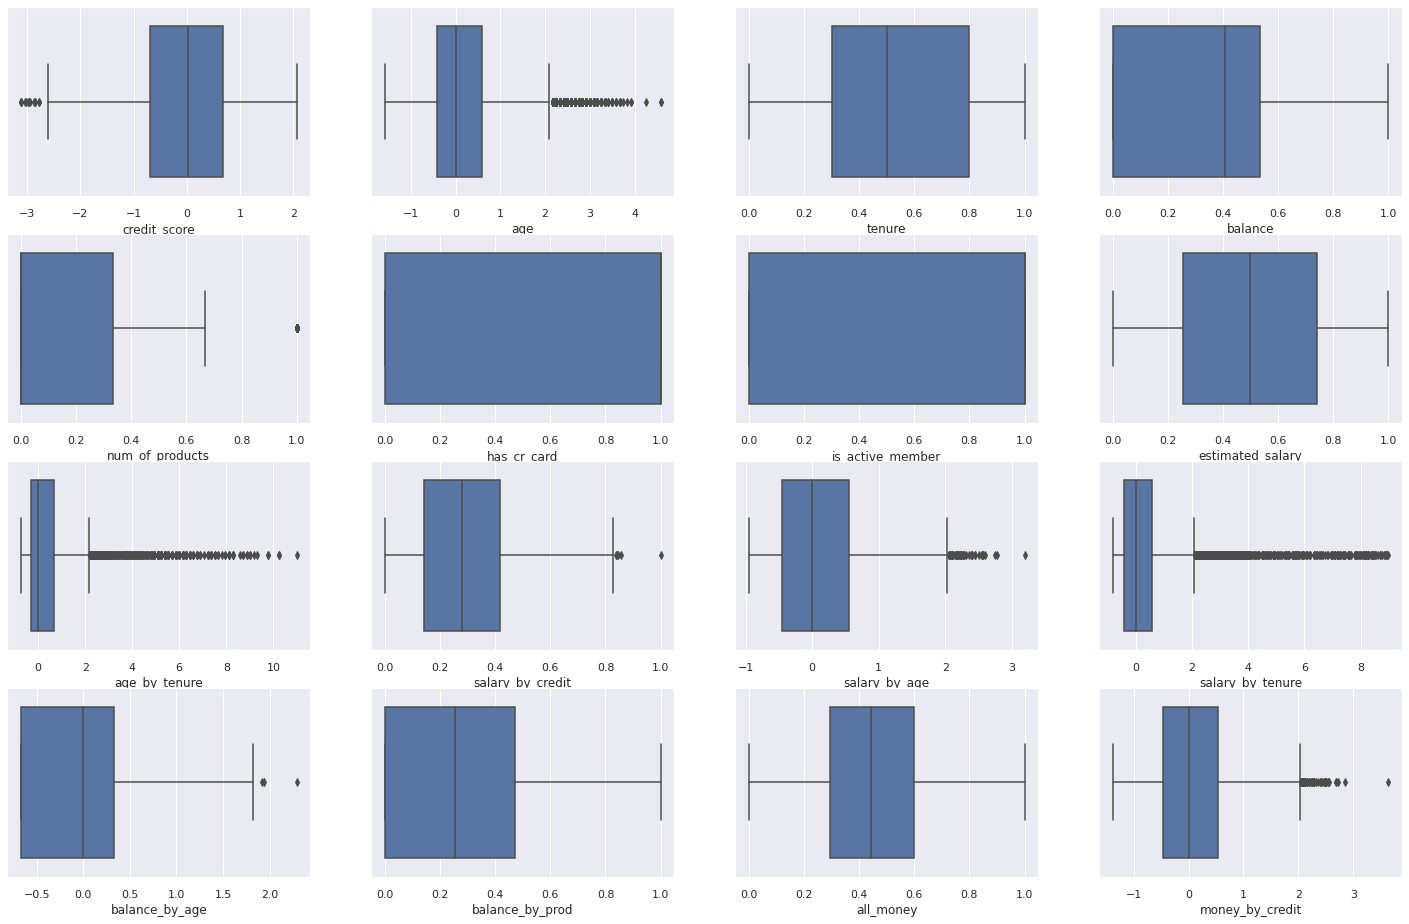

In [182]:
# plot boxplots features in order to check outliers presence
 # set up figure size
plt.subplots(figsize=(25,16))

plt.subplot(4, 4, 1)
sns.boxplot(df5['credit_score'])

plt.subplot(4, 4, 2)
sns.boxplot(df5['age'])

plt.subplot(4, 4, 3)
sns.boxplot(df5['tenure'])

plt.subplot(4, 4, 4)
sns.boxplot(df5['balance'])

plt.subplot(4, 4, 5)
sns.boxplot(df5['num_of_products'])

plt.subplot(4, 4, 6)
sns.boxplot(df5['has_cr_card'])

plt.subplot(4, 4, 7)
sns.boxplot(df5['is_active_member'])

plt.subplot(4, 4, 8)
sns.boxplot(df5['estimated_salary'])

plt.subplot(4, 4, 9)
sns.boxplot(df5['age_by_tenure'])

plt.subplot(4, 4, 10)
sns.boxplot(df5['salary_by_credit'])

plt.subplot(4, 4, 11)
sns.boxplot(df5['salary_by_age'])

plt.subplot(4, 4, 12)
sns.boxplot(df5['salary_by_tenure'])

plt.subplot(4, 4, 13)
sns.boxplot(df5['balance_by_age'])

plt.subplot(4, 4, 14)
sns.boxplot(df5['balance_by_prod'])

plt.subplot(4, 4, 15)
sns.boxplot(df5['all_money'])

plt.subplot(4, 4, 16)
sns.boxplot(df5['money_by_credit']);

## Feature Normalization

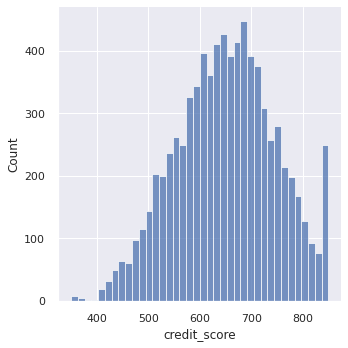

In [138]:
sns.displot(data = df5, x = 'credit_score');

In [148]:
#StandardScaler
ssc = StandardScaler()

# credit score
df5['credit_score'] = ssc.fit_transform(df5[['credit_score']].values)
pickle.dump(ssc, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/credit_score_scaler.pkl', 'wb'))

df5['credit_score'] = ssc.fit(df5[['credit_score']].values)
pickle.dump(ssc_fitted, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/credit_score_scaler.pkl', 'wb'))


In [338]:
df5['credit_score'].head()

2151    1.058568
8392    0.913626
5006    1.079274
4117   -0.929207
7182    0.427035
Name: credit_score, dtype: float64

## Feature Rescaling

In [149]:
# Min-Max-Scaler
mms = MinMaxScaler()

#tenure
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/tenure_scaler.pkl', 'wb'))

#tenure_year
df5['tenure_year'] = mms.fit_transform(df5[['tenure_year']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/tenure_year_scaler.pkl', 'wb'))

#balance
df5['balance'] = mms.fit_transform(df5[['balance']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/balance_scaler.pkl', 'wb'))

#has_cr_card
df5['has_cr_card'] = mms.fit_transform(df5[['has_cr_card']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/has_cr_card_scaler.pkl', 'wb'))

#is_active_member
df5['is_active_member'] = mms.fit_transform(df5[['is_active_member']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/is_active_member_scaler.pkl', 'wb'))

#estimated_salary
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/estimated_salary_scaler.pkl', 'wb'))

#salary_by_credit
df5['salary_by_credit'] = mms.fit_transform(df5[['salary_by_credit']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/salary_by_credit_scaler.pkl', 'wb'))

#balance_by_prod
df5['balance_by_prod'] = mms.fit_transform(df5[['balance_by_prod']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/balance_by_prod_scaler.pkl', 'wb'))

#all_money
df5['all_money'] = mms.fit_transform(df5[['all_money']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/all_money_scaler.pkl', 'wb'))

#num_of_products
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)
pickle.dump(mms, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/num_of_products_scaler.pkl', 'wb'))


In [150]:
#Robust Scaler
rss = RobustScaler()

#age
df5['age'] = rss.fit_transform(df5[['age']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/age_scaler.pkl', 'wb'))

#salary_by_tenure
df5['salary_by_tenure'] = rss.fit_transform(df5[['salary_by_tenure']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/salary_by_tenure_scaler.pkl', 'wb'))

#age_by_tenure
df5['age_by_tenure'] = rss.fit_transform(df5[['age_by_tenure']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/age_by_tenure_scaler.pkl', 'wb'))

#salary_by_age
df5['salary_by_age'] = rss.fit_transform(df5[['salary_by_age']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/salary_by_age_scaler.pkl', 'wb'))

#salary_by_tenure
df5['salary_by_tenure'] = rss.fit_transform(df5[['salary_by_tenure']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/salary_by_tenure_scaler.pkl', 'wb'))

#balance_by_age
df5['balance_by_age'] = rss.fit_transform(df5[['balance_by_age']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/balance_by_age_scaler.pkl', 'wb'))

#money_by_credit
df5['money_by_credit'] = rss.fit_transform(df5[['money_by_credit']].values)
pickle.dump(rss, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/parameters/money_by_credit_scaler.pkl', 'wb'))


## Feature Transformation

### Enconding

The majority of Machine Learning Models don't accept strings as inputs, so it is important to **convert the categorical string features into numerical values**.

Here, **One Hot Encoding** will be the encoding strategy because it works for variables that have **low cardinality** (number of classes) and pass the idea of distinct circumstances. The categorical features **geography** and **gender** match these characteristics.

In [151]:
df5.select_dtypes(include = 'object').head()

,geography,gender
2151,France,Male
8392,Germany,Male
5006,Germany,Female
4117,France,Male
7182,Germany,Male


In [152]:
# Apply One-Hot-Encoding on the features 'gender' and 'geography' due its low cardinality, 
# so it will generate only few extra columns

df5 = pd.get_dummies(df5, prefix = ['geography'], columns = ['geography'], dtype = 'int64')
df5 = pd.get_dummies(df5, prefix = ['gender'], columns = ['gender'], dtype = 'int64')

In [153]:
df5.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
2151,1.058568,1.666667,0.7,0.000000,0.000000,1.0,0.0,0.797394,0.7,0.103114,0.386104,0.106157,0.169244,-0.668459,0.000000,0.398205,-0.301421,1,1,0,0,0,1
8392,0.913626,-0.416667,0.3,0.428413,0.000000,1.0,0.0,0.319879,0.3,0.235690,0.157822,-0.195344,-0.024213,0.256318,0.428413,0.414781,-0.235166,1,0,1,0,0,1
5006,1.079274,0.000000,0.0,0.477648,0.333333,1.0,1.0,0.586979,0.0,4.629630,0.283466,0.247795,4.955871,0.223265,0.238824,0.577555,0.180682,0,0,1,0,1,0
4117,-0.929207,0.000000,0.5,0.000000,0.333333,1.0,0.0,0.415448,0.5,-0.042088,0.270019,-0.102315,-0.129632,-0.668459,0.000000,0.207374,-0.626172,0,1,0,0,0,1
7182,0.427035,1.000000,0.6,0.463700,0.333333,0.0,1.0,0.537358,0.6,0.084175,0.283131,-0.122117,-0.055747,-0.014777,0.231850,0.544457,0.225269,0,0,1,0,0,1


## Check Prepared Data

In [154]:
num_att = df5.select_dtypes(include = 'number')
num_att.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
2151,1.058568,1.666667,0.7,0.000000,0.000000,1.0,0.0,0.797394,0.7,0.103114,0.386104,0.106157,0.169244,-0.668459,0.000000,0.398205,-0.301421,1,1,0,0,0,1
8392,0.913626,-0.416667,0.3,0.428413,0.000000,1.0,0.0,0.319879,0.3,0.235690,0.157822,-0.195344,-0.024213,0.256318,0.428413,0.414781,-0.235166,1,0,1,0,0,1
5006,1.079274,0.000000,0.0,0.477648,0.333333,1.0,1.0,0.586979,0.0,4.629630,0.283466,0.247795,4.955871,0.223265,0.238824,0.577555,0.180682,0,0,1,0,1,0
4117,-0.929207,0.000000,0.5,0.000000,0.333333,1.0,0.0,0.415448,0.5,-0.042088,0.270019,-0.102315,-0.129632,-0.668459,0.000000,0.207374,-0.626172,0,1,0,0,0,1
7182,0.427035,1.000000,0.6,0.463700,0.333333,0.0,1.0,0.537358,0.6,0.084175,0.283131,-0.122117,-0.055747,-0.014777,0.231850,0.544457,0.225269,0,0,1,0,0,1


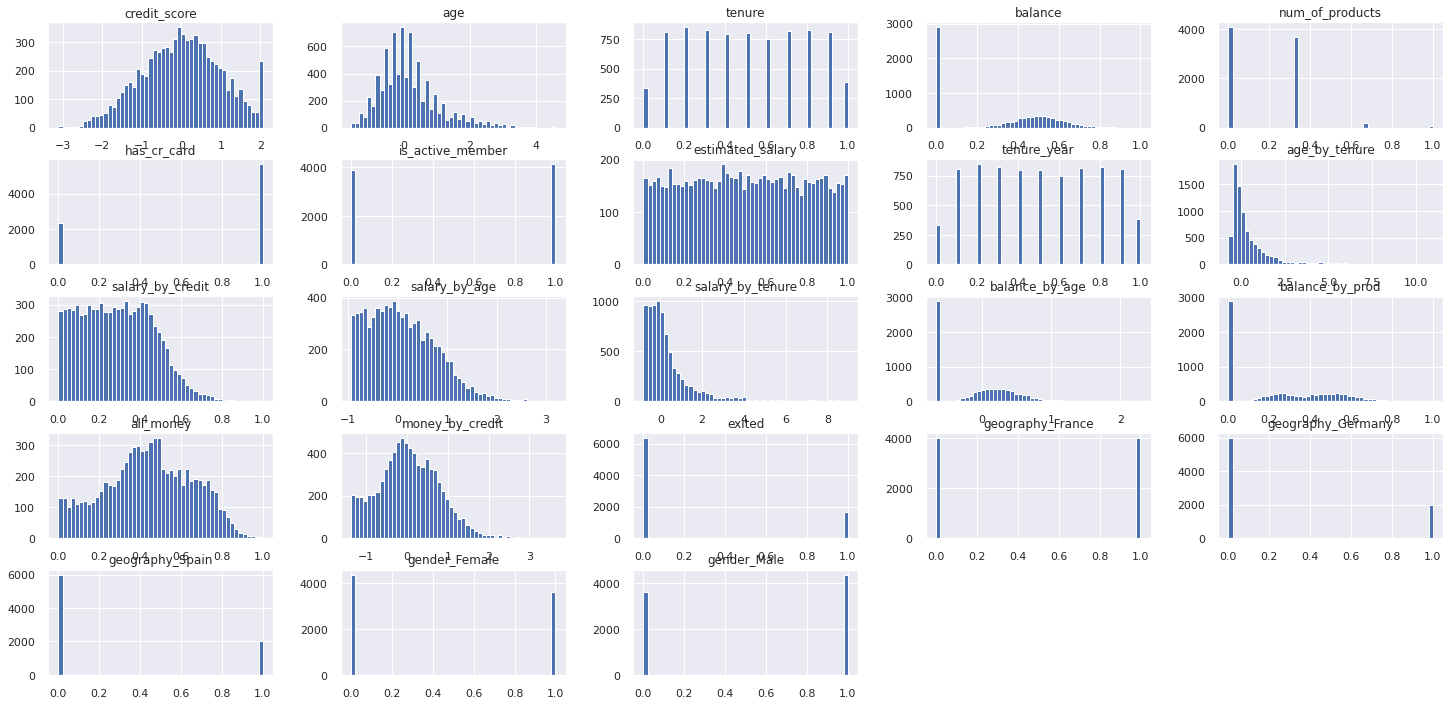

In [183]:
num_att.hist(bins = 50);

In [156]:
df4.dtypes

credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
tenure_year           int64
age_by_tenure       float64
salary_by_credit    float64
salary_by_age       float64
salary_by_tenure    float64
balance_by_age      float64
balance_by_prod     float64
all_money           float64
money_by_credit     float64
dtype: object

# FEATURE SELECTION

In [157]:
df6 = df5.copy()

In [158]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2151 to 6206
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       8000 non-null   float64
 1   age                8000 non-null   float64
 2   tenure             8000 non-null   float64
 3   balance            8000 non-null   float64
 4   num_of_products    8000 non-null   float64
 5   has_cr_card        8000 non-null   float64
 6   is_active_member   8000 non-null   float64
 7   estimated_salary   8000 non-null   float64
 8   tenure_year        8000 non-null   float64
 9   age_by_tenure      8000 non-null   float64
 10  salary_by_credit   8000 non-null   float64
 11  salary_by_age      8000 non-null   float64
 12  salary_by_tenure   8000 non-null   float64
 13  balance_by_age     8000 non-null   float64
 14  balance_by_prod    8000 non-null   float64
 15  all_money          8000 non-null   float64
 16  money_by_credit    80

## Training dataset

In [159]:
# remove target variable from train dataset
X_train_imb = df6.drop(columns = 'exited').copy()

# target variable
y_train_imb = df6['exited'].copy()

In [160]:
# check the churn ratio of the train dataset
y_train_imb.value_counts(normalize = True)*100

0    79.625
1    20.375
Name: exited, dtype: float64

In [161]:
# check the churn ratio of the test dataset
y_test.value_counts(normalize = True)*100

0    79.65
1    20.35
Name: exited, dtype: float64

## Balancing Dataset

In [162]:
# Balance dataset
# define sampler
resampler = c.SMOTETomek(random_state = 42, n_jobs=-1)

X_train, y_train = resampler.fit_resample(X_train_imb, y_train_imb)

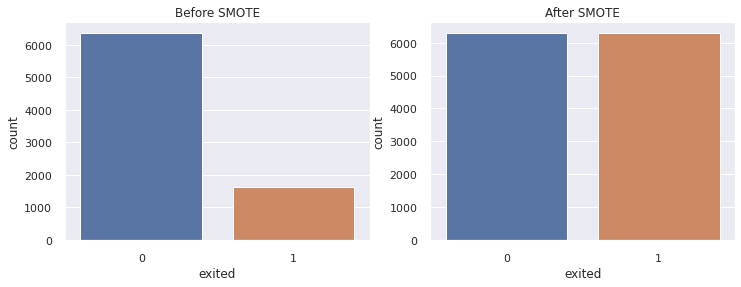

In [163]:
# Plot Before and after
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train_imb).set_title('Before SMOTE')

plt.subplot(1,2,2)
sns.countplot(x=y_train).set_title('After SMOTE') ;

In [184]:
y_train.shape

(12612,)

## Feature Selection Using Boruta

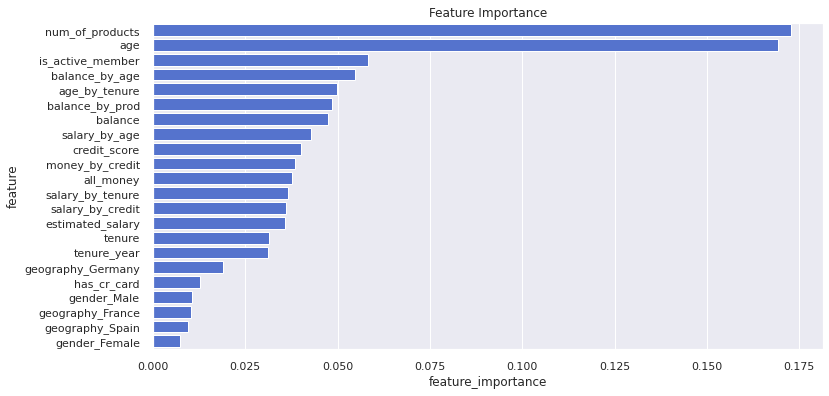

In [165]:
# train random forest classifier
rf = RandomForestClassifier(n_estimators = 300, n_jobs =-1, random_state = 42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [166]:
rf = RandomForestClassifier(n_estimators = 300, n_jobs =-1, random_state = 42)

# define Boruta Selector methord and find all relevant features

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	5
I

In [167]:
# boruta - results

cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list( np.setdiff1d(X_train.columns, cols_selected_boruta))

In [168]:
cols_selected_boruta

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit',
 'geography_Germany']

In [169]:
cols_not_selected_boruta

['gender_Female',
 'gender_Male',
 'geography_France',
 'geography_Spain',
 'has_cr_card']

In [220]:
cols_not_selected_boruta

['geography_Germany', 'has_cr_card', 'tenure', 'tenure_year']

In [172]:
feat_imp_select = feat_imp.iloc[:22]
feat_imp_select

,feature,feature_importance
0,num_of_products,0.172693
1,age,0.169165
2,is_active_member,0.058318
3,balance_by_age,0.054688
4,age_by_tenure,0.049825
5,balance_by_prod,0.048431
6,balance,0.047436
7,salary_by_age,0.042674
8,credit_score,0.040223
9,money_by_credit,0.038474


In [249]:
# feature selection
feat_imp_select = feat_imp_select.drop([21, 20, 19, 17, 16, 14])

In [250]:
# feature to list
cols_selected_boruta_full = feat_imp_select['feature'].to_list()

## Best Features

In [173]:
# manual feature selection

cols_selected_boruta_full = ['age',
 'is_active_member',
 'num_of_products',
 'geography_France',
 'gender_Male',
 'age_by_tenure',
 'balance_by_prod',
 'gender_Female',
 'balance_by_age',
 'balance',
 'all_money',
 'salary_by_age',
 'money_by_credit',
 'geography_Spain',
 'credit_score',
 'geography_Germany']

In [174]:
cols_selected_boruta_full

['age',
 'is_active_member',
 'num_of_products',
 'geography_France',
 'gender_Male',
 'age_by_tenure',
 'balance_by_prod',
 'gender_Female',
 'balance_by_age',
 'balance',
 'all_money',
 'salary_by_age',
 'money_by_credit',
 'geography_Spain',
 'credit_score',
 'geography_Germany']

After analysing the relevant features of these two models, according to Boruta and the Exploratory Data Analysis, the features removed are going to be: 'CreditScore', 'credit_cat' and 'HasCrCard'

# MACHINE LEARNING ALGORITHM MODELS

 Three different algorithms are going to be used to predict the target variable:
 
 - Logistic Regression: uses a complex cost function, which can be defined as the Sigmoid function. The output of the classification is based on the probability score between 0 and 1 of the input being in one class or another according to a threshold
 
 - Random Forest: it is a tree based model build with multiple ensamble decision trees created with the bagging method. Then, all the classifiers take a weighted vote on their predictions. Since the algorithm goal is not trying to find a linear function to describe the event, it works for problems with more complex behaviour
 - XGBoost: it is also a tree based model but they are built in a different way. While Random Forests builds each tree independently, XGBoost builds one tree at the time learning with its predecessor. Therefore, this algorithm doesn't combine results at the end of the process by taking majority votes, it combines the results along the way
 
 - Cat Boost: this model share the same logic of XGBoost, however the focus is in optimizing the decision trees for categorical variables. The goal is to work better with features with classes that have relation with one another like, for example, different colors
 
 - LightGBM: is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

        - Faster training speed and higher efficiency.

        - Lower memory usage.

        - Better accuracy.
        - 
        - Support of parallel, distributed, and GPU learning.
        - 
        - Capable of handling large-scale data.

In [175]:
# train dataset with selected features of Feature Selection

# imbalanced dataset train
X_train_imb = X_train_imb[cols_selected_boruta_full]

# balanced dataset train
x_train = X_train[cols_selected_boruta_full]

In [255]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11758 entries, 0 to 11757
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                11758 non-null  int64  
 1   is_active_member   11758 non-null  int64  
 2   num_of_products    11758 non-null  int64  
 3   geography_France   11758 non-null  int64  
 4   gender_Male        11758 non-null  int64  
 5   age_by_tenure      11758 non-null  float64
 6   balance_by_prod    11758 non-null  float64
 7   gender_Female      11758 non-null  int64  
 8   balance_by_age     11758 non-null  float64
 9   balance            11758 non-null  float64
 10  all_money          11758 non-null  float64
 11  salary_by_age      11758 non-null  float64
 12  money_by_credit    11758 non-null  float64
 13  geography_Spain    11758 non-null  int64  
 14  credit_score       11758 non-null  int64  
 15  geography_Germany  11758 non-null  int64  
dtypes: float64(7), int64(9

In [176]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12612 entries, 0 to 12611
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                12612 non-null  float64
 1   is_active_member   12612 non-null  float64
 2   num_of_products    12612 non-null  float64
 3   geography_France   12612 non-null  int64  
 4   gender_Male        12612 non-null  int64  
 5   age_by_tenure      12612 non-null  float64
 6   balance_by_prod    12612 non-null  float64
 7   gender_Female      12612 non-null  int64  
 8   balance_by_age     12612 non-null  float64
 9   balance            12612 non-null  float64
 10  all_money          12612 non-null  float64
 11  salary_by_age      12612 non-null  float64
 12  money_by_credit    12612 non-null  float64
 13  geography_Spain    12612 non-null  int64  
 14  credit_score       12612 non-null  float64
 15  geography_Germany  12612 non-null  int64  
dtypes: float64(11), int64(

In [ ]:
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test dataset function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

The cross_validate function differs from cross_val_score in two ways:

It allows specifying multiple metrics for evaluation.

It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

## Logistic Regression

### Imbalanced Data

In [194]:
# instantiate the model
lr_imb = LogisticRegression()

# model traning
lr_imb.fit(X_train_imb, y_train_imb)

# model performance with performance function. For more details, please see Helper Functions section.
lr_imb_train_result = performance(lr_imb, X_train_imb, y_train_imb)
lr_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.812,0.606719,0.221472,0.324052,0.59229,0.283256


In [195]:
# predcitions
lr_imb_y_pred = cross_val_predict(lr_imb, X_train_imb, y_train_imb, cv = 10)

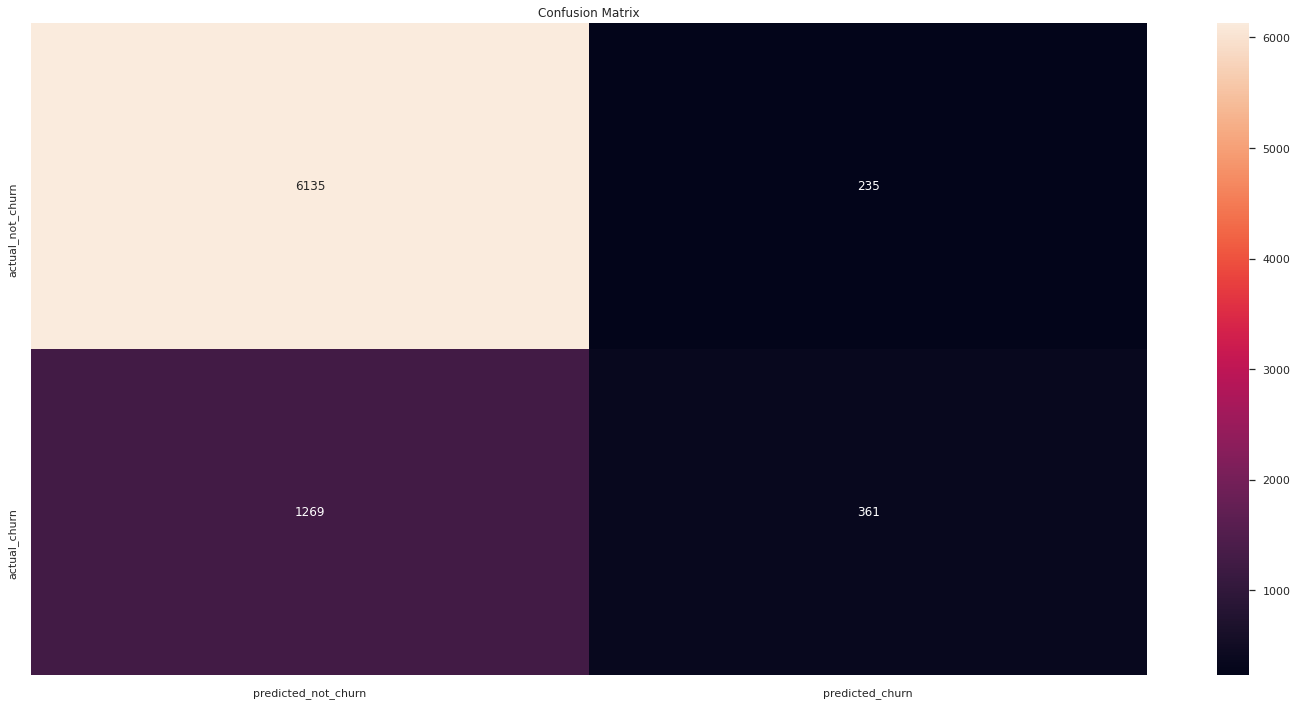

In [197]:
# confusion matrix
lr_imb_cm = confusion_matrix(y_train_imb, lr_imb_y_pred)

# dataframe for heatmap
lr_imb_cm_df = pd.DataFrame(lr_imb_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(lr_imb_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

### Balanced Data

In [198]:
# Instatiate the model
lr = LogisticRegression()

# model training
lr.fit(x_train, y_train)

# model performance
lr_train_result = performance(lr, x_train, y_train)
lr_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.730498,0.737775,0.71488,0.725924,0.730495,0.461453


In [200]:
# predcitions
lr_y_pred = cross_val_predict(lr, x_train, y_train, cv = 10)

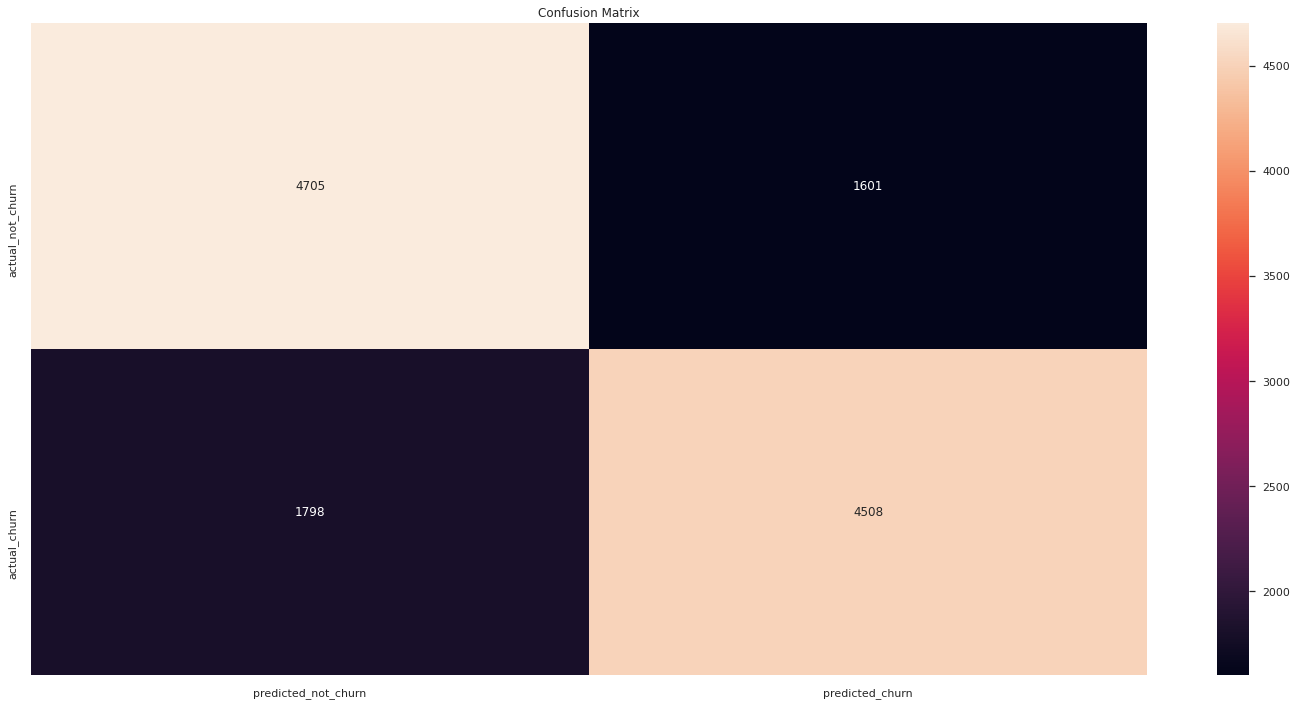

In [201]:
# confusion matrix
lr_cm = confusion_matrix(y_train, lr_y_pred)

# dataframe for heatmap
lr_cm_df = pd.DataFrame(lr_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(lr_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## Random Forest Classifier

### Imbalanced Data

In [209]:
# instantiate
rf_imb = RandomForestClassifier(random_state = 42, n_jobs=-1)

# model training
rf_imb.fit(X_train_imb, y_train_imb)

# model performance
rf_imb_train_result = performance(rf_imb, X_train_imb, y_train_imb)
rf_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.86075,0.753441,0.471166,0.578398,0.715803,0.521012


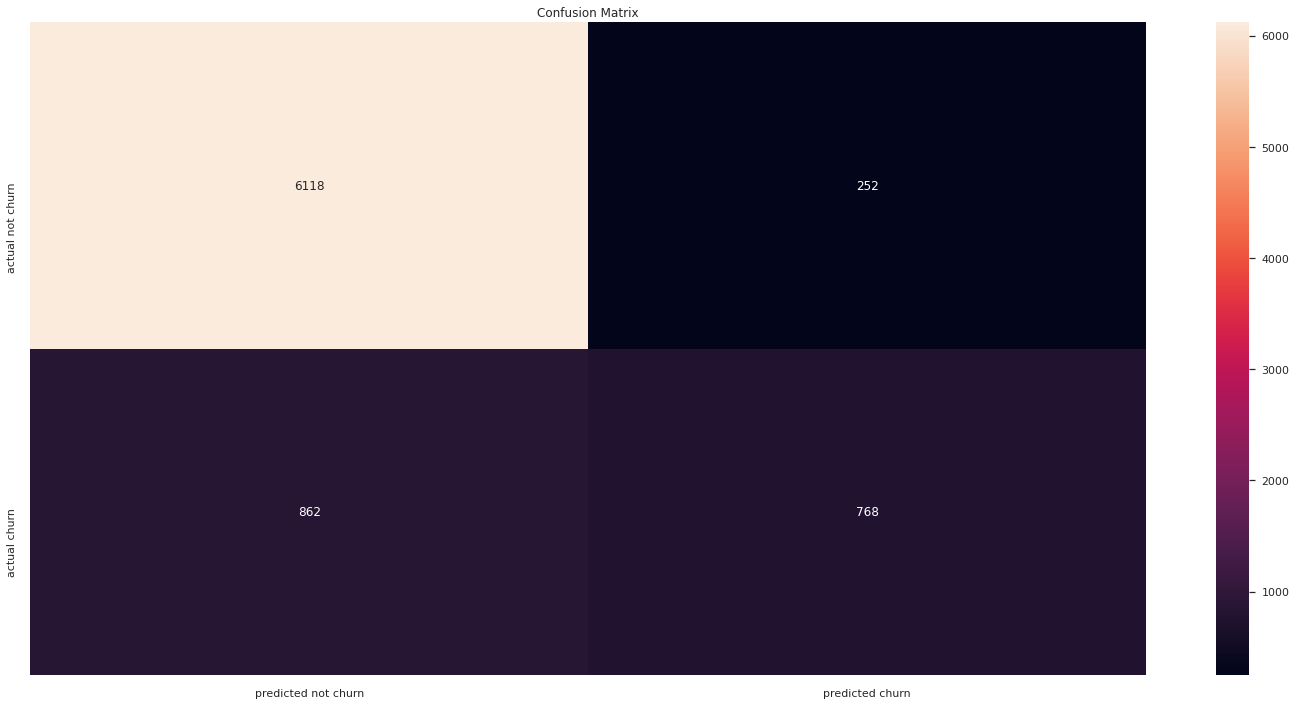

In [383]:
# predictions
rf_y_imb_prediction = cross_val_predict(rf_imb, X_train_imb, y_train_imb, cv = 10)

# confusion matrix
rf_cm = confusion_matrix(y_train_imb, rf_y_imb_prediction)

# Heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(rf_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

### Balanced Data

In [206]:
rf = RandomForestClassifier( random_state = 42, n_jobs=-1)

rf.fit(x_train, y_train)

# model performance
rf_train_result = performance(rf, x_train, y_train)
rf_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.905975,0.902637,0.909011,0.90426,0.905981,0.814429


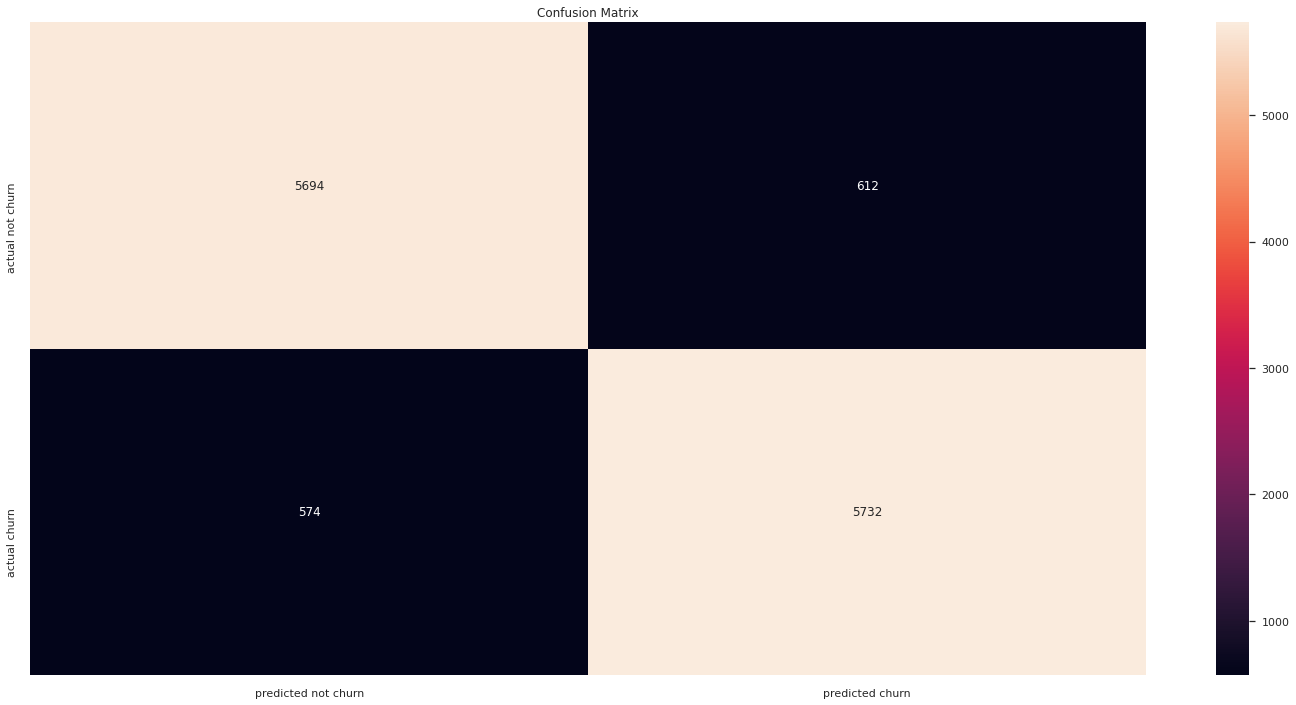

In [380]:
# predictions
rf_y_prediction = cross_val_predict(rf, x_train, y_train, cv = 10)

# confusion matrix
rf_cm = confusion_matrix(y_train, rf_y_prediction)

# Heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(rf_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

## XGBoost

### Imbalanced Data

In [241]:
# instantiate
xgb_imb = XGBClassifier(n_estimators=500, random_state = 42, n_jobs=-1, 
                    eval_metric='logloss')

#model training
xgb_imb.fit(X_train_imb, y_train_imb)

# model performance
xgb_imb_train_result = performance(xgb_imb, X_train_imb, y_train_imb)
xgb_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.848375,0.676412,0.493865,0.569409,0.716477,0.489895


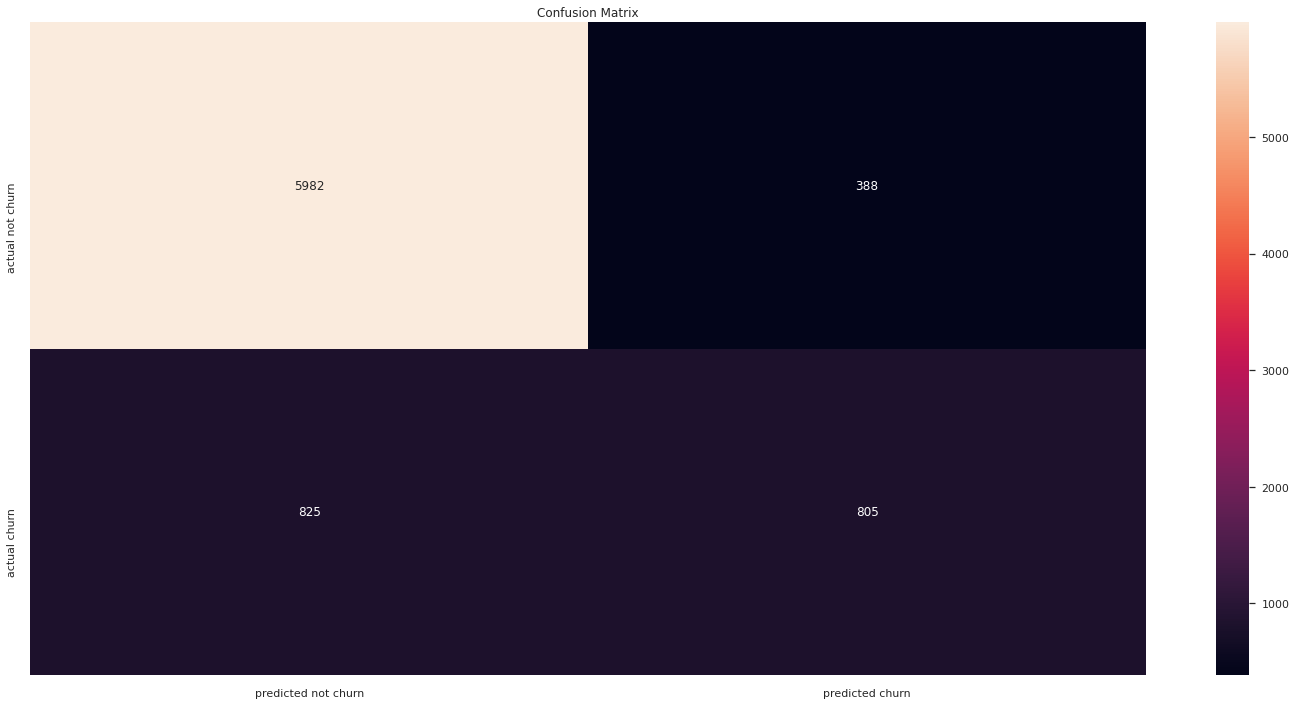

In [384]:
# predictions
xgb_y_prediction = cross_val_predict(xgb_imb, X_train_imb, y_train_imb, cv = 10)

# confusion matrix
xgb_cm = confusion_matrix(y_train_imb, xgb_y_prediction)

# Heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(xgb_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

### Balanced Data

In [242]:
# instatiate 
xgb = XGBClassifier(n_estimators=500, random_state = 42, n_jobs=-1, eval_metric='logloss')

# model training
xgb.fit(X_train, y_train)

# model performance
xgb_train_result = performance(xgb, X_train, y_train)
xgb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.904321,0.921214,0.883038,0.892571,0.90433,0.819368


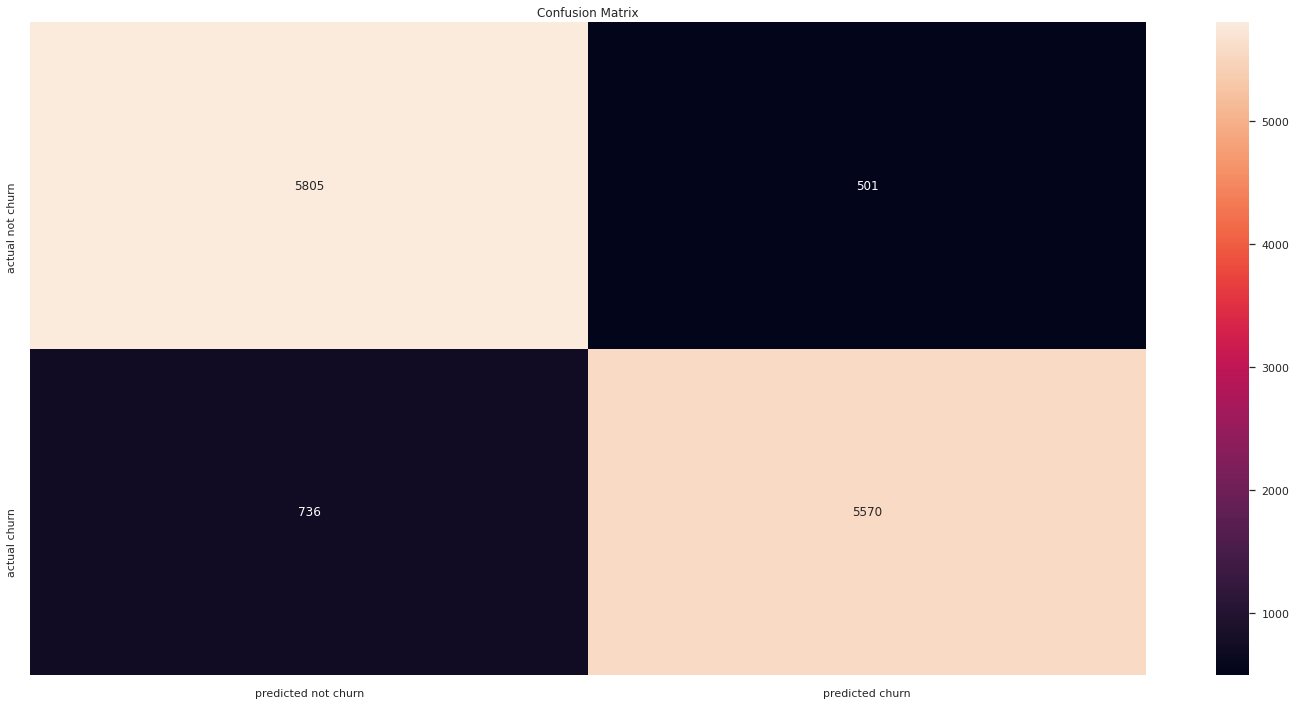

In [382]:
# predictions
xgb_y_prediction = cross_val_predict(xgb, x_train, y_train, cv = 10)

# confusion matrix
xgb_cm = confusion_matrix(y_train, xgb_y_prediction)

# Heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(xgb_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

## LightGBM 

In [234]:
import lightgbm as lgbm

### Imbalanced Data

In [236]:
# instantiate
lgbm_imb = lgbm.LGBMClassifier(n_estimators=500, random_state = 42, n_jobs=-1)

#model training
lgbm_imb.fit(X_train_imb, y_train_imb)

# model performance
lgbm_imb_train_result = performance(lgbm_imb, X_train_imb, y_train_imb)
lgbm_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.8575,0.719101,0.493252,0.58401,0.721979,0.515408


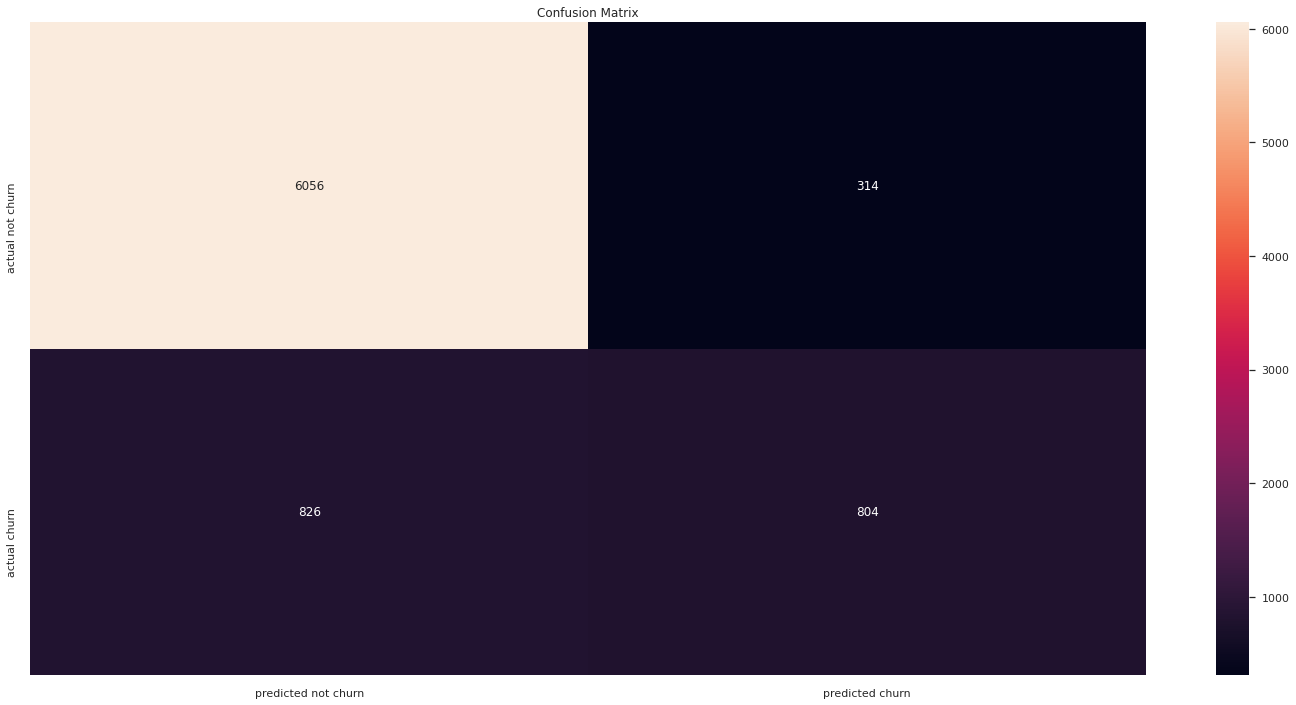

In [387]:
# predictions
lgbm_y_prediction = cross_val_predict(lgbm_imb, X_train_imb, y_train_imb, cv = 10)

# confusion matrix
lgbm_cm = confusion_matrix(y_train_imb, lgbm_y_prediction)

# Heatmap
lgbm_cm_df = pd.DataFrame(lgbm_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(lgbm_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

### Balanced Data

In [237]:
# instatiate 
lgbm = lgbm.LGBMClassifier(n_estimators=500, random_state = 42, n_jobs=-1)

# model training
lgbm.fit(X_train, y_train)

# model performance
lgbm_train_result = performance(lgbm, X_train, y_train)
lgbm_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.908605,0.932232,0.879551,0.895185,0.908615,0.828629


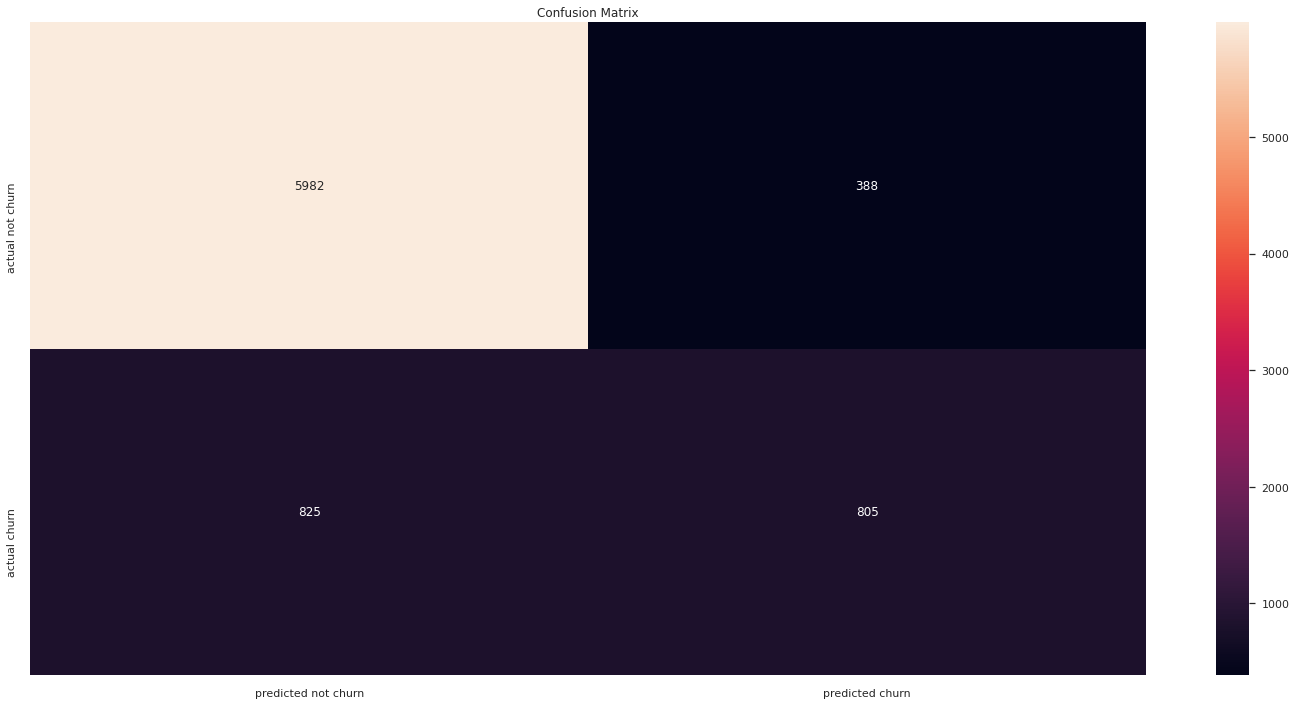

In [386]:
# predictions
lgbm_y_prediction = cross_val_predict(lgbm, x_train, y_train, cv = 10)

# confusion matrix
lgbm_cm = confusion_matrix(y_train, lgbm_y_prediction)

# Heatmap
lgbm_cm_df = pd.DataFrame(xgb_cm, columns = ['predicted not churn', 'predicted churn'], index=['actual not churn', 'actual churn'])

# plot
sns.heatmap(lgbm_cm_df, annot = True, fmt = 'd').set_title('Confusion Matrix');

## SVM

In [219]:
from sklearn.svm import SVC

### Imbalanced Data

In [243]:
# instantiate
svm_imb = SVC()

#model training
svm_imb.fit(X_train_imb, y_train_imb)

# model performance
svm_imb_train_result = performance(svm_imb, X_train_imb, y_train_imb)
svm_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.833625,0.78748,0.252761,0.382305,0.617511,0.382893


### Balanced Data

In [244]:
# instatiate 
svm = SVC()

# model training
svm.fit(X_train, y_train)

# model performance
svm_train_result = performance(svm, X_train, y_train)
svm_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.785051,0.794762,0.768008,0.780825,0.78505,0.570821


## Nayve Bayes

In [249]:
from sklearn.naive_bayes import GaussianNB

### Imbalanced Data

In [250]:
# instantiate
# Criando o modelo
nb_imb = GaussianNB()


#model training
nb_imb.fit(X_train_imb, y_train_imb)

# model performance
nb_imb_train_result = performance(nb_imb, X_train_imb, y_train_imb)
nb_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.79,0.485291,0.478528,0.48116,0.674115,0.350139


### Balanced Data

In [251]:
# instatiate 
nb = GaussianNB()

# model training
nb.fit(X_train, y_train)

# model performance
nb_train_result = performance(nb, X_train, y_train)
nb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.681097,0.681419,0.680777,0.680991,0.681094,0.3623


## CART (Classification and Regression Trees)

In [259]:
from sklearn.tree import DecisionTreeClassifier

### Imbalanced Data

In [261]:
# instantiate
# Criando o modelo
cart_imb = DecisionTreeClassifier()


#model training
cart_imb.fit(X_train_imb, y_train_imb)

# model performance
cart_imb_train_result = performance(cart_imb, X_train_imb, y_train_imb)
cart_imb_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.7925,0.491171,0.508589,0.49925,0.686869,0.368927


### Balanced Data

In [262]:
# instatiate 
cart = DecisionTreeClassifier()

# model training
cart.fit(X_train, y_train)

# model performance
cart_train_result = performance(cart, X_train, y_train)
cart_train_result

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.857294,0.852191,0.862398,0.854332,0.857301,0.718783


## Compare Model's Performance

In [265]:
# models with imbalanced data list
models_imb = [lr_imb_train_result, rf_imb_train_result, xgb_imb_train_result, lgbm_imb_train_result, svm_imb_train_result, nb_imb_train_result, cart_imb_train_result]

In [266]:
# performance comparison data frame
performance_comp = pd.concat(models_imb)
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM', 'Naive Bayes', 'CART']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.812000,0.606719,0.221472,0.324052,0.592290,0.283256
Random Forest,0.860750,0.753441,0.471166,0.578398,0.715803,0.521012
XGBoost,0.848375,0.676412,0.493865,0.569409,0.716477,0.489895
LightGBM,0.857500,0.719101,0.493252,0.584010,0.721979,0.515408
SVM,0.833625,0.787480,0.252761,0.382305,0.617511,0.382893
Naive Bayes,0.790000,0.485291,0.478528,0.481160,0.674115,0.350139
CART,0.792500,0.491171,0.508589,0.499250,0.686869,0.368927


In [264]:
# models with balanced data list
models = [lr_train_result, rf_train_result, xgb_train_result, lgbm_train_result, svm_train_result, nb_train_result, cart_train_result]

In [267]:
# performance comparison data frame
performance_comp = pd.concat(models)
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM', 'Naive Bayes', 'CART']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

,accuracy,precision,recall,f1_score,roc_auc_score,MCC
model,,,,,,
Logistic Regression,0.730498,0.737775,0.714880,0.725924,0.730495,0.461453
Random Forest,0.905975,0.902637,0.909011,0.904260,0.905981,0.814429
XGBoost,0.904321,0.921214,0.883038,0.892571,0.904330,0.819368
LightGBM,0.908605,0.932232,0.879551,0.895185,0.908615,0.828629
SVM,0.785051,0.794762,0.768008,0.780825,0.785050,0.570821
Naive Bayes,0.681097,0.681419,0.680777,0.680991,0.681094,0.362300
CART,0.857294,0.852191,0.862398,0.854332,0.857301,0.718783


# HYPERPARAMETERS FINE TUNING

In [268]:
# Choosing Random Forest as our best model based on MCC, F1_score and Recall metrics

## Random Search

### imbalanced data

In [270]:
 # set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [285]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_imb_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [293]:
# fit the model with imbalaced data
rf_imb_random.fit(X_train_imb, y_train_imb)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [294]:
rf_imb_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 32}

In [295]:
rf_imb_random.best_estimator_

RandomForestClassifier(max_depth=32, min_samples_split=10, n_estimators=600,
                       n_jobs=-1, random_state=42)

### balanced data

In [289]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [290]:
# fit the model with balanced
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [291]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 24}

In [297]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=24, n_estimators=800, n_jobs=-1,
                       random_state=42)

In [299]:
rf_tuned = rf_random.best_estimator_
rf_tuned

RandomForestClassifier(max_depth=24, n_estimators=800, n_jobs=-1,
                       random_state=42)

## tuned models

In [300]:
#imbalanced data
rf_imb_tuned = RandomForestClassifier(max_depth=32, min_samples_split=10, n_estimators=600,
                       n_jobs=-1, random_state=42).fit(X_train_imb, y_train_imb)

In [307]:
os.getcwd()

'/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/notebooks'

In [308]:
# Save Trained Model
pickle.dump(rf_imb_tuned, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/models/model_imb_tuned.pkl', 'wb'))

In [304]:
#balanced data
rf_tuned = RandomForestClassifier(max_depth=24, n_estimators=800, n_jobs=-1, min_samples_split = 2, min_samples_leaf = 1,
                       random_state=42).fit(x_train, y_train)

In [309]:
# Save Trained Model
pickle.dump(rf_tuned, open('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/models/model_tuned.pkl', 'wb'))

## Final model comparison

### Preparing Test Dataset

In [328]:
df_test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [330]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 5702 to 3776
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      2000 non-null   int64  
 1   geography         2000 non-null   object 
 2   gender            2000 non-null   object 
 3   age               2000 non-null   int64  
 4   tenure            2000 non-null   int64  
 5   balance           2000 non-null   float64
 6   num_of_products   2000 non-null   int64  
 7   has_cr_card       2000 non-null   int64  
 8   is_active_member  2000 non-null   int64  
 9   estimated_salary  2000 non-null   float64
 10  tenure_year       2000 non-null   int64  
 11  age_by_tenure     2000 non-null   float64
 12  salary_by_credit  2000 non-null   float64
 13  salary_by_age     2000 non-null   float64
 14  salary_by_tenure  2000 non-null   float64
 15  balance_by_age    2000 non-null   float64
 16  balance_by_prod   2000 non-null   float

In [331]:
df_test.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,exited
5702,585,France,Male,36,7,0.00,2,1,0,94283.09,8,4.500000,161.167675,2618.974722,11785.386250,0.000000,0.000,94283.09,161.167675,0
3667,525,Germany,Male,33,4,131023.76,2,0,0,55072.93,5,6.600000,104.900819,1668.876667,11014.586000,3970.416970,65511.880,186096.69,354.469886,0
1617,557,Spain,Female,40,4,0.00,2,0,1,105433.53,5,8.000000,189.288205,2635.838250,21086.706000,0.000000,0.000,105433.53,189.288205,0
5673,639,Spain,Male,34,5,139393.19,2,0,0,33950.08,6,5.666667,53.130016,998.531765,5658.346667,4099.799706,69696.595,173343.27,271.272723,0
4272,640,Spain,Female,34,3,77826.80,1,1,1,168544.85,4,8.500000,263.351328,4957.201471,42136.212500,2289.023529,77826.800,246371.65,384.955703,0


### Applying Data Prep into test dataset

In [332]:
df2_test = df_test.copy()

In [349]:
X_test_prep = df2_test.drop('exited', axis = 1).copy()
y_test_prep = df2_test['exited'].copy()  #target variable

In [346]:
# loading scalers
home_path = '/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/'

#StandardScaler
credit_score_scaler = pickle.load(open(home_path + 'parameters/credit_score_scaler.pkl', 'rb'))

#MinMax Scaler 
tenure_scaler           = pickle.load(open(home_path + 'parameters/tenure_scaler.pkl', 'rb'))
tenure_year_scaler      = pickle.load(open(home_path + 'parameters/tenure_year_scaler.pkl', 'rb'))
balance_scaler          = pickle.load(open(home_path + 'parameters/balance_scaler.pkl', 'rb'))
has_cr_card_scaler      = pickle.load(open(home_path + 'parameters/has_cr_card_scaler.pkl', 'rb'))
is_active_member_scaler = pickle.load(open(home_path + 'parameters/is_active_member_scaler.pkl', 'rb'))
estimated_salary_scaler = pickle.load(open(home_path + 'parameters/estimated_salary_scaler.pkl', 'rb'))
salary_by_credit_scaler = pickle.load(open(home_path + 'parameters/salary_by_credit_scaler.pkl', 'rb'))
balance_by_prod_scaler  = pickle.load(open(home_path + 'parameters/balance_by_prod_scaler.pkl', 'rb'))
all_money_scaler        = pickle.load(open(home_path + 'parameters/all_money_scaler.pkl', 'rb'))
num_of_products_scaler  = pickle.load(open(home_path + 'parameters/num_of_products_scaler.pkl', 'rb'))

#Robust Scaler

age_scaler              = pickle.load(open(home_path + 'parameters/age_scaler.pkl', 'rb'))
salary_by_tenure_scaler = pickle.load(open(home_path + 'parameters/salary_by_tenure_scaler.pkl', 'rb'))
age_by_tenure_scaler    = pickle.load(open(home_path + 'parameters/age_by_tenure_scaler.pkl', 'rb'))
salary_by_age_scaler    = pickle.load(open(home_path + 'parameters/salary_by_age_scaler.pkl', 'rb'))
salary_by_tenure_scaler = pickle.load(open(home_path + 'parameters/salary_by_tenure_scaler.pkl', 'rb'))
balance_by_age_scaler   = pickle.load(open(home_path + 'parameters/balance_by_age_scaler.pkl', 'rb'))
money_by_credit_scaler  = pickle.load(open(home_path + 'parameters/money_by_credit_scaler.pkl', 'rb'))

In [360]:
#Apply Transformations
#Standard Scaler
X_test_prep['credit_score']     = credit_score_scaler.transform(X_test_prep[['credit_score']].values)

#MinMax Scaler
X_test_prep['tenure']           = tenure_scaler.transform(X_test_prep[['tenure']].values)
X_test_prep['tenure_year']      = tenure_year_scaler.transform(X_test_prep[['tenure_year']].values)
X_test_prep['balance']          = balance_scaler.transform(X_test_prep[['balance']].values)
X_test_prep['has_cr_card']      = has_cr_card_scaler.transform(X_test_prep[['has_cr_card']].values)
X_test_prep['is_active_member'] = is_active_member_scaler.transform(X_test_prep[['is_active_member']].values)
X_test_prep['estimated_salary'] = estimated_salary_scaler.transform(X_test_prep[['estimated_salary']].values)
X_test_prep['salary_by_credit'] = salary_by_credit_scaler.transform(X_test_prep[['salary_by_credit']].values)
X_test_prep['balance_by_prod']  = balance_by_prod_scaler.transform(X_test_prep[['balance_by_prod']].values)
X_test_prep['all_money']        = all_money_scaler.transform(X_test_prep[['all_money']].values)
X_test_prep['num_of_products']  = num_of_products_scaler.transform(X_test_prep[['num_of_products']].values)

#Robust Scaler

X_test_prep['age']              = age_scaler.transform(X_test_prep[['age']].values)
X_test_prep['salary_by_tenure'] = salary_by_tenure_scaler.transform(X_test_prep[['salary_by_tenure']].values)
X_test_prep['age_by_tenure']    = age_by_tenure_scaler.transform(X_test_prep[['age_by_tenure']].values)
X_test_prep['salary_by_age']    = salary_by_age_scaler.transform(X_test_prep[['salary_by_age']].values)
X_test_prep['salary_by_tenure'] = salary_by_tenure_scaler.transform(X_test_prep[['salary_by_tenure']].values)
X_test_prep['balance_by_age']   = balance_by_age_scaler.transform(X_test_prep[['balance_by_age']].values)
X_test_prep['money_by_credit']  = money_by_credit_scaler.transform(X_test_prep[['money_by_credit']].values)


In [363]:
#Enconding
X_test_prep = pd.get_dummies(X_test_prep, prefix = ['geography'], columns = ['geography'], dtype = 'int64')
X_test_prep = pd.get_dummies(X_test_prep, prefix = ['gender'], columns = ['gender'], dtype = 'int64')

In [358]:
df2_test.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,exited
5702,585,France,Male,36,7,0.00,2,1,0,94283.09,8,4.500000,161.167675,2618.974722,11785.386250,0.000000,0.000,94283.09,161.167675,0
3667,525,Germany,Male,33,4,131023.76,2,0,0,55072.93,5,6.600000,104.900819,1668.876667,11014.586000,3970.416970,65511.880,186096.69,354.469886,0
1617,557,Spain,Female,40,4,0.00,2,0,1,105433.53,5,8.000000,189.288205,2635.838250,21086.706000,0.000000,0.000,105433.53,189.288205,0
5673,639,Spain,Male,34,5,139393.19,2,0,0,33950.08,6,5.666667,53.130016,998.531765,5658.346667,4099.799706,69696.595,173343.27,271.272723,0
4272,640,Spain,Female,34,3,77826.80,1,1,1,168544.85,4,8.500000,263.351328,4957.201471,42136.212500,2289.023529,77826.800,246371.65,384.955703,0


In [364]:
X_test_prep.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
5702,-0.680735,-0.083333,0.7,0.000000,0.333333,1.0,0.0,0.471403,0.7,-0.294613,0.293815,0.038623,11785.386250,-0.668459,0.000000,0.235331,-0.559603,1,0,0,0,1
3667,-1.301915,-0.333333,0.4,0.549625,0.333333,0.0,0.0,0.275333,0.4,0.023569,0.191228,-0.320168,11014.586000,0.482016,0.274812,0.464716,0.426340,0,1,0,0,1
1617,-0.970619,0.250000,0.4,0.000000,0.333333,0.0,1.0,0.527160,0.4,0.235690,0.345085,0.044992,21086.706000,-0.668459,0.000000,0.263189,-0.416173,0,0,1,1,0
5673,-0.121674,-0.250000,0.5,0.584733,0.333333,0.0,0.0,0.169709,0.5,-0.117845,0.096838,-0.573314,5658.346667,0.519507,0.292367,0.432853,0.001991,0,0,1,0,1
4272,-0.111321,-0.250000,0.3,0.326472,0.000000,1.0,1.0,0.842747,0.3,0.311448,0.480118,0.921621,42136.212500,-0.005187,0.326472,0.615307,0.581834,0,0,1,1,0


In [365]:
# select best features
x_test = X_test_prep[cols_selected_boruta_full]

### Comparison Between Models

#### Random Forest

In [388]:
# Performance of model trained on imbalanced data
rf_imb, cm = performance_test('Random Forest Imb', rf_imb, x_test, y_test)
rf_imb

,precision,recall,f1_score,roc_auc_score,mcc
Random Forest Imb,0.768908,0.449631,0.567442,0.707553,0.516145


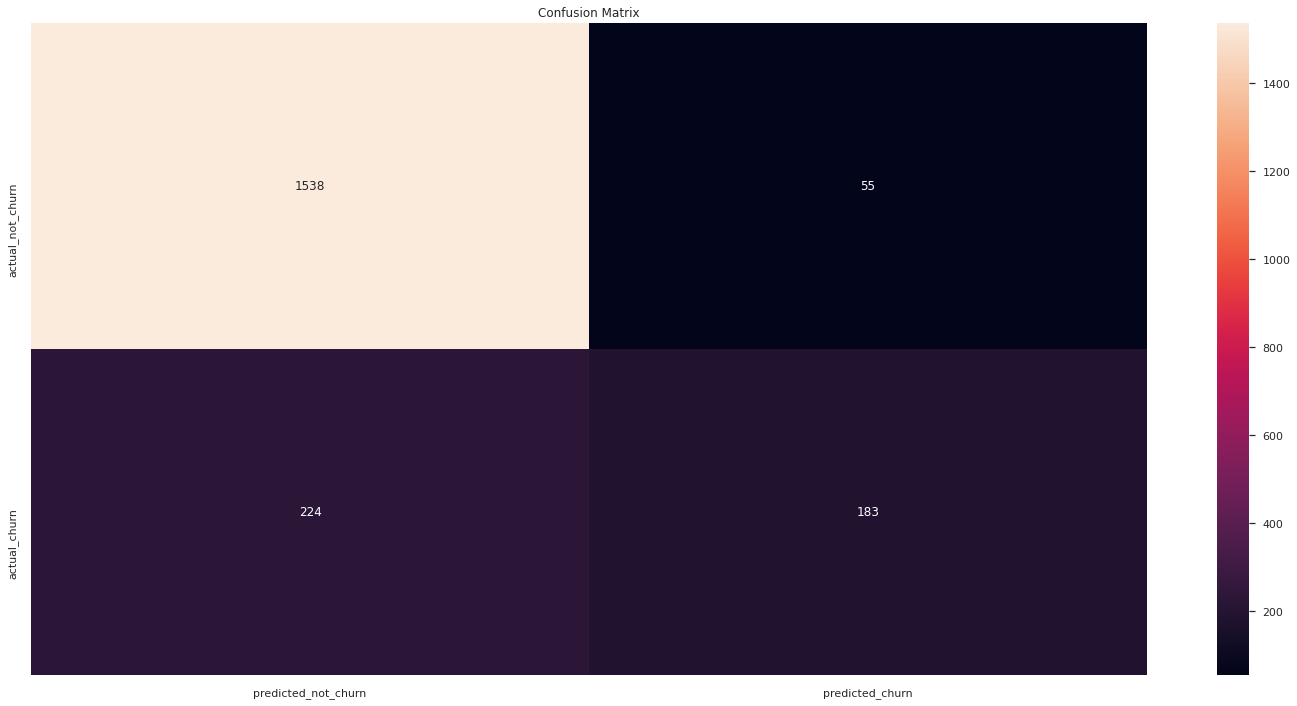

In [389]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [390]:
# Performance of model trained on balanced data
rf, cm = performance_test('Random Forest Imb', rf, x_test, y_test)
rf

,precision,recall,f1_score,roc_auc_score,mcc
Random Forest Imb,0.612091,0.597052,0.604478,0.750189,0.505059


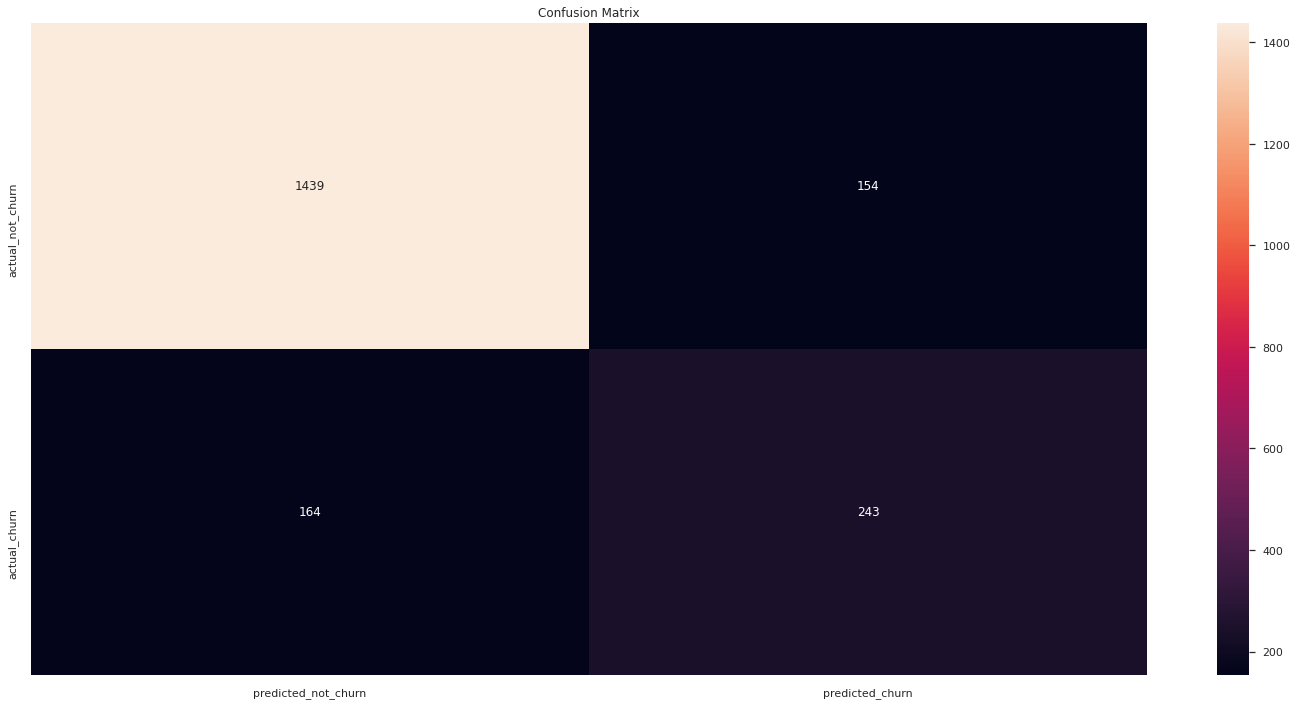

In [391]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

#### XGBoost

In [397]:
# Performance of model trained on imbalanced data
xgb_imb, cm = performance_test('XGBoost Imb', xgb_imb, x_test, y_test)
xgb_imb

,precision,recall,f1_score,roc_auc_score,mcc
XGBoost Imb,0.659933,0.481572,0.556818,0.709085,0.473448


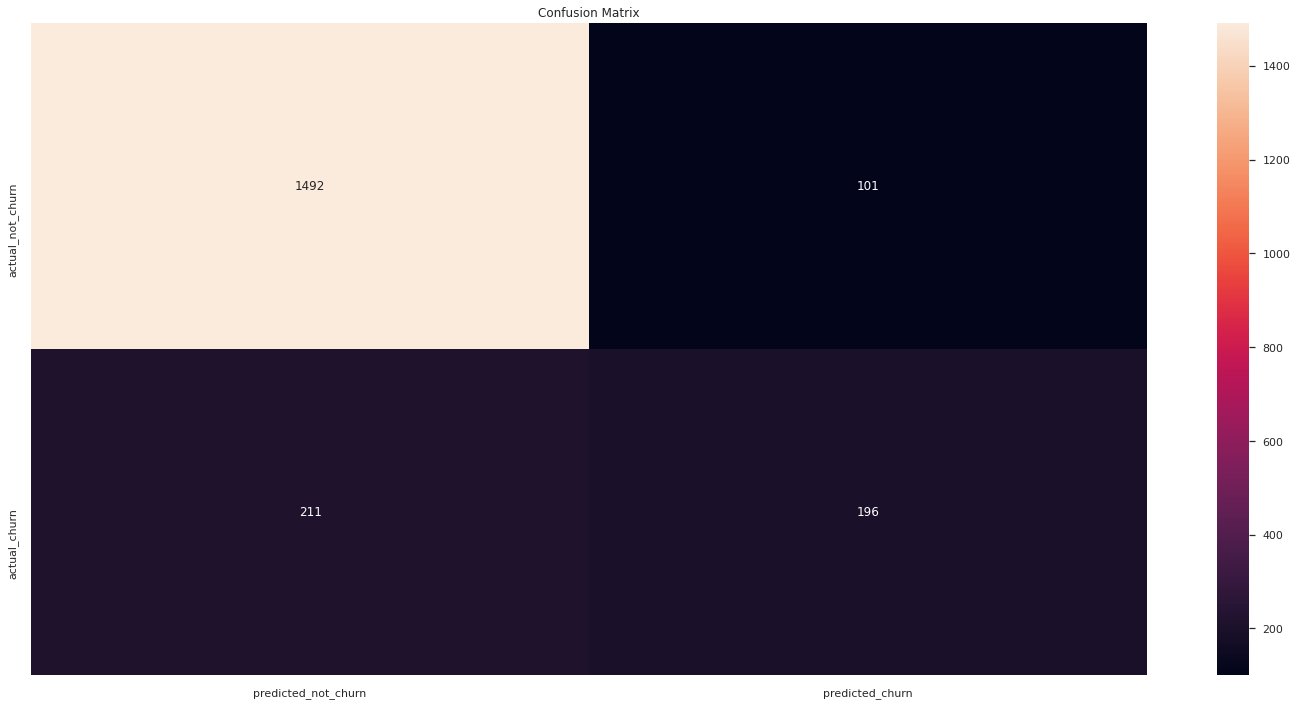

In [399]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [401]:
# Performance of model trained on balanced data
xgb, cm = performance_test('XGBoost', xgb, x_test, y_test)
xgb

ValueError: Feature shape mismatch, expected: 22, got 2000

In [ ]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

#### Random Forest Tunned

In [402]:
# Performance of model trained on balanced data
rf_imb_tuned, cm = performance_test('Random Forest Imb Tunned', rf_imb_tuned, x_test, y_test)
rf_imb_tuned

,precision,recall,f1_score,roc_auc_score,mcc
Random Forest Imb Tunned,0.805085,0.46683,0.59098,0.718977,0.546548


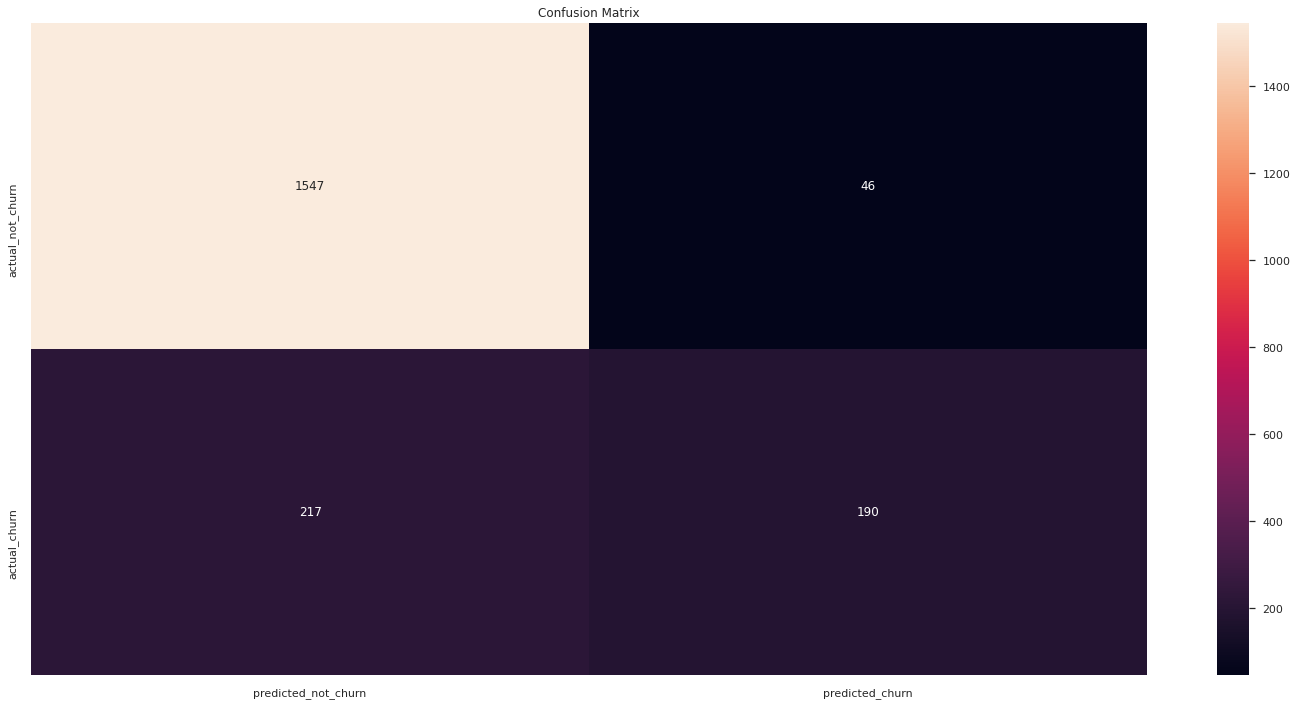

In [403]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [404]:
# Performance of model trained on balanced data
rf_tuned, cm = performance_test('Random Forest Tunned', rf_tuned, x_test, y_test)
rf_tuned

,precision,recall,f1_score,roc_auc_score,mcc
Random Forest Tunned,0.628571,0.594595,0.611111,0.752413,0.515503


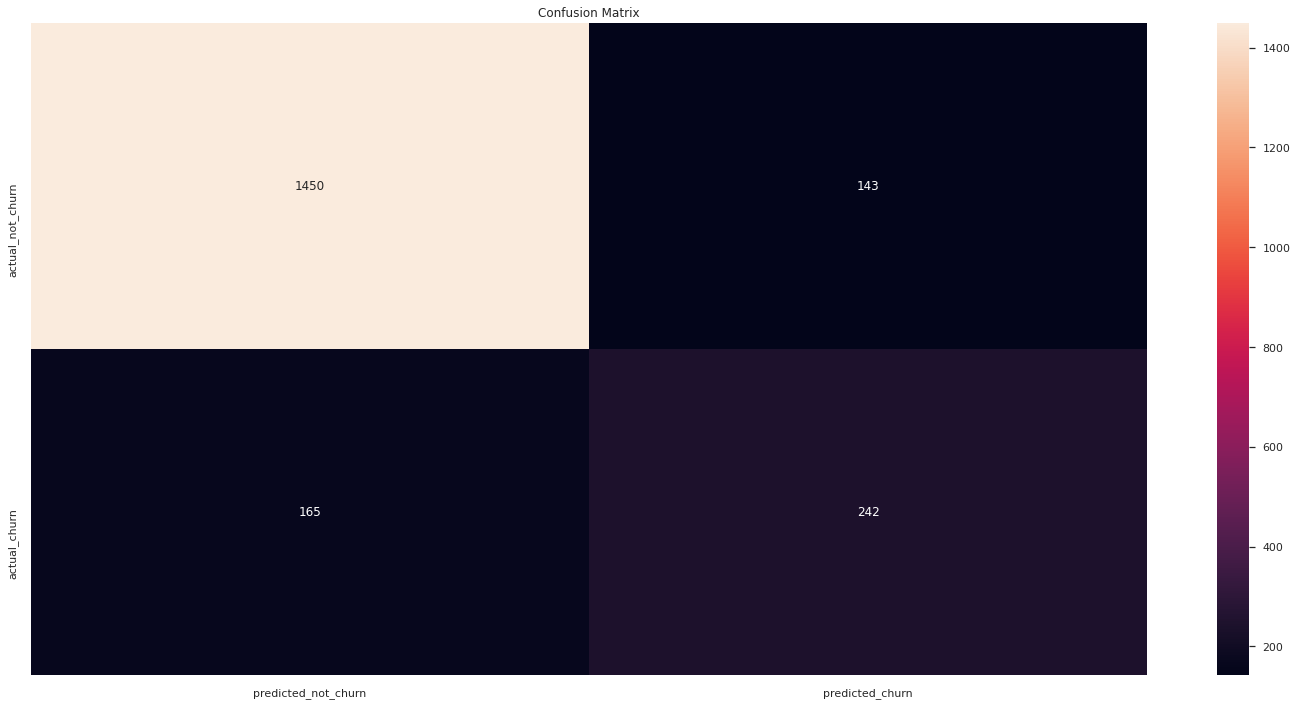

In [405]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

### Comparison

In [406]:
# concatenate the performance in the test dataset
metrics_comp = pd.concat([rf, rf_imb, 
                      rf_tuned, rf_imb_tuned])

metrics_comp

,precision,recall,f1_score,roc_auc_score,mcc
Random Forest Imb,0.612091,0.597052,0.604478,0.750189,0.505059
Random Forest Imb,0.768908,0.449631,0.567442,0.707553,0.516145
Random Forest Tunned,0.628571,0.594595,0.611111,0.752413,0.515503
Random Forest Imb Tunned,0.805085,0.466830,0.590980,0.718977,0.546548


# Business Performance

In [ ]:
# Random Forest Imb Data
# Radon Forest Balanced Data

# XGBoost Imb Data
# XGBoost Balanced Data

# RF imb Tuned
# RF balanced Tuned

In [ ]:
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
df5['tenure_year'] = mms.fit_transform(df5[['tenure_year']].values)
df5['balance'] = mms.fit_transform(df5[['balance']].values)
df5['has_cr_card'] = mms.fit_transform(df5[['has_cr_card']].values)
df5['is_active_member'] = mms.fit_transform(df5[['is_active_member']].values)
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)
df5['salary_by_credit'] = mms.fit_transform(df5[['salary_by_credit']].values)
df5['balance_by_prod'] = mms.fit_transform(df5[['balance_by_prod']].values)
df5['all_money'] = mms.fit_transform(df5[['all_money']].values)
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)

In [ ]:
#Robust Scaler
rss = RobustScaler()

#age
df5['age'] = rss.fit_transform(df5[['age']].values)
#salary_by_tenure
df5['salary_by_tenure'] = rss.fit_transform(df5[['salary_by_tenure']].values)
#age_by_tenure
df5['age_by_tenure'] = rss.fit_transform(df5[['age_by_tenure']].values)

#salary_by_age
df5['salary_by_age'] = rss.fit_transform(df5[['salary_by_age']].values)

#salary_by_tenure
df5['salary_by_tenure'] = rss.fit_transform(df5[['salary_by_tenure']].values)

#balance_by_age
df5['balance_by_age'] = rss.fit_transform(df5[['balance_by_age']].values)

#money_by_credit
df5['money_by_credit'] = rss.fit_transform(df5[['money_by_credit']].values)


In [ ]:


## applying transformations into test dataset

# Standard Scaler

# Robust Scaler

# Enconding in categorical variables

### ETL (Extract Transform Load)

In [ ]:
# # extract (merge)
# X_train
# y_train

# #tranform
# columns rename


# data preprocessing on test data

In [ ]:
# use model trained with imbalaced data
# model 

# predict
yhat = rf_imb_tuned.predict(X_train, y_train)

In [315]:
#test datasety
X_train
y_train

0    0.7965
1    0.2035
Name: exited, dtype: float64

In [317]:
X_test.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
5702,585,France,Male,36,7,0.00,2,1,0,94283.09,8,4.500000,161.167675,2618.974722,11785.386250,0.000000,0.000,94283.09,161.167675
3667,525,Germany,Male,33,4,131023.76,2,0,0,55072.93,5,6.600000,104.900819,1668.876667,11014.586000,3970.416970,65511.880,186096.69,354.469886
1617,557,Spain,Female,40,4,0.00,2,0,1,105433.53,5,8.000000,189.288205,2635.838250,21086.706000,0.000000,0.000,105433.53,189.288205
5673,639,Spain,Male,34,5,139393.19,2,0,0,33950.08,6,5.666667,53.130016,998.531765,5658.346667,4099.799706,69696.595,173343.27,271.272723
4272,640,Spain,Female,34,3,77826.80,1,1,1,168544.85,4,8.500000,263.351328,4957.201471,42136.212500,2289.023529,77826.800,246371.65,384.955703


# ERROR INTERPRETATION

# MODEL DEPLOYMENT